In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(566671, 828)
(566671, 8)
validation
(80437, 828)
(80437, 8)
test
(67038, 828)
(67038, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/57 [..............................] - ETA: 1:34 - loss: 2.1631 - STD: 0.0813 - MAE: 0.2180

 2/57 [>.............................] - ETA: 54s - loss: 1.9600 - STD: 0.0797 - MAE: 0.2075 

 5/57 [=>............................] - ETA: 13s - loss: 1.6099 - STD: 0.1479 - MAE: 0.1721

 6/57 [==>...........................] - ETA: 11s - loss: 1.5805 - STD: 0.1651 - MAE: 0.1645

 7/57 [==>...........................] - ETA: 9s - loss: 1.5601 - STD: 0.1778 - MAE: 0.1588 

 8/57 [===>..........................] - ETA: 8s - loss: 1.5460 - STD: 0.1867 - MAE: 0.1549

 9/57 [===>..........................] - ETA: 7s - loss: 1.5335 - STD: 0.1927 - MAE: 0.1522

10/57 [====>.........................] - ETA: 7s - loss: 1.5195 - STD: 0.1961 - MAE: 0.1505

11/57 [====>.........................] - ETA: 6s - loss: 1.5075 - STD: 0.1975 - MAE: 0.1496

12/57 [=====>........................] - ETA: 6s - loss: 1.4975 - STD: 0.1973 - MAE: 0.1494

13/57 [=====>........................] - ETA: 5s - loss: 1.4876 - STD: 0.1961 - MAE: 0.1496

14/57 [======>.......................] - ETA: 5s - loss: 1.4806 - STD: 0.1943 - MAE: 0.1501

15/57 [======>.......................] - ETA: 5s - loss: 1.4746 - STD: 0.1922 - MAE: 0.1507

16/57 [=======>......................] - ETA: 4s - loss: 1.4680 - STD: 0.1901 - MAE: 0.1513

17/57 [=======>......................] - ETA: 4s - loss: 1.4624 - STD: 0.1882 - MAE: 0.1518

18/57 [========>.....................] - ETA: 4s - loss: 1.4581 - STD: 0.1865 - MAE: 0.1523

19/57 [=========>....................] - ETA: 4s - loss: 1.4541 - STD: 0.1852 - MAE: 0.1527

20/57 [=========>....................] - ETA: 3s - loss: 1.4509 - STD: 0.1843 - MAE: 0.1529

21/57 [==========>...................] - ETA: 3s - loss: 1.4470 - STD: 0.1838 - MAE: 0.1530

22/57 [==========>...................] - ETA: 3s - loss: 1.4429 - STD: 0.1836 - MAE: 0.1530

23/57 [===========>..................] - ETA: 3s - loss: 1.4390 - STD: 0.1837 - MAE: 0.1528

24/57 [===========>..................] - ETA: 3s - loss: 1.4364 - STD: 0.1840 - MAE: 0.1526

25/57 [============>.................] - ETA: 3s - loss: 1.4338 - STD: 0.1845 - MAE: 0.1524

26/57 [============>.................] - ETA: 2s - loss: 1.4311 - STD: 0.1850 - MAE: 0.1521

27/57 [=============>................] - ETA: 2s - loss: 1.4292 - STD: 0.1856 - MAE: 0.1519

28/57 [=============>................] - ETA: 2s - loss: 1.4272 - STD: 0.1862 - MAE: 0.1516

29/57 [==============>...............] - ETA: 2s - loss: 1.4252 - STD: 0.1866 - MAE: 0.1514

30/57 [==============>...............] - ETA: 2s - loss: 1.4235 - STD: 0.1869 - MAE: 0.1513

31/57 [===============>..............] - ETA: 2s - loss: 1.4210 - STD: 0.1872 - MAE: 0.1511

32/57 [===============>..............] - ETA: 2s - loss: 1.4191 - STD: 0.1872 - MAE: 0.1510

33/57 [================>.............] - ETA: 2s - loss: 1.4175 - STD: 0.1872 - MAE: 0.1510

34/57 [================>.............] - ETA: 1s - loss: 1.4158 - STD: 0.1871 - MAE: 0.1510

35/57 [=================>............] - ETA: 1s - loss: 1.4145 - STD: 0.1869 - MAE: 0.1511

36/57 [=================>............] - ETA: 1s - loss: 1.4130 - STD: 0.1866 - MAE: 0.1511

37/57 [==================>...........] - ETA: 1s - loss: 1.4118 - STD: 0.1864 - MAE: 0.1512

38/57 [===================>..........] - ETA: 1s - loss: 1.4111 - STD: 0.1861 - MAE: 0.1513

39/57 [===================>..........] - ETA: 1s - loss: 1.4098 - STD: 0.1859 - MAE: 0.1513

40/57 [====================>.........] - ETA: 1s - loss: 1.4084 - STD: 0.1856 - MAE: 0.1514

41/57 [====================>.........] - ETA: 1s - loss: 1.4071 - STD: 0.1855 - MAE: 0.1514

42/57 [=====================>........] - ETA: 1s - loss: 1.4060 - STD: 0.1854 - MAE: 0.1514

43/57 [=====================>........] - ETA: 1s - loss: 1.4045 - STD: 0.1853 - MAE: 0.1514

44/57 [======================>.......] - ETA: 1s - loss: 1.4034 - STD: 0.1853 - MAE: 0.1513

45/57 [======================>.......] - ETA: 0s - loss: 1.4020 - STD: 0.1854 - MAE: 0.1512

46/57 [=======================>......] - ETA: 0s - loss: 1.4009 - STD: 0.1855 - MAE: 0.1512

47/57 [=======================>......] - ETA: 0s - loss: 1.3996 - STD: 0.1856 - MAE: 0.1511

48/57 [========================>.....] - ETA: 0s - loss: 1.3990 - STD: 0.1857 - MAE: 0.1510

49/57 [========================>.....] - ETA: 0s - loss: 1.3979 - STD: 0.1859 - MAE: 0.1509

50/57 [=========================>....] - ETA: 0s - loss: 1.3969 - STD: 0.1860 - MAE: 0.1509

51/57 [=========================>....] - ETA: 0s - loss: 1.3963 - STD: 0.1861 - MAE: 0.1508

52/57 [==========================>...] - ETA: 0s - loss: 1.3954 - STD: 0.1861 - MAE: 0.1508

53/57 [==========================>...] - ETA: 0s - loss: 1.3948 - STD: 0.1861 - MAE: 0.1508

54/57 [===========================>..] - ETA: 0s - loss: 1.3939 - STD: 0.1861 - MAE: 0.1507

55/57 [===========================>..] - ETA: 0s - loss: 1.3935 - STD: 0.1861 - MAE: 0.1507

56/57 [============================>.] - ETA: 0s - loss: 1.3929 - STD: 0.1860 - MAE: 0.1507

57/57 [==============================] - ETA: 0s - loss: 1.3921 - STD: 0.1859 - MAE: 0.1508

57/57 [==============================] - 7s 87ms/step - loss: 1.3921 - STD: 0.1859 - MAE: 0.1508 - val_loss: 1.3369 - val_STD: 0.1810 - val_MAE: 0.1500


Epoch 2/10000


 1/57 [..............................] - ETA: 5s - loss: 1.3649 - STD: 0.1810 - MAE: 0.1521

 2/57 [>.............................] - ETA: 3s - loss: 1.3599 - STD: 0.1810 - MAE: 0.1517

 3/57 [>.............................] - ETA: 3s - loss: 1.3634 - STD: 0.1811 - MAE: 0.1520

 4/57 [=>............................] - ETA: 3s - loss: 1.3584 - STD: 0.1814 - MAE: 0.1516

 5/57 [=>............................] - ETA: 3s - loss: 1.3586 - STD: 0.1817 - MAE: 0.1515

 6/57 [==>...........................] - ETA: 3s - loss: 1.3622 - STD: 0.1822 - MAE: 0.1515

 7/57 [==>...........................] - ETA: 2s - loss: 1.3594 - STD: 0.1826 - MAE: 0.1511

 8/57 [===>..........................] - ETA: 2s - loss: 1.3603 - STD: 0.1831 - MAE: 0.1510

 9/57 [===>..........................] - ETA: 2s - loss: 1.3589 - STD: 0.1836 - MAE: 0.1508

10/57 [====>.........................] - ETA: 2s - loss: 1.3583 - STD: 0.1840 - MAE: 0.1506

11/57 [====>.........................] - ETA: 2s - loss: 1.3574 - STD: 0.1843 - MAE: 0.1505

12/57 [=====>........................] - ETA: 2s - loss: 1.3561 - STD: 0.1846 - MAE: 0.1503

13/57 [=====>........................] - ETA: 2s - loss: 1.3557 - STD: 0.1848 - MAE: 0.1501

14/57 [======>.......................] - ETA: 2s - loss: 1.3565 - STD: 0.1850 - MAE: 0.1501

15/57 [======>.......................] - ETA: 2s - loss: 1.3563 - STD: 0.1851 - MAE: 0.1501

16/57 [=======>......................] - ETA: 2s - loss: 1.3555 - STD: 0.1852 - MAE: 0.1500

17/57 [=======>......................] - ETA: 2s - loss: 1.3559 - STD: 0.1852 - MAE: 0.1500

18/57 [========>.....................] - ETA: 2s - loss: 1.3556 - STD: 0.1852 - MAE: 0.1500

19/57 [=========>....................] - ETA: 2s - loss: 1.3553 - STD: 0.1852 - MAE: 0.1500

20/57 [=========>....................] - ETA: 2s - loss: 1.3549 - STD: 0.1852 - MAE: 0.1500

21/57 [==========>...................] - ETA: 2s - loss: 1.3547 - STD: 0.1851 - MAE: 0.1500

22/57 [==========>...................] - ETA: 2s - loss: 1.3546 - STD: 0.1851 - MAE: 0.1500

23/57 [===========>..................] - ETA: 2s - loss: 1.3546 - STD: 0.1852 - MAE: 0.1500

24/57 [===========>..................] - ETA: 1s - loss: 1.3551 - STD: 0.1852 - MAE: 0.1500

25/57 [============>.................] - ETA: 1s - loss: 1.3553 - STD: 0.1852 - MAE: 0.1500

26/57 [============>.................] - ETA: 1s - loss: 1.3551 - STD: 0.1853 - MAE: 0.1499

27/57 [=============>................] - ETA: 1s - loss: 1.3545 - STD: 0.1853 - MAE: 0.1499

28/57 [=============>................] - ETA: 1s - loss: 1.3542 - STD: 0.1853 - MAE: 0.1499

29/57 [==============>...............] - ETA: 1s - loss: 1.3544 - STD: 0.1854 - MAE: 0.1499

30/57 [==============>...............] - ETA: 1s - loss: 1.3545 - STD: 0.1854 - MAE: 0.1499

31/57 [===============>..............] - ETA: 1s - loss: 1.3541 - STD: 0.1854 - MAE: 0.1498

32/57 [===============>..............] - ETA: 1s - loss: 1.3546 - STD: 0.1854 - MAE: 0.1499

33/57 [================>.............] - ETA: 1s - loss: 1.3546 - STD: 0.1854 - MAE: 0.1499

35/57 [=================>............] - ETA: 1s - loss: 1.3542 - STD: 0.1853 - MAE: 0.1499

36/57 [=================>............] - ETA: 1s - loss: 1.3543 - STD: 0.1853 - MAE: 0.1499

37/57 [==================>...........] - ETA: 1s - loss: 1.3543 - STD: 0.1852 - MAE: 0.1499

38/57 [===================>..........] - ETA: 1s - loss: 1.3537 - STD: 0.1852 - MAE: 0.1499

39/57 [===================>..........] - ETA: 1s - loss: 1.3543 - STD: 0.1852 - MAE: 0.1499

40/57 [====================>.........] - ETA: 1s - loss: 1.3540 - STD: 0.1851 - MAE: 0.1499

41/57 [====================>.........] - ETA: 0s - loss: 1.3539 - STD: 0.1851 - MAE: 0.1499

42/57 [=====================>........] - ETA: 0s - loss: 1.3535 - STD: 0.1851 - MAE: 0.1499

43/57 [=====================>........] - ETA: 0s - loss: 1.3529 - STD: 0.1851 - MAE: 0.1499

44/57 [======================>.......] - ETA: 0s - loss: 1.3525 - STD: 0.1852 - MAE: 0.1499

45/57 [======================>.......] - ETA: 0s - loss: 1.3527 - STD: 0.1852 - MAE: 0.1499

46/57 [=======================>......] - ETA: 0s - loss: 1.3524 - STD: 0.1852 - MAE: 0.1498

47/57 [=======================>......] - ETA: 0s - loss: 1.3521 - STD: 0.1853 - MAE: 0.1498

48/57 [========================>.....] - ETA: 0s - loss: 1.3517 - STD: 0.1853 - MAE: 0.1498

49/57 [========================>.....] - ETA: 0s - loss: 1.3515 - STD: 0.1853 - MAE: 0.1498

50/57 [=========================>....] - ETA: 0s - loss: 1.3510 - STD: 0.1853 - MAE: 0.1498

51/57 [=========================>....] - ETA: 0s - loss: 1.3510 - STD: 0.1853 - MAE: 0.1498

52/57 [==========================>...] - ETA: 0s - loss: 1.3507 - STD: 0.1852 - MAE: 0.1498

53/57 [==========================>...] - ETA: 0s - loss: 1.3508 - STD: 0.1852 - MAE: 0.1498

54/57 [===========================>..] - ETA: 0s - loss: 1.3508 - STD: 0.1852 - MAE: 0.1498

55/57 [===========================>..] - ETA: 0s - loss: 1.3506 - STD: 0.1851 - MAE: 0.1499

56/57 [============================>.] - ETA: 0s - loss: 1.3502 - STD: 0.1850 - MAE: 0.1499

57/57 [==============================] - ETA: 0s - loss: 1.3496 - STD: 0.1850 - MAE: 0.1499

57/57 [==============================] - 4s 63ms/step - loss: 1.3496 - STD: 0.1850 - MAE: 0.1499 - val_loss: 1.2875 - val_STD: 0.1853 - val_MAE: 0.1467


Epoch 3/10000


 1/57 [..............................] - ETA: 5s - loss: 1.2988 - STD: 0.1832 - MAE: 0.1484

 2/57 [>.............................] - ETA: 3s - loss: 1.3026 - STD: 0.1849 - MAE: 0.1479

 3/57 [>.............................] - ETA: 3s - loss: 1.3037 - STD: 0.1862 - MAE: 0.1477

 4/57 [=>............................] - ETA: 3s - loss: 1.3066 - STD: 0.1867 - MAE: 0.1477

 5/57 [=>............................] - ETA: 3s - loss: 1.3043 - STD: 0.1866 - MAE: 0.1477

 6/57 [==>...........................] - ETA: 3s - loss: 1.3036 - STD: 0.1863 - MAE: 0.1478

 7/57 [==>...........................] - ETA: 2s - loss: 1.3016 - STD: 0.1863 - MAE: 0.1477

 8/57 [===>..........................] - ETA: 2s - loss: 1.3027 - STD: 0.1867 - MAE: 0.1476

 9/57 [===>..........................] - ETA: 2s - loss: 1.3000 - STD: 0.1871 - MAE: 0.1474

10/57 [====>.........................] - ETA: 2s - loss: 1.2982 - STD: 0.1874 - MAE: 0.1472

11/57 [====>.........................] - ETA: 2s - loss: 1.2963 - STD: 0.1876 - MAE: 0.1471

12/57 [=====>........................] - ETA: 2s - loss: 1.2959 - STD: 0.1877 - MAE: 0.1471

13/57 [=====>........................] - ETA: 2s - loss: 1.2953 - STD: 0.1876 - MAE: 0.1471

14/57 [======>.......................] - ETA: 2s - loss: 1.2949 - STD: 0.1875 - MAE: 0.1472

15/57 [======>.......................] - ETA: 2s - loss: 1.2935 - STD: 0.1875 - MAE: 0.1471

16/57 [=======>......................] - ETA: 2s - loss: 1.2927 - STD: 0.1876 - MAE: 0.1470

17/57 [=======>......................] - ETA: 2s - loss: 1.2911 - STD: 0.1878 - MAE: 0.1469

18/57 [========>.....................] - ETA: 2s - loss: 1.2893 - STD: 0.1878 - MAE: 0.1468

19/57 [=========>....................] - ETA: 2s - loss: 1.2877 - STD: 0.1879 - MAE: 0.1468

20/57 [=========>....................] - ETA: 2s - loss: 1.2859 - STD: 0.1880 - MAE: 0.1467

21/57 [==========>...................] - ETA: 2s - loss: 1.2846 - STD: 0.1883 - MAE: 0.1465

23/57 [===========>..................] - ETA: 1s - loss: 1.2825 - STD: 0.1884 - MAE: 0.1464

24/57 [===========>..................] - ETA: 1s - loss: 1.2811 - STD: 0.1884 - MAE: 0.1464

25/57 [============>.................] - ETA: 1s - loss: 1.2797 - STD: 0.1886 - MAE: 0.1463

26/57 [============>.................] - ETA: 1s - loss: 1.2775 - STD: 0.1886 - MAE: 0.1463

27/57 [=============>................] - ETA: 1s - loss: 1.2764 - STD: 0.1885 - MAE: 0.1463

28/57 [=============>................] - ETA: 1s - loss: 1.2752 - STD: 0.1886 - MAE: 0.1462

29/57 [==============>...............] - ETA: 1s - loss: 1.2735 - STD: 0.1886 - MAE: 0.1462

30/57 [==============>...............] - ETA: 1s - loss: 1.2724 - STD: 0.1887 - MAE: 0.1462

31/57 [===============>..............] - ETA: 1s - loss: 1.2708 - STD: 0.1887 - MAE: 0.1461

32/57 [===============>..............] - ETA: 1s - loss: 1.2684 - STD: 0.1887 - MAE: 0.1460

33/57 [================>.............] - ETA: 1s - loss: 1.2669 - STD: 0.1889 - MAE: 0.1459

34/57 [================>.............] - ETA: 1s - loss: 1.2651 - STD: 0.1890 - MAE: 0.1458

35/57 [=================>............] - ETA: 1s - loss: 1.2636 - STD: 0.1892 - MAE: 0.1457

36/57 [=================>............] - ETA: 1s - loss: 1.2616 - STD: 0.1894 - MAE: 0.1456

37/57 [==================>...........] - ETA: 1s - loss: 1.2602 - STD: 0.1895 - MAE: 0.1455

38/57 [===================>..........] - ETA: 1s - loss: 1.2583 - STD: 0.1895 - MAE: 0.1455

39/57 [===================>..........] - ETA: 1s - loss: 1.2573 - STD: 0.1897 - MAE: 0.1454

40/57 [====================>.........] - ETA: 0s - loss: 1.2559 - STD: 0.1896 - MAE: 0.1453

41/57 [====================>.........] - ETA: 0s - loss: 1.2550 - STD: 0.1896 - MAE: 0.1453

42/57 [=====================>........] - ETA: 0s - loss: 1.2534 - STD: 0.1898 - MAE: 0.1452

43/57 [=====================>........] - ETA: 0s - loss: 1.2525 - STD: 0.1898 - MAE: 0.1452

44/57 [======================>.......] - ETA: 0s - loss: 1.2514 - STD: 0.1898 - MAE: 0.1452

45/57 [======================>.......] - ETA: 0s - loss: 1.2501 - STD: 0.1899 - MAE: 0.1451

46/57 [=======================>......] - ETA: 0s - loss: 1.2487 - STD: 0.1900 - MAE: 0.1451

47/57 [=======================>......] - ETA: 0s - loss: 1.2473 - STD: 0.1899 - MAE: 0.1450

48/57 [========================>.....] - ETA: 0s - loss: 1.2461 - STD: 0.1900 - MAE: 0.1450

49/57 [========================>.....] - ETA: 0s - loss: 1.2451 - STD: 0.1902 - MAE: 0.1449

50/57 [=========================>....] - ETA: 0s - loss: 1.2440 - STD: 0.1902 - MAE: 0.1448

51/57 [=========================>....] - ETA: 0s - loss: 1.2426 - STD: 0.1902 - MAE: 0.1448

52/57 [==========================>...] - ETA: 0s - loss: 1.2416 - STD: 0.1904 - MAE: 0.1447

53/57 [==========================>...] - ETA: 0s - loss: 1.2405 - STD: 0.1906 - MAE: 0.1446

54/57 [===========================>..] - ETA: 0s - loss: 1.2391 - STD: 0.1906 - MAE: 0.1446

55/57 [===========================>..] - ETA: 0s - loss: 1.2379 - STD: 0.1906 - MAE: 0.1445

56/57 [============================>.] - ETA: 0s - loss: 1.2366 - STD: 0.1907 - MAE: 0.1444

57/57 [==============================] - ETA: 0s - loss: 1.2356 - STD: 0.1908 - MAE: 0.1444

57/57 [==============================] - 4s 63ms/step - loss: 1.2356 - STD: 0.1908 - MAE: 0.1444 - val_loss: 1.1272 - val_STD: 0.1998 - val_MAE: 0.1365


Epoch 4/10000


 1/57 [..............................] - ETA: 5s - loss: 1.1546 - STD: 0.1942 - MAE: 0.1399

 2/57 [>.............................] - ETA: 3s - loss: 1.1637 - STD: 0.1953 - MAE: 0.1401

 4/57 [=>............................] - ETA: 2s - loss: 1.1636 - STD: 0.1966 - MAE: 0.1395

 5/57 [=>............................] - ETA: 2s - loss: 1.1650 - STD: 0.1964 - MAE: 0.1398

 6/57 [==>...........................] - ETA: 2s - loss: 1.1635 - STD: 0.1964 - MAE: 0.1398

 7/57 [==>...........................] - ETA: 2s - loss: 1.1641 - STD: 0.1965 - MAE: 0.1398

 8/57 [===>..........................] - ETA: 2s - loss: 1.1635 - STD: 0.1960 - MAE: 0.1400

 9/57 [===>..........................] - ETA: 2s - loss: 1.1635 - STD: 0.1959 - MAE: 0.1400

10/57 [====>.........................] - ETA: 2s - loss: 1.1635 - STD: 0.1960 - MAE: 0.1400

11/57 [====>.........................] - ETA: 2s - loss: 1.1627 - STD: 0.1961 - MAE: 0.1399

12/57 [=====>........................] - ETA: 2s - loss: 1.1622 - STD: 0.1962 - MAE: 0.1398

13/57 [=====>........................] - ETA: 2s - loss: 1.1609 - STD: 0.1963 - MAE: 0.1397

14/57 [======>.......................] - ETA: 2s - loss: 1.1609 - STD: 0.1964 - MAE: 0.1397

15/57 [======>.......................] - ETA: 2s - loss: 1.1602 - STD: 0.1964 - MAE: 0.1397

16/57 [=======>......................] - ETA: 2s - loss: 1.1591 - STD: 0.1963 - MAE: 0.1397

17/57 [=======>......................] - ETA: 2s - loss: 1.1590 - STD: 0.1961 - MAE: 0.1398

18/57 [========>.....................] - ETA: 2s - loss: 1.1583 - STD: 0.1962 - MAE: 0.1397

19/57 [=========>....................] - ETA: 2s - loss: 1.1572 - STD: 0.1964 - MAE: 0.1396

20/57 [=========>....................] - ETA: 2s - loss: 1.1556 - STD: 0.1966 - MAE: 0.1394

21/57 [==========>...................] - ETA: 2s - loss: 1.1539 - STD: 0.1968 - MAE: 0.1393

22/57 [==========>...................] - ETA: 2s - loss: 1.1534 - STD: 0.1971 - MAE: 0.1391

23/57 [===========>..................] - ETA: 1s - loss: 1.1534 - STD: 0.1972 - MAE: 0.1391

24/57 [===========>..................] - ETA: 1s - loss: 1.1523 - STD: 0.1970 - MAE: 0.1392

25/57 [============>.................] - ETA: 1s - loss: 1.1517 - STD: 0.1969 - MAE: 0.1392

26/57 [============>.................] - ETA: 1s - loss: 1.1501 - STD: 0.1967 - MAE: 0.1392

27/57 [=============>................] - ETA: 1s - loss: 1.1494 - STD: 0.1969 - MAE: 0.1391

28/57 [=============>................] - ETA: 1s - loss: 1.1480 - STD: 0.1973 - MAE: 0.1389

29/57 [==============>...............] - ETA: 1s - loss: 1.1468 - STD: 0.1976 - MAE: 0.1387

30/57 [==============>...............] - ETA: 1s - loss: 1.1462 - STD: 0.1977 - MAE: 0.1386

31/57 [===============>..............] - ETA: 1s - loss: 1.1452 - STD: 0.1977 - MAE: 0.1386

32/57 [===============>..............] - ETA: 1s - loss: 1.1437 - STD: 0.1976 - MAE: 0.1386

33/57 [================>.............] - ETA: 1s - loss: 1.1429 - STD: 0.1977 - MAE: 0.1385

34/57 [================>.............] - ETA: 1s - loss: 1.1419 - STD: 0.1980 - MAE: 0.1384

35/57 [=================>............] - ETA: 1s - loss: 1.1411 - STD: 0.1983 - MAE: 0.1382

36/57 [=================>............] - ETA: 1s - loss: 1.1406 - STD: 0.1984 - MAE: 0.1381

37/57 [==================>...........] - ETA: 1s - loss: 1.1397 - STD: 0.1984 - MAE: 0.1381

38/57 [===================>..........] - ETA: 1s - loss: 1.1393 - STD: 0.1984 - MAE: 0.1381

39/57 [===================>..........] - ETA: 1s - loss: 1.1383 - STD: 0.1985 - MAE: 0.1380

40/57 [====================>.........] - ETA: 0s - loss: 1.1377 - STD: 0.1987 - MAE: 0.1379

41/57 [====================>.........] - ETA: 0s - loss: 1.1373 - STD: 0.1990 - MAE: 0.1378

42/57 [=====================>........] - ETA: 0s - loss: 1.1367 - STD: 0.1991 - MAE: 0.1377

43/57 [=====================>........] - ETA: 0s - loss: 1.1360 - STD: 0.1990 - MAE: 0.1377

44/57 [======================>.......] - ETA: 0s - loss: 1.1349 - STD: 0.1989 - MAE: 0.1377

45/57 [======================>.......] - ETA: 0s - loss: 1.1338 - STD: 0.1991 - MAE: 0.1376

46/57 [=======================>......] - ETA: 0s - loss: 1.1327 - STD: 0.1994 - MAE: 0.1374

47/57 [=======================>......] - ETA: 0s - loss: 1.1321 - STD: 0.1996 - MAE: 0.1373

48/57 [========================>.....] - ETA: 0s - loss: 1.1311 - STD: 0.1996 - MAE: 0.1372

49/57 [========================>.....] - ETA: 0s - loss: 1.1307 - STD: 0.1996 - MAE: 0.1373

50/57 [=========================>....] - ETA: 0s - loss: 1.1297 - STD: 0.1995 - MAE: 0.1372

51/57 [=========================>....] - ETA: 0s - loss: 1.1289 - STD: 0.1997 - MAE: 0.1371

52/57 [==========================>...] - ETA: 0s - loss: 1.1283 - STD: 0.2000 - MAE: 0.1370

53/57 [==========================>...] - ETA: 0s - loss: 1.1275 - STD: 0.2001 - MAE: 0.1369

54/57 [===========================>..] - ETA: 0s - loss: 1.1267 - STD: 0.2000 - MAE: 0.1369

55/57 [===========================>..] - ETA: 0s - loss: 1.1258 - STD: 0.2001 - MAE: 0.1368

56/57 [============================>.] - ETA: 0s - loss: 1.1253 - STD: 0.2003 - MAE: 0.1367

57/57 [==============================] - ETA: 0s - loss: 1.1249 - STD: 0.2004 - MAE: 0.1366

57/57 [==============================] - 4s 62ms/step - loss: 1.1249 - STD: 0.2004 - MAE: 0.1366 - val_loss: 1.0306 - val_STD: 0.2130 - val_MAE: 0.1257


Epoch 5/10000


 1/57 [..............................] - ETA: 4s - loss: 1.0706 - STD: 0.2016 - MAE: 0.1332

 2/57 [>.............................] - ETA: 3s - loss: 1.0700 - STD: 0.2021 - MAE: 0.1331

 3/57 [>.............................] - ETA: 3s - loss: 1.0681 - STD: 0.2051 - MAE: 0.1317

 4/57 [=>............................] - ETA: 3s - loss: 1.0650 - STD: 0.2071 - MAE: 0.1308

 5/57 [=>............................] - ETA: 2s - loss: 1.0656 - STD: 0.2071 - MAE: 0.1308

 6/57 [==>...........................] - ETA: 2s - loss: 1.0676 - STD: 0.2058 - MAE: 0.1315

 7/57 [==>...........................] - ETA: 2s - loss: 1.0703 - STD: 0.2059 - MAE: 0.1317

 8/57 [===>..........................] - ETA: 2s - loss: 1.0672 - STD: 0.2061 - MAE: 0.1315

 9/57 [===>..........................] - ETA: 2s - loss: 1.0663 - STD: 0.2068 - MAE: 0.1311

10/57 [====>.........................] - ETA: 2s - loss: 1.0661 - STD: 0.2065 - MAE: 0.1313

11/57 [====>.........................] - ETA: 2s - loss: 1.0656 - STD: 0.2062 - MAE: 0.1313

12/57 [=====>........................] - ETA: 2s - loss: 1.0663 - STD: 0.2067 - MAE: 0.1311

13/57 [=====>........................] - ETA: 2s - loss: 1.0656 - STD: 0.2069 - MAE: 0.1310

14/57 [======>.......................] - ETA: 2s - loss: 1.0654 - STD: 0.2069 - MAE: 0.1309

15/57 [======>.......................] - ETA: 2s - loss: 1.0655 - STD: 0.2073 - MAE: 0.1308

16/57 [=======>......................] - ETA: 2s - loss: 1.0646 - STD: 0.2072 - MAE: 0.1308

17/57 [=======>......................] - ETA: 2s - loss: 1.0643 - STD: 0.2074 - MAE: 0.1307

18/57 [========>.....................] - ETA: 2s - loss: 1.0634 - STD: 0.2075 - MAE: 0.1306

19/57 [=========>....................] - ETA: 2s - loss: 1.0617 - STD: 0.2082 - MAE: 0.1302

20/57 [=========>....................] - ETA: 2s - loss: 1.0613 - STD: 0.2081 - MAE: 0.1302

21/57 [==========>...................] - ETA: 2s - loss: 1.0599 - STD: 0.2081 - MAE: 0.1301

22/57 [==========>...................] - ETA: 1s - loss: 1.0595 - STD: 0.2088 - MAE: 0.1298

23/57 [===========>..................] - ETA: 1s - loss: 1.0584 - STD: 0.2085 - MAE: 0.1298

24/57 [===========>..................] - ETA: 1s - loss: 1.0579 - STD: 0.2085 - MAE: 0.1298

25/57 [============>.................] - ETA: 1s - loss: 1.0576 - STD: 0.2089 - MAE: 0.1296

26/57 [============>.................] - ETA: 1s - loss: 1.0564 - STD: 0.2087 - MAE: 0.1296

27/57 [=============>................] - ETA: 1s - loss: 1.0555 - STD: 0.2090 - MAE: 0.1295

28/57 [=============>................] - ETA: 1s - loss: 1.0551 - STD: 0.2092 - MAE: 0.1294

29/57 [==============>...............] - ETA: 1s - loss: 1.0546 - STD: 0.2091 - MAE: 0.1294

30/57 [==============>...............] - ETA: 1s - loss: 1.0538 - STD: 0.2092 - MAE: 0.1293

31/57 [===============>..............] - ETA: 1s - loss: 1.0534 - STD: 0.2095 - MAE: 0.1292

33/57 [================>.............] - ETA: 1s - loss: 1.0523 - STD: 0.2095 - MAE: 0.1291

34/57 [================>.............] - ETA: 1s - loss: 1.0512 - STD: 0.2098 - MAE: 0.1289

35/57 [=================>............] - ETA: 1s - loss: 1.0507 - STD: 0.2097 - MAE: 0.1289

36/57 [=================>............] - ETA: 1s - loss: 1.0504 - STD: 0.2098 - MAE: 0.1289

37/57 [==================>...........] - ETA: 1s - loss: 1.0500 - STD: 0.2100 - MAE: 0.1288

38/57 [===================>..........] - ETA: 1s - loss: 1.0491 - STD: 0.2098 - MAE: 0.1288

39/57 [===================>..........] - ETA: 0s - loss: 1.0489 - STD: 0.2102 - MAE: 0.1286

40/57 [====================>.........] - ETA: 0s - loss: 1.0482 - STD: 0.2103 - MAE: 0.1286

41/57 [====================>.........] - ETA: 0s - loss: 1.0474 - STD: 0.2102 - MAE: 0.1285

42/57 [=====================>........] - ETA: 0s - loss: 1.0464 - STD: 0.2105 - MAE: 0.1284

43/57 [=====================>........] - ETA: 0s - loss: 1.0461 - STD: 0.2107 - MAE: 0.1283

44/57 [======================>.......] - ETA: 0s - loss: 1.0457 - STD: 0.2104 - MAE: 0.1284

45/57 [======================>.......] - ETA: 0s - loss: 1.0447 - STD: 0.2105 - MAE: 0.1283

46/57 [=======================>......] - ETA: 0s - loss: 1.0442 - STD: 0.2109 - MAE: 0.1281

47/57 [=======================>......] - ETA: 0s - loss: 1.0437 - STD: 0.2108 - MAE: 0.1281

48/57 [========================>.....] - ETA: 0s - loss: 1.0427 - STD: 0.2107 - MAE: 0.1281

49/57 [========================>.....] - ETA: 0s - loss: 1.0420 - STD: 0.2111 - MAE: 0.1279

50/57 [=========================>....] - ETA: 0s - loss: 1.0412 - STD: 0.2113 - MAE: 0.1278

51/57 [=========================>....] - ETA: 0s - loss: 1.0405 - STD: 0.2111 - MAE: 0.1278

52/57 [==========================>...] - ETA: 0s - loss: 1.0397 - STD: 0.2111 - MAE: 0.1278

53/57 [==========================>...] - ETA: 0s - loss: 1.0390 - STD: 0.2114 - MAE: 0.1276

54/57 [===========================>..] - ETA: 0s - loss: 1.0387 - STD: 0.2115 - MAE: 0.1276

55/57 [===========================>..] - ETA: 0s - loss: 1.0383 - STD: 0.2113 - MAE: 0.1277

56/57 [============================>.] - ETA: 0s - loss: 1.0378 - STD: 0.2114 - MAE: 0.1276

57/57 [==============================] - ETA: 0s - loss: 1.0374 - STD: 0.2116 - MAE: 0.1275

57/57 [==============================] - 3s 59ms/step - loss: 1.0374 - STD: 0.2116 - MAE: 0.1275 - val_loss: 0.9600 - val_STD: 0.2249 - val_MAE: 0.1180


Epoch 6/10000


 1/57 [..............................] - ETA: 5s - loss: 1.0077 - STD: 0.2135 - MAE: 0.1254

 2/57 [>.............................] - ETA: 3s - loss: 1.0030 - STD: 0.2095 - MAE: 0.1269

 3/57 [>.............................] - ETA: 3s - loss: 1.0067 - STD: 0.2119 - MAE: 0.1261

 4/57 [=>............................] - ETA: 3s - loss: 1.0058 - STD: 0.2150 - MAE: 0.1248

 5/57 [=>............................] - ETA: 3s - loss: 1.0003 - STD: 0.2144 - MAE: 0.1247

 6/57 [==>...........................] - ETA: 3s - loss: 0.9970 - STD: 0.2141 - MAE: 0.1247

 7/57 [==>...........................] - ETA: 2s - loss: 0.9951 - STD: 0.2147 - MAE: 0.1244

 8/57 [===>..........................] - ETA: 2s - loss: 0.9945 - STD: 0.2153 - MAE: 0.1241

 9/57 [===>..........................] - ETA: 2s - loss: 0.9934 - STD: 0.2149 - MAE: 0.1242

10/57 [====>.........................] - ETA: 2s - loss: 0.9915 - STD: 0.2150 - MAE: 0.1241

11/57 [====>.........................] - ETA: 2s - loss: 0.9898 - STD: 0.2159 - MAE: 0.1236

12/57 [=====>........................] - ETA: 2s - loss: 0.9882 - STD: 0.2159 - MAE: 0.1236

13/57 [=====>........................] - ETA: 2s - loss: 0.9878 - STD: 0.2157 - MAE: 0.1236

14/57 [======>.......................] - ETA: 2s - loss: 0.9879 - STD: 0.2159 - MAE: 0.1236

15/57 [======>.......................] - ETA: 2s - loss: 0.9883 - STD: 0.2162 - MAE: 0.1235

16/57 [=======>......................] - ETA: 2s - loss: 0.9874 - STD: 0.2161 - MAE: 0.1235

17/57 [=======>......................] - ETA: 2s - loss: 0.9869 - STD: 0.2159 - MAE: 0.1235

18/57 [========>.....................] - ETA: 2s - loss: 0.9860 - STD: 0.2162 - MAE: 0.1234

19/57 [=========>....................] - ETA: 2s - loss: 0.9852 - STD: 0.2166 - MAE: 0.1232

20/57 [=========>....................] - ETA: 2s - loss: 0.9845 - STD: 0.2163 - MAE: 0.1233

21/57 [==========>...................] - ETA: 2s - loss: 0.9840 - STD: 0.2162 - MAE: 0.1233

22/57 [==========>...................] - ETA: 2s - loss: 0.9829 - STD: 0.2167 - MAE: 0.1231

23/57 [===========>..................] - ETA: 2s - loss: 0.9821 - STD: 0.2168 - MAE: 0.1230

24/57 [===========>..................] - ETA: 1s - loss: 0.9820 - STD: 0.2166 - MAE: 0.1231

25/57 [============>.................] - ETA: 1s - loss: 0.9807 - STD: 0.2167 - MAE: 0.1230

26/57 [============>.................] - ETA: 1s - loss: 0.9801 - STD: 0.2171 - MAE: 0.1228

27/57 [=============>................] - ETA: 1s - loss: 0.9795 - STD: 0.2171 - MAE: 0.1227

28/57 [=============>................] - ETA: 1s - loss: 0.9788 - STD: 0.2169 - MAE: 0.1228

30/57 [==============>...............] - ETA: 1s - loss: 0.9778 - STD: 0.2175 - MAE: 0.1225

31/57 [===============>..............] - ETA: 1s - loss: 0.9769 - STD: 0.2174 - MAE: 0.1225

32/57 [===============>..............] - ETA: 1s - loss: 0.9765 - STD: 0.2172 - MAE: 0.1226

33/57 [================>.............] - ETA: 1s - loss: 0.9759 - STD: 0.2175 - MAE: 0.1225

34/57 [================>.............] - ETA: 1s - loss: 0.9754 - STD: 0.2176 - MAE: 0.1224

35/57 [=================>............] - ETA: 1s - loss: 0.9748 - STD: 0.2175 - MAE: 0.1224

36/57 [=================>............] - ETA: 1s - loss: 0.9742 - STD: 0.2175 - MAE: 0.1224

37/57 [==================>...........] - ETA: 1s - loss: 0.9737 - STD: 0.2177 - MAE: 0.1223

38/57 [===================>..........] - ETA: 1s - loss: 0.9731 - STD: 0.2177 - MAE: 0.1223

39/57 [===================>..........] - ETA: 1s - loss: 0.9723 - STD: 0.2176 - MAE: 0.1223

40/57 [====================>.........] - ETA: 0s - loss: 0.9711 - STD: 0.2178 - MAE: 0.1222

41/57 [====================>.........] - ETA: 0s - loss: 0.9706 - STD: 0.2181 - MAE: 0.1220

42/57 [=====================>........] - ETA: 0s - loss: 0.9703 - STD: 0.2180 - MAE: 0.1220

43/57 [=====================>........] - ETA: 0s - loss: 0.9698 - STD: 0.2178 - MAE: 0.1221

44/57 [======================>.......] - ETA: 0s - loss: 0.9693 - STD: 0.2180 - MAE: 0.1220

45/57 [======================>.......] - ETA: 0s - loss: 0.9686 - STD: 0.2182 - MAE: 0.1219

46/57 [=======================>......] - ETA: 0s - loss: 0.9683 - STD: 0.2181 - MAE: 0.1219

47/57 [=======================>......] - ETA: 0s - loss: 0.9677 - STD: 0.2181 - MAE: 0.1219

48/57 [========================>.....] - ETA: 0s - loss: 0.9674 - STD: 0.2183 - MAE: 0.1218

49/57 [========================>.....] - ETA: 0s - loss: 0.9667 - STD: 0.2183 - MAE: 0.1218

50/57 [=========================>....] - ETA: 0s - loss: 0.9662 - STD: 0.2183 - MAE: 0.1218

51/57 [=========================>....] - ETA: 0s - loss: 0.9657 - STD: 0.2184 - MAE: 0.1217

52/57 [==========================>...] - ETA: 0s - loss: 0.9651 - STD: 0.2186 - MAE: 0.1216

53/57 [==========================>...] - ETA: 0s - loss: 0.9644 - STD: 0.2186 - MAE: 0.1216

54/57 [===========================>..] - ETA: 0s - loss: 0.9641 - STD: 0.2186 - MAE: 0.1216

55/57 [===========================>..] - ETA: 0s - loss: 0.9634 - STD: 0.2186 - MAE: 0.1215

56/57 [============================>.] - ETA: 0s - loss: 0.9626 - STD: 0.2188 - MAE: 0.1214

57/57 [==============================] - ETA: 0s - loss: 0.9622 - STD: 0.2189 - MAE: 0.1214

57/57 [==============================] - 4s 63ms/step - loss: 0.9622 - STD: 0.2189 - MAE: 0.1214 - val_loss: 0.9177 - val_STD: 0.2253 - val_MAE: 0.1158


Epoch 7/10000


 1/57 [..............................] - ETA: 5s - loss: 0.9426 - STD: 0.2155 - MAE: 0.1223

 2/57 [>.............................] - ETA: 3s - loss: 0.9410 - STD: 0.2175 - MAE: 0.1212

 3/57 [>.............................] - ETA: 3s - loss: 0.9419 - STD: 0.2214 - MAE: 0.1195

 4/57 [=>............................] - ETA: 3s - loss: 0.9429 - STD: 0.2206 - MAE: 0.1199

 5/57 [=>............................] - ETA: 3s - loss: 0.9388 - STD: 0.2195 - MAE: 0.1202

 6/57 [==>...........................] - ETA: 3s - loss: 0.9367 - STD: 0.2209 - MAE: 0.1195

 7/57 [==>...........................] - ETA: 2s - loss: 0.9368 - STD: 0.2219 - MAE: 0.1191

 8/57 [===>..........................] - ETA: 2s - loss: 0.9350 - STD: 0.2211 - MAE: 0.1194

 9/57 [===>..........................] - ETA: 2s - loss: 0.9367 - STD: 0.2208 - MAE: 0.1196

10/57 [====>.........................] - ETA: 2s - loss: 0.9369 - STD: 0.2214 - MAE: 0.1193

11/57 [====>.........................] - ETA: 2s - loss: 0.9369 - STD: 0.2221 - MAE: 0.1190

12/57 [=====>........................] - ETA: 2s - loss: 0.9351 - STD: 0.2215 - MAE: 0.1192

13/57 [=====>........................] - ETA: 2s - loss: 0.9337 - STD: 0.2212 - MAE: 0.1192

14/57 [======>.......................] - ETA: 2s - loss: 0.9341 - STD: 0.2222 - MAE: 0.1188

15/57 [======>.......................] - ETA: 2s - loss: 0.9333 - STD: 0.2220 - MAE: 0.1189

16/57 [=======>......................] - ETA: 2s - loss: 0.9327 - STD: 0.2215 - MAE: 0.1191

17/57 [=======>......................] - ETA: 2s - loss: 0.9324 - STD: 0.2218 - MAE: 0.1189

18/57 [========>.....................] - ETA: 2s - loss: 0.9321 - STD: 0.2224 - MAE: 0.1187

19/57 [=========>....................] - ETA: 2s - loss: 0.9324 - STD: 0.2221 - MAE: 0.1188

20/57 [=========>....................] - ETA: 2s - loss: 0.9313 - STD: 0.2218 - MAE: 0.1189

21/57 [==========>...................] - ETA: 2s - loss: 0.9314 - STD: 0.2224 - MAE: 0.1187

22/57 [==========>...................] - ETA: 2s - loss: 0.9311 - STD: 0.2225 - MAE: 0.1186

23/57 [===========>..................] - ETA: 2s - loss: 0.9308 - STD: 0.2221 - MAE: 0.1188

24/57 [===========>..................] - ETA: 1s - loss: 0.9307 - STD: 0.2222 - MAE: 0.1187

25/57 [============>.................] - ETA: 1s - loss: 0.9306 - STD: 0.2226 - MAE: 0.1185

26/57 [============>.................] - ETA: 1s - loss: 0.9304 - STD: 0.2226 - MAE: 0.1185

27/57 [=============>................] - ETA: 1s - loss: 0.9309 - STD: 0.2223 - MAE: 0.1187

29/57 [==============>...............] - ETA: 1s - loss: 0.9315 - STD: 0.2227 - MAE: 0.1186

30/57 [==============>...............] - ETA: 1s - loss: 0.9306 - STD: 0.2226 - MAE: 0.1185

31/57 [===============>..............] - ETA: 1s - loss: 0.9310 - STD: 0.2222 - MAE: 0.1187

32/57 [===============>..............] - ETA: 1s - loss: 0.9300 - STD: 0.2223 - MAE: 0.1187

33/57 [================>.............] - ETA: 1s - loss: 0.9298 - STD: 0.2228 - MAE: 0.1184

34/57 [================>.............] - ETA: 1s - loss: 0.9299 - STD: 0.2228 - MAE: 0.1184

35/57 [=================>............] - ETA: 1s - loss: 0.9295 - STD: 0.2225 - MAE: 0.1186

36/57 [=================>............] - ETA: 1s - loss: 0.9293 - STD: 0.2225 - MAE: 0.1185

37/57 [==================>...........] - ETA: 1s - loss: 0.9295 - STD: 0.2227 - MAE: 0.1185

38/57 [===================>..........] - ETA: 1s - loss: 0.9290 - STD: 0.2228 - MAE: 0.1184

39/57 [===================>..........] - ETA: 1s - loss: 0.9285 - STD: 0.2225 - MAE: 0.1185

40/57 [====================>.........] - ETA: 0s - loss: 0.9284 - STD: 0.2225 - MAE: 0.1185

41/57 [====================>.........] - ETA: 0s - loss: 0.9282 - STD: 0.2228 - MAE: 0.1184

42/57 [=====================>........] - ETA: 0s - loss: 0.9278 - STD: 0.2229 - MAE: 0.1183

43/57 [=====================>........] - ETA: 0s - loss: 0.9276 - STD: 0.2227 - MAE: 0.1184

44/57 [======================>.......] - ETA: 0s - loss: 0.9273 - STD: 0.2226 - MAE: 0.1184

45/57 [======================>.......] - ETA: 0s - loss: 0.9271 - STD: 0.2228 - MAE: 0.1183

46/57 [=======================>......] - ETA: 0s - loss: 0.9265 - STD: 0.2229 - MAE: 0.1183

47/57 [=======================>......] - ETA: 0s - loss: 0.9261 - STD: 0.2229 - MAE: 0.1183

48/57 [========================>.....] - ETA: 0s - loss: 0.9255 - STD: 0.2228 - MAE: 0.1182

49/57 [========================>.....] - ETA: 0s - loss: 0.9254 - STD: 0.2229 - MAE: 0.1182

50/57 [=========================>....] - ETA: 0s - loss: 0.9251 - STD: 0.2229 - MAE: 0.1182

51/57 [=========================>....] - ETA: 0s - loss: 0.9246 - STD: 0.2229 - MAE: 0.1182

52/57 [==========================>...] - ETA: 0s - loss: 0.9242 - STD: 0.2230 - MAE: 0.1181

53/57 [==========================>...] - ETA: 0s - loss: 0.9240 - STD: 0.2231 - MAE: 0.1180

54/57 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2231 - MAE: 0.1180

55/57 [===========================>..] - ETA: 0s - loss: 0.9231 - STD: 0.2231 - MAE: 0.1180

56/57 [============================>.] - ETA: 0s - loss: 0.9231 - STD: 0.2231 - MAE: 0.1180

57/57 [==============================] - ETA: 0s - loss: 0.9229 - STD: 0.2231 - MAE: 0.1180

57/57 [==============================] - 4s 62ms/step - loss: 0.9229 - STD: 0.2231 - MAE: 0.1180 - val_loss: 0.8998 - val_STD: 0.2322 - val_MAE: 0.1128


Epoch 8/10000


 1/57 [..............................] - ETA: 5s - loss: 0.9226 - STD: 0.2212 - MAE: 0.1190

 2/57 [>.............................] - ETA: 3s - loss: 0.9130 - STD: 0.2229 - MAE: 0.1176

 3/57 [>.............................] - ETA: 3s - loss: 0.9081 - STD: 0.2234 - MAE: 0.1172

 4/57 [=>............................] - ETA: 3s - loss: 0.9051 - STD: 0.2243 - MAE: 0.1167

 5/57 [=>............................] - ETA: 3s - loss: 0.9013 - STD: 0.2244 - MAE: 0.1164

 6/57 [==>...........................] - ETA: 3s - loss: 0.9018 - STD: 0.2246 - MAE: 0.1163

 7/57 [==>...........................] - ETA: 3s - loss: 0.9021 - STD: 0.2250 - MAE: 0.1162

 8/57 [===>..........................] - ETA: 2s - loss: 0.9031 - STD: 0.2248 - MAE: 0.1164

 9/57 [===>..........................] - ETA: 2s - loss: 0.9031 - STD: 0.2245 - MAE: 0.1165

10/57 [====>.........................] - ETA: 2s - loss: 0.9031 - STD: 0.2249 - MAE: 0.1163

11/57 [====>.........................] - ETA: 2s - loss: 0.9013 - STD: 0.2251 - MAE: 0.1161

12/57 [=====>........................] - ETA: 2s - loss: 0.9012 - STD: 0.2249 - MAE: 0.1162

13/57 [=====>........................] - ETA: 2s - loss: 0.9015 - STD: 0.2247 - MAE: 0.1163

14/57 [======>.......................] - ETA: 2s - loss: 0.9007 - STD: 0.2248 - MAE: 0.1162

15/57 [======>.......................] - ETA: 2s - loss: 0.9011 - STD: 0.2249 - MAE: 0.1162

16/57 [=======>......................] - ETA: 2s - loss: 0.9012 - STD: 0.2250 - MAE: 0.1161

17/57 [=======>......................] - ETA: 2s - loss: 0.9016 - STD: 0.2249 - MAE: 0.1162

18/57 [========>.....................] - ETA: 2s - loss: 0.9016 - STD: 0.2251 - MAE: 0.1161

19/57 [=========>....................] - ETA: 2s - loss: 0.9020 - STD: 0.2252 - MAE: 0.1161

20/57 [=========>....................] - ETA: 2s - loss: 0.9023 - STD: 0.2250 - MAE: 0.1162

21/57 [==========>...................] - ETA: 2s - loss: 0.9021 - STD: 0.2250 - MAE: 0.1162

23/57 [===========>..................] - ETA: 1s - loss: 0.9033 - STD: 0.2252 - MAE: 0.1161

24/57 [===========>..................] - ETA: 1s - loss: 0.9035 - STD: 0.2250 - MAE: 0.1162

25/57 [============>.................] - ETA: 1s - loss: 0.9032 - STD: 0.2251 - MAE: 0.1162

26/57 [============>.................] - ETA: 1s - loss: 0.9039 - STD: 0.2254 - MAE: 0.1161

27/57 [=============>................] - ETA: 1s - loss: 0.9037 - STD: 0.2253 - MAE: 0.1161

28/57 [=============>................] - ETA: 1s - loss: 0.9042 - STD: 0.2251 - MAE: 0.1162

29/57 [==============>...............] - ETA: 1s - loss: 0.9039 - STD: 0.2252 - MAE: 0.1162

30/57 [==============>...............] - ETA: 1s - loss: 0.9043 - STD: 0.2253 - MAE: 0.1161

31/57 [===============>..............] - ETA: 1s - loss: 0.9041 - STD: 0.2253 - MAE: 0.1161

32/57 [===============>..............] - ETA: 1s - loss: 0.9038 - STD: 0.2252 - MAE: 0.1161

33/57 [================>.............] - ETA: 1s - loss: 0.9039 - STD: 0.2254 - MAE: 0.1161

34/57 [================>.............] - ETA: 1s - loss: 0.9034 - STD: 0.2254 - MAE: 0.1160

35/57 [=================>............] - ETA: 1s - loss: 0.9038 - STD: 0.2254 - MAE: 0.1161

36/57 [=================>............] - ETA: 1s - loss: 0.9043 - STD: 0.2253 - MAE: 0.1161

37/57 [==================>...........] - ETA: 1s - loss: 0.9038 - STD: 0.2254 - MAE: 0.1160

38/57 [===================>..........] - ETA: 1s - loss: 0.9038 - STD: 0.2256 - MAE: 0.1160

39/57 [===================>..........] - ETA: 1s - loss: 0.9044 - STD: 0.2255 - MAE: 0.1160

40/57 [====================>.........] - ETA: 0s - loss: 0.9041 - STD: 0.2254 - MAE: 0.1160

41/57 [====================>.........] - ETA: 0s - loss: 0.9044 - STD: 0.2255 - MAE: 0.1160

42/57 [=====================>........] - ETA: 0s - loss: 0.9044 - STD: 0.2255 - MAE: 0.1160

43/57 [=====================>........] - ETA: 0s - loss: 0.9041 - STD: 0.2255 - MAE: 0.1160

44/57 [======================>.......] - ETA: 0s - loss: 0.9042 - STD: 0.2256 - MAE: 0.1160

45/57 [======================>.......] - ETA: 0s - loss: 0.9039 - STD: 0.2256 - MAE: 0.1160

46/57 [=======================>......] - ETA: 0s - loss: 0.9039 - STD: 0.2256 - MAE: 0.1160

47/57 [=======================>......] - ETA: 0s - loss: 0.9041 - STD: 0.2256 - MAE: 0.1160

48/57 [========================>.....] - ETA: 0s - loss: 0.9043 - STD: 0.2257 - MAE: 0.1160

49/57 [========================>.....] - ETA: 0s - loss: 0.9037 - STD: 0.2256 - MAE: 0.1159

50/57 [=========================>....] - ETA: 0s - loss: 0.9035 - STD: 0.2256 - MAE: 0.1159

51/57 [=========================>....] - ETA: 0s - loss: 0.9033 - STD: 0.2257 - MAE: 0.1159

52/57 [==========================>...] - ETA: 0s - loss: 0.9031 - STD: 0.2257 - MAE: 0.1159

53/57 [==========================>...] - ETA: 0s - loss: 0.9028 - STD: 0.2256 - MAE: 0.1159

54/57 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2256 - MAE: 0.1159

55/57 [===========================>..] - ETA: 0s - loss: 0.9019 - STD: 0.2257 - MAE: 0.1158

56/57 [============================>.] - ETA: 0s - loss: 0.9014 - STD: 0.2258 - MAE: 0.1157

57/57 [==============================] - ETA: 0s - loss: 0.9012 - STD: 0.2258 - MAE: 0.1157

57/57 [==============================] - 4s 63ms/step - loss: 0.9012 - STD: 0.2258 - MAE: 0.1157 - val_loss: 0.8810 - val_STD: 0.2341 - val_MAE: 0.1106


Epoch 9/10000


 1/57 [..............................] - ETA: 5s - loss: 0.9033 - STD: 0.2241 - MAE: 0.1168

 2/57 [>.............................] - ETA: 3s - loss: 0.8957 - STD: 0.2250 - MAE: 0.1158

 3/57 [>.............................] - ETA: 3s - loss: 0.8880 - STD: 0.2270 - MAE: 0.1146

 4/57 [=>............................] - ETA: 3s - loss: 0.8879 - STD: 0.2268 - MAE: 0.1147

 5/57 [=>............................] - ETA: 3s - loss: 0.8881 - STD: 0.2262 - MAE: 0.1150

 6/57 [==>...........................] - ETA: 2s - loss: 0.8908 - STD: 0.2267 - MAE: 0.1150

 7/57 [==>...........................] - ETA: 2s - loss: 0.8883 - STD: 0.2261 - MAE: 0.1151

 8/57 [===>..........................] - ETA: 2s - loss: 0.8867 - STD: 0.2264 - MAE: 0.1148

 9/57 [===>..........................] - ETA: 2s - loss: 0.8866 - STD: 0.2274 - MAE: 0.1144

10/57 [====>.........................] - ETA: 2s - loss: 0.8874 - STD: 0.2267 - MAE: 0.1147

11/57 [====>.........................] - ETA: 2s - loss: 0.8870 - STD: 0.2263 - MAE: 0.1149

12/57 [=====>........................] - ETA: 2s - loss: 0.8874 - STD: 0.2272 - MAE: 0.1145

13/57 [=====>........................] - ETA: 2s - loss: 0.8865 - STD: 0.2271 - MAE: 0.1144

14/57 [======>.......................] - ETA: 2s - loss: 0.8859 - STD: 0.2266 - MAE: 0.1147

15/57 [======>.......................] - ETA: 2s - loss: 0.8858 - STD: 0.2268 - MAE: 0.1146

16/57 [=======>......................] - ETA: 2s - loss: 0.8846 - STD: 0.2273 - MAE: 0.1143

17/57 [=======>......................] - ETA: 2s - loss: 0.8837 - STD: 0.2272 - MAE: 0.1143

18/57 [========>.....................] - ETA: 2s - loss: 0.8836 - STD: 0.2271 - MAE: 0.1143

19/57 [=========>....................] - ETA: 2s - loss: 0.8842 - STD: 0.2272 - MAE: 0.1143

20/57 [=========>....................] - ETA: 2s - loss: 0.8830 - STD: 0.2273 - MAE: 0.1142

21/57 [==========>...................] - ETA: 2s - loss: 0.8828 - STD: 0.2273 - MAE: 0.1142

22/57 [==========>...................] - ETA: 2s - loss: 0.8826 - STD: 0.2273 - MAE: 0.1142

23/57 [===========>..................] - ETA: 1s - loss: 0.8822 - STD: 0.2273 - MAE: 0.1141

24/57 [===========>..................] - ETA: 1s - loss: 0.8822 - STD: 0.2273 - MAE: 0.1142

25/57 [============>.................] - ETA: 1s - loss: 0.8815 - STD: 0.2272 - MAE: 0.1142

26/57 [============>.................] - ETA: 1s - loss: 0.8812 - STD: 0.2274 - MAE: 0.1141

28/57 [=============>................] - ETA: 1s - loss: 0.8816 - STD: 0.2273 - MAE: 0.1141

29/57 [==============>...............] - ETA: 1s - loss: 0.8816 - STD: 0.2274 - MAE: 0.1141

30/57 [==============>...............] - ETA: 1s - loss: 0.8811 - STD: 0.2275 - MAE: 0.1140

31/57 [===============>..............] - ETA: 1s - loss: 0.8807 - STD: 0.2274 - MAE: 0.1140

32/57 [===============>..............] - ETA: 1s - loss: 0.8801 - STD: 0.2275 - MAE: 0.1140

33/57 [================>.............] - ETA: 1s - loss: 0.8804 - STD: 0.2276 - MAE: 0.1139

34/57 [================>.............] - ETA: 1s - loss: 0.8804 - STD: 0.2275 - MAE: 0.1140

35/57 [=================>............] - ETA: 1s - loss: 0.8799 - STD: 0.2275 - MAE: 0.1140

36/57 [=================>............] - ETA: 1s - loss: 0.8797 - STD: 0.2277 - MAE: 0.1139

37/57 [==================>...........] - ETA: 1s - loss: 0.8796 - STD: 0.2276 - MAE: 0.1139

38/57 [===================>..........] - ETA: 1s - loss: 0.8795 - STD: 0.2276 - MAE: 0.1139

39/57 [===================>..........] - ETA: 1s - loss: 0.8794 - STD: 0.2277 - MAE: 0.1139

40/57 [====================>.........] - ETA: 0s - loss: 0.8793 - STD: 0.2277 - MAE: 0.1139

41/57 [====================>.........] - ETA: 0s - loss: 0.8792 - STD: 0.2277 - MAE: 0.1138

42/57 [=====================>........] - ETA: 0s - loss: 0.8789 - STD: 0.2278 - MAE: 0.1138

43/57 [=====================>........] - ETA: 0s - loss: 0.8787 - STD: 0.2277 - MAE: 0.1138

44/57 [======================>.......] - ETA: 0s - loss: 0.8786 - STD: 0.2277 - MAE: 0.1138

45/57 [======================>.......] - ETA: 0s - loss: 0.8784 - STD: 0.2279 - MAE: 0.1137

46/57 [=======================>......] - ETA: 0s - loss: 0.8782 - STD: 0.2278 - MAE: 0.1138

47/57 [=======================>......] - ETA: 0s - loss: 0.8784 - STD: 0.2276 - MAE: 0.1138

48/57 [========================>.....] - ETA: 0s - loss: 0.8787 - STD: 0.2278 - MAE: 0.1138

49/57 [========================>.....] - ETA: 0s - loss: 0.8787 - STD: 0.2279 - MAE: 0.1138

50/57 [=========================>....] - ETA: 0s - loss: 0.8789 - STD: 0.2276 - MAE: 0.1139

51/57 [=========================>....] - ETA: 0s - loss: 0.8787 - STD: 0.2277 - MAE: 0.1139

52/57 [==========================>...] - ETA: 0s - loss: 0.8786 - STD: 0.2278 - MAE: 0.1138

53/57 [==========================>...] - ETA: 0s - loss: 0.8784 - STD: 0.2278 - MAE: 0.1138

54/57 [===========================>..] - ETA: 0s - loss: 0.8784 - STD: 0.2277 - MAE: 0.1138

55/57 [===========================>..] - ETA: 0s - loss: 0.8784 - STD: 0.2278 - MAE: 0.1138

56/57 [============================>.] - ETA: 0s - loss: 0.8781 - STD: 0.2279 - MAE: 0.1137

57/57 [==============================] - ETA: 0s - loss: 0.8778 - STD: 0.2278 - MAE: 0.1137

57/57 [==============================] - 4s 62ms/step - loss: 0.8778 - STD: 0.2278 - MAE: 0.1137 - val_loss: 0.8658 - val_STD: 0.2397 - val_MAE: 0.1072


Epoch 10/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8842 - STD: 0.2308 - MAE: 0.1128

 2/57 [>.............................] - ETA: 3s - loss: 0.8714 - STD: 0.2316 - MAE: 0.1116

 3/57 [>.............................] - ETA: 3s - loss: 0.8663 - STD: 0.2288 - MAE: 0.1127

 4/57 [=>............................] - ETA: 3s - loss: 0.8680 - STD: 0.2282 - MAE: 0.1131

 5/57 [=>............................] - ETA: 3s - loss: 0.8679 - STD: 0.2304 - MAE: 0.1121

 6/57 [==>...........................] - ETA: 3s - loss: 0.8688 - STD: 0.2295 - MAE: 0.1126

 7/57 [==>...........................] - ETA: 2s - loss: 0.8682 - STD: 0.2285 - MAE: 0.1130

 8/57 [===>..........................] - ETA: 2s - loss: 0.8674 - STD: 0.2294 - MAE: 0.1126

 9/57 [===>..........................] - ETA: 2s - loss: 0.8678 - STD: 0.2297 - MAE: 0.1125

10/57 [====>.........................] - ETA: 2s - loss: 0.8684 - STD: 0.2292 - MAE: 0.1127

11/57 [====>.........................] - ETA: 2s - loss: 0.8686 - STD: 0.2290 - MAE: 0.1128

12/57 [=====>........................] - ETA: 2s - loss: 0.8688 - STD: 0.2293 - MAE: 0.1126

13/57 [=====>........................] - ETA: 2s - loss: 0.8674 - STD: 0.2295 - MAE: 0.1124

14/57 [======>.......................] - ETA: 2s - loss: 0.8672 - STD: 0.2292 - MAE: 0.1126

15/57 [======>.......................] - ETA: 2s - loss: 0.8675 - STD: 0.2292 - MAE: 0.1126

16/57 [=======>......................] - ETA: 2s - loss: 0.8671 - STD: 0.2293 - MAE: 0.1125

18/57 [========>.....................] - ETA: 2s - loss: 0.8658 - STD: 0.2293 - MAE: 0.1124

19/57 [=========>....................] - ETA: 2s - loss: 0.8660 - STD: 0.2296 - MAE: 0.1123

20/57 [=========>....................] - ETA: 2s - loss: 0.8662 - STD: 0.2293 - MAE: 0.1125

21/57 [==========>...................] - ETA: 2s - loss: 0.8660 - STD: 0.2294 - MAE: 0.1124

22/57 [==========>...................] - ETA: 2s - loss: 0.8655 - STD: 0.2296 - MAE: 0.1124

23/57 [===========>..................] - ETA: 1s - loss: 0.8653 - STD: 0.2294 - MAE: 0.1124

24/57 [===========>..................] - ETA: 1s - loss: 0.8654 - STD: 0.2294 - MAE: 0.1124

25/57 [============>.................] - ETA: 1s - loss: 0.8654 - STD: 0.2295 - MAE: 0.1124

26/57 [============>.................] - ETA: 1s - loss: 0.8655 - STD: 0.2294 - MAE: 0.1124

27/57 [=============>................] - ETA: 1s - loss: 0.8660 - STD: 0.2295 - MAE: 0.1124

28/57 [=============>................] - ETA: 1s - loss: 0.8666 - STD: 0.2296 - MAE: 0.1124

29/57 [==============>...............] - ETA: 1s - loss: 0.8665 - STD: 0.2295 - MAE: 0.1125

30/57 [==============>...............] - ETA: 1s - loss: 0.8661 - STD: 0.2295 - MAE: 0.1124

31/57 [===============>..............] - ETA: 1s - loss: 0.8655 - STD: 0.2296 - MAE: 0.1124

32/57 [===============>..............] - ETA: 1s - loss: 0.8657 - STD: 0.2296 - MAE: 0.1124

33/57 [================>.............] - ETA: 1s - loss: 0.8662 - STD: 0.2296 - MAE: 0.1124

34/57 [================>.............] - ETA: 1s - loss: 0.8662 - STD: 0.2298 - MAE: 0.1123

35/57 [=================>............] - ETA: 1s - loss: 0.8663 - STD: 0.2297 - MAE: 0.1124

36/57 [=================>............] - ETA: 1s - loss: 0.8668 - STD: 0.2296 - MAE: 0.1124

37/57 [==================>...........] - ETA: 1s - loss: 0.8670 - STD: 0.2298 - MAE: 0.1123

38/57 [===================>..........] - ETA: 1s - loss: 0.8672 - STD: 0.2298 - MAE: 0.1123

39/57 [===================>..........] - ETA: 1s - loss: 0.8672 - STD: 0.2298 - MAE: 0.1124

40/57 [====================>.........] - ETA: 0s - loss: 0.8676 - STD: 0.2298 - MAE: 0.1124

41/57 [====================>.........] - ETA: 0s - loss: 0.8675 - STD: 0.2297 - MAE: 0.1124

42/57 [=====================>........] - ETA: 0s - loss: 0.8676 - STD: 0.2297 - MAE: 0.1124

43/57 [=====================>........] - ETA: 0s - loss: 0.8677 - STD: 0.2297 - MAE: 0.1124

44/57 [======================>.......] - ETA: 0s - loss: 0.8678 - STD: 0.2297 - MAE: 0.1125

45/57 [======================>.......] - ETA: 0s - loss: 0.8676 - STD: 0.2296 - MAE: 0.1125

46/57 [=======================>......] - ETA: 0s - loss: 0.8676 - STD: 0.2297 - MAE: 0.1124

47/57 [=======================>......] - ETA: 0s - loss: 0.8675 - STD: 0.2298 - MAE: 0.1124

48/57 [========================>.....] - ETA: 0s - loss: 0.8672 - STD: 0.2297 - MAE: 0.1124

49/57 [========================>.....] - ETA: 0s - loss: 0.8669 - STD: 0.2297 - MAE: 0.1124

50/57 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2298 - MAE: 0.1124

51/57 [=========================>....] - ETA: 0s - loss: 0.8666 - STD: 0.2298 - MAE: 0.1123

52/57 [==========================>...] - ETA: 0s - loss: 0.8663 - STD: 0.2297 - MAE: 0.1124

53/57 [==========================>...] - ETA: 0s - loss: 0.8660 - STD: 0.2298 - MAE: 0.1123

54/57 [===========================>..] - ETA: 0s - loss: 0.8654 - STD: 0.2299 - MAE: 0.1123

55/57 [===========================>..] - ETA: 0s - loss: 0.8653 - STD: 0.2299 - MAE: 0.1122

56/57 [============================>.] - ETA: 0s - loss: 0.8653 - STD: 0.2299 - MAE: 0.1122

57/57 [==============================] - ETA: 0s - loss: 0.8651 - STD: 0.2298 - MAE: 0.1123

57/57 [==============================] - 4s 63ms/step - loss: 0.8651 - STD: 0.2298 - MAE: 0.1123 - val_loss: 0.8560 - val_STD: 0.2431 - val_MAE: 0.1060


Epoch 11/10000


 1/57 [..............................] - ETA: 4s - loss: 0.8556 - STD: 0.2340 - MAE: 0.1099

 2/57 [>.............................] - ETA: 3s - loss: 0.8547 - STD: 0.2320 - MAE: 0.1107

 3/57 [>.............................] - ETA: 3s - loss: 0.8493 - STD: 0.2310 - MAE: 0.1108

 4/57 [=>............................] - ETA: 2s - loss: 0.8478 - STD: 0.2308 - MAE: 0.1108

 5/57 [=>............................] - ETA: 2s - loss: 0.8505 - STD: 0.2312 - MAE: 0.1108

 6/57 [==>...........................] - ETA: 2s - loss: 0.8511 - STD: 0.2307 - MAE: 0.1111

 7/57 [==>...........................] - ETA: 2s - loss: 0.8505 - STD: 0.2310 - MAE: 0.1110

 8/57 [===>..........................] - ETA: 2s - loss: 0.8522 - STD: 0.2308 - MAE: 0.1111

 9/57 [===>..........................] - ETA: 2s - loss: 0.8528 - STD: 0.2308 - MAE: 0.1112

10/57 [====>.........................] - ETA: 2s - loss: 0.8539 - STD: 0.2310 - MAE: 0.1111

11/57 [====>.........................] - ETA: 2s - loss: 0.8538 - STD: 0.2308 - MAE: 0.1112

12/57 [=====>........................] - ETA: 2s - loss: 0.8531 - STD: 0.2309 - MAE: 0.1112

13/57 [=====>........................] - ETA: 2s - loss: 0.8530 - STD: 0.2310 - MAE: 0.1112

14/57 [======>.......................] - ETA: 2s - loss: 0.8539 - STD: 0.2309 - MAE: 0.1112

15/57 [======>.......................] - ETA: 2s - loss: 0.8554 - STD: 0.2309 - MAE: 0.1113

16/57 [=======>......................] - ETA: 2s - loss: 0.8573 - STD: 0.2310 - MAE: 0.1114

17/57 [=======>......................] - ETA: 2s - loss: 0.8566 - STD: 0.2311 - MAE: 0.1113

18/57 [========>.....................] - ETA: 2s - loss: 0.8571 - STD: 0.2312 - MAE: 0.1113

19/57 [=========>....................] - ETA: 2s - loss: 0.8591 - STD: 0.2311 - MAE: 0.1114

20/57 [=========>....................] - ETA: 2s - loss: 0.8601 - STD: 0.2309 - MAE: 0.1116

21/57 [==========>...................] - ETA: 2s - loss: 0.8597 - STD: 0.2310 - MAE: 0.1115

22/57 [==========>...................] - ETA: 2s - loss: 0.8613 - STD: 0.2309 - MAE: 0.1116

24/57 [===========>..................] - ETA: 1s - loss: 0.8604 - STD: 0.2311 - MAE: 0.1115

25/57 [============>.................] - ETA: 1s - loss: 0.8614 - STD: 0.2309 - MAE: 0.1116

26/57 [============>.................] - ETA: 1s - loss: 0.8608 - STD: 0.2309 - MAE: 0.1116

27/57 [=============>................] - ETA: 1s - loss: 0.8604 - STD: 0.2310 - MAE: 0.1115

28/57 [=============>................] - ETA: 1s - loss: 0.8603 - STD: 0.2311 - MAE: 0.1115

29/57 [==============>...............] - ETA: 1s - loss: 0.8597 - STD: 0.2310 - MAE: 0.1115

30/57 [==============>...............] - ETA: 1s - loss: 0.8593 - STD: 0.2310 - MAE: 0.1115

31/57 [===============>..............] - ETA: 1s - loss: 0.8583 - STD: 0.2312 - MAE: 0.1113

32/57 [===============>..............] - ETA: 1s - loss: 0.8578 - STD: 0.2311 - MAE: 0.1113

33/57 [================>.............] - ETA: 1s - loss: 0.8576 - STD: 0.2312 - MAE: 0.1113

34/57 [================>.............] - ETA: 1s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1113

35/57 [=================>............] - ETA: 1s - loss: 0.8569 - STD: 0.2312 - MAE: 0.1113

36/57 [=================>............] - ETA: 1s - loss: 0.8571 - STD: 0.2312 - MAE: 0.1113

37/57 [==================>...........] - ETA: 1s - loss: 0.8567 - STD: 0.2312 - MAE: 0.1113

38/57 [===================>..........] - ETA: 1s - loss: 0.8562 - STD: 0.2313 - MAE: 0.1112

39/57 [===================>..........] - ETA: 1s - loss: 0.8560 - STD: 0.2313 - MAE: 0.1112

40/57 [====================>.........] - ETA: 0s - loss: 0.8558 - STD: 0.2312 - MAE: 0.1112

41/57 [====================>.........] - ETA: 0s - loss: 0.8559 - STD: 0.2312 - MAE: 0.1112

42/57 [=====================>........] - ETA: 0s - loss: 0.8556 - STD: 0.2312 - MAE: 0.1112

43/57 [=====================>........] - ETA: 0s - loss: 0.8556 - STD: 0.2312 - MAE: 0.1112

44/57 [======================>.......] - ETA: 0s - loss: 0.8554 - STD: 0.2312 - MAE: 0.1112

45/57 [======================>.......] - ETA: 0s - loss: 0.8554 - STD: 0.2312 - MAE: 0.1112

46/57 [=======================>......] - ETA: 0s - loss: 0.8552 - STD: 0.2312 - MAE: 0.1111

47/57 [=======================>......] - ETA: 0s - loss: 0.8553 - STD: 0.2313 - MAE: 0.1111

48/57 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2312 - MAE: 0.1111

49/57 [========================>.....] - ETA: 0s - loss: 0.8551 - STD: 0.2313 - MAE: 0.1111

50/57 [=========================>....] - ETA: 0s - loss: 0.8550 - STD: 0.2314 - MAE: 0.1111

51/57 [=========================>....] - ETA: 0s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1111

52/57 [==========================>...] - ETA: 0s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1111

53/57 [==========================>...] - ETA: 0s - loss: 0.8545 - STD: 0.2313 - MAE: 0.1111

54/57 [===========================>..] - ETA: 0s - loss: 0.8542 - STD: 0.2312 - MAE: 0.1111

55/57 [===========================>..] - ETA: 0s - loss: 0.8543 - STD: 0.2314 - MAE: 0.1111

56/57 [============================>.] - ETA: 0s - loss: 0.8538 - STD: 0.2313 - MAE: 0.1111

57/57 [==============================] - ETA: 0s - loss: 0.8536 - STD: 0.2312 - MAE: 0.1111

57/57 [==============================] - 4s 62ms/step - loss: 0.8536 - STD: 0.2312 - MAE: 0.1111 - val_loss: 0.8510 - val_STD: 0.2488 - val_MAE: 0.1033


Epoch 12/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8472 - STD: 0.2411 - MAE: 0.1063

 2/57 [>.............................] - ETA: 3s - loss: 0.8452 - STD: 0.2360 - MAE: 0.1087

 3/57 [>.............................] - ETA: 3s - loss: 0.8489 - STD: 0.2322 - MAE: 0.1107

 4/57 [=>............................] - ETA: 3s - loss: 0.8432 - STD: 0.2326 - MAE: 0.1101

 5/57 [=>............................] - ETA: 2s - loss: 0.8436 - STD: 0.2340 - MAE: 0.1095

 6/57 [==>...........................] - ETA: 2s - loss: 0.8449 - STD: 0.2328 - MAE: 0.1102

 7/57 [==>...........................] - ETA: 2s - loss: 0.8426 - STD: 0.2326 - MAE: 0.1100

 9/57 [===>..........................] - ETA: 2s - loss: 0.8436 - STD: 0.2321 - MAE: 0.1104

10/57 [====>.........................] - ETA: 2s - loss: 0.8433 - STD: 0.2326 - MAE: 0.1101

11/57 [====>.........................] - ETA: 2s - loss: 0.8435 - STD: 0.2327 - MAE: 0.1101

12/57 [=====>........................] - ETA: 2s - loss: 0.8445 - STD: 0.2320 - MAE: 0.1104

13/57 [=====>........................] - ETA: 2s - loss: 0.8430 - STD: 0.2323 - MAE: 0.1103

14/57 [======>.......................] - ETA: 2s - loss: 0.8421 - STD: 0.2328 - MAE: 0.1099

15/57 [======>.......................] - ETA: 2s - loss: 0.8425 - STD: 0.2325 - MAE: 0.1101

16/57 [=======>......................] - ETA: 2s - loss: 0.8430 - STD: 0.2322 - MAE: 0.1103

17/57 [=======>......................] - ETA: 2s - loss: 0.8429 - STD: 0.2322 - MAE: 0.1102

18/57 [========>.....................] - ETA: 2s - loss: 0.8433 - STD: 0.2323 - MAE: 0.1102

19/57 [=========>....................] - ETA: 2s - loss: 0.8427 - STD: 0.2321 - MAE: 0.1102

20/57 [=========>....................] - ETA: 2s - loss: 0.8419 - STD: 0.2321 - MAE: 0.1102

21/57 [==========>...................] - ETA: 2s - loss: 0.8412 - STD: 0.2322 - MAE: 0.1101

22/57 [==========>...................] - ETA: 1s - loss: 0.8406 - STD: 0.2321 - MAE: 0.1102

23/57 [===========>..................] - ETA: 1s - loss: 0.8407 - STD: 0.2323 - MAE: 0.1101

24/57 [===========>..................] - ETA: 1s - loss: 0.8408 - STD: 0.2322 - MAE: 0.1101

25/57 [============>.................] - ETA: 1s - loss: 0.8407 - STD: 0.2320 - MAE: 0.1102

26/57 [============>.................] - ETA: 1s - loss: 0.8400 - STD: 0.2322 - MAE: 0.1101

27/57 [=============>................] - ETA: 1s - loss: 0.8396 - STD: 0.2323 - MAE: 0.1100

28/57 [=============>................] - ETA: 1s - loss: 0.8403 - STD: 0.2322 - MAE: 0.1101

29/57 [==============>...............] - ETA: 1s - loss: 0.8404 - STD: 0.2321 - MAE: 0.1102

30/57 [==============>...............] - ETA: 1s - loss: 0.8407 - STD: 0.2323 - MAE: 0.1101

31/57 [===============>..............] - ETA: 1s - loss: 0.8401 - STD: 0.2323 - MAE: 0.1100

32/57 [===============>..............] - ETA: 1s - loss: 0.8402 - STD: 0.2323 - MAE: 0.1100

33/57 [================>.............] - ETA: 1s - loss: 0.8396 - STD: 0.2324 - MAE: 0.1099

34/57 [================>.............] - ETA: 1s - loss: 0.8391 - STD: 0.2324 - MAE: 0.1099

35/57 [=================>............] - ETA: 1s - loss: 0.8388 - STD: 0.2324 - MAE: 0.1099

36/57 [=================>............] - ETA: 1s - loss: 0.8391 - STD: 0.2325 - MAE: 0.1098

37/57 [==================>...........] - ETA: 1s - loss: 0.8389 - STD: 0.2324 - MAE: 0.1099

38/57 [===================>..........] - ETA: 1s - loss: 0.8390 - STD: 0.2324 - MAE: 0.1099

39/57 [===================>..........] - ETA: 1s - loss: 0.8388 - STD: 0.2325 - MAE: 0.1098

40/57 [====================>.........] - ETA: 0s - loss: 0.8388 - STD: 0.2325 - MAE: 0.1098

41/57 [====================>.........] - ETA: 0s - loss: 0.8390 - STD: 0.2325 - MAE: 0.1098

42/57 [=====================>........] - ETA: 0s - loss: 0.8384 - STD: 0.2324 - MAE: 0.1098

43/57 [=====================>........] - ETA: 0s - loss: 0.8382 - STD: 0.2325 - MAE: 0.1098

44/57 [======================>.......] - ETA: 0s - loss: 0.8380 - STD: 0.2326 - MAE: 0.1097

45/57 [======================>.......] - ETA: 0s - loss: 0.8377 - STD: 0.2326 - MAE: 0.1097

46/57 [=======================>......] - ETA: 0s - loss: 0.8376 - STD: 0.2325 - MAE: 0.1097

47/57 [=======================>......] - ETA: 0s - loss: 0.8376 - STD: 0.2326 - MAE: 0.1097

48/57 [========================>.....] - ETA: 0s - loss: 0.8375 - STD: 0.2326 - MAE: 0.1097

49/57 [========================>.....] - ETA: 0s - loss: 0.8376 - STD: 0.2326 - MAE: 0.1097

50/57 [=========================>....] - ETA: 0s - loss: 0.8379 - STD: 0.2327 - MAE: 0.1097

51/57 [=========================>....] - ETA: 0s - loss: 0.8379 - STD: 0.2326 - MAE: 0.1097

52/57 [==========================>...] - ETA: 0s - loss: 0.8377 - STD: 0.2327 - MAE: 0.1097

53/57 [==========================>...] - ETA: 0s - loss: 0.8379 - STD: 0.2327 - MAE: 0.1097

54/57 [===========================>..] - ETA: 0s - loss: 0.8379 - STD: 0.2326 - MAE: 0.1097

55/57 [===========================>..] - ETA: 0s - loss: 0.8381 - STD: 0.2327 - MAE: 0.1097

56/57 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2326 - MAE: 0.1098

57/57 [==============================] - ETA: 0s - loss: 0.8380 - STD: 0.2326 - MAE: 0.1097

57/57 [==============================] - 3s 60ms/step - loss: 0.8380 - STD: 0.2326 - MAE: 0.1097 - val_loss: 0.8382 - val_STD: 0.2404 - val_MAE: 0.1058


Epoch 13/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8279 - STD: 0.2310 - MAE: 0.1101

 2/57 [>.............................] - ETA: 3s - loss: 0.8274 - STD: 0.2310 - MAE: 0.1101

 3/57 [>.............................] - ETA: 3s - loss: 0.8306 - STD: 0.2338 - MAE: 0.1091

 4/57 [=>............................] - ETA: 3s - loss: 0.8295 - STD: 0.2329 - MAE: 0.1093

 5/57 [=>............................] - ETA: 2s - loss: 0.8292 - STD: 0.2324 - MAE: 0.1095

 6/57 [==>...........................] - ETA: 2s - loss: 0.8294 - STD: 0.2334 - MAE: 0.1091

 7/57 [==>...........................] - ETA: 2s - loss: 0.8318 - STD: 0.2335 - MAE: 0.1092

 8/57 [===>..........................] - ETA: 2s - loss: 0.8319 - STD: 0.2325 - MAE: 0.1096

 9/57 [===>..........................] - ETA: 2s - loss: 0.8317 - STD: 0.2329 - MAE: 0.1094

10/57 [====>.........................] - ETA: 2s - loss: 0.8313 - STD: 0.2327 - MAE: 0.1094

11/57 [====>.........................] - ETA: 2s - loss: 0.8316 - STD: 0.2330 - MAE: 0.1093

12/57 [=====>........................] - ETA: 2s - loss: 0.8319 - STD: 0.2333 - MAE: 0.1092

13/57 [=====>........................] - ETA: 2s - loss: 0.8323 - STD: 0.2327 - MAE: 0.1095

14/57 [======>.......................] - ETA: 2s - loss: 0.8316 - STD: 0.2331 - MAE: 0.1093

15/57 [======>.......................] - ETA: 2s - loss: 0.8319 - STD: 0.2334 - MAE: 0.1091

16/57 [=======>......................] - ETA: 2s - loss: 0.8318 - STD: 0.2332 - MAE: 0.1092

17/57 [=======>......................] - ETA: 2s - loss: 0.8321 - STD: 0.2331 - MAE: 0.1093

18/57 [========>.....................] - ETA: 2s - loss: 0.8325 - STD: 0.2332 - MAE: 0.1093

19/57 [=========>....................] - ETA: 2s - loss: 0.8346 - STD: 0.2332 - MAE: 0.1094

20/57 [=========>....................] - ETA: 2s - loss: 0.8367 - STD: 0.2332 - MAE: 0.1095

21/57 [==========>...................] - ETA: 2s - loss: 0.8389 - STD: 0.2332 - MAE: 0.1096

22/57 [==========>...................] - ETA: 2s - loss: 0.8415 - STD: 0.2330 - MAE: 0.1098

23/57 [===========>..................] - ETA: 1s - loss: 0.8410 - STD: 0.2335 - MAE: 0.1095

24/57 [===========>..................] - ETA: 1s - loss: 0.8411 - STD: 0.2336 - MAE: 0.1095

25/57 [============>.................] - ETA: 1s - loss: 0.8432 - STD: 0.2330 - MAE: 0.1099

26/57 [============>.................] - ETA: 1s - loss: 0.8434 - STD: 0.2332 - MAE: 0.1098

27/57 [=============>................] - ETA: 1s - loss: 0.8434 - STD: 0.2336 - MAE: 0.1096

28/57 [=============>................] - ETA: 1s - loss: 0.8440 - STD: 0.2335 - MAE: 0.1096

29/57 [==============>...............] - ETA: 1s - loss: 0.8445 - STD: 0.2332 - MAE: 0.1098

30/57 [==============>...............] - ETA: 1s - loss: 0.8449 - STD: 0.2335 - MAE: 0.1097

31/57 [===============>..............] - ETA: 1s - loss: 0.8450 - STD: 0.2337 - MAE: 0.1097

32/57 [===============>..............] - ETA: 1s - loss: 0.8457 - STD: 0.2333 - MAE: 0.1099

33/57 [================>.............] - ETA: 1s - loss: 0.8455 - STD: 0.2335 - MAE: 0.1098

34/57 [================>.............] - ETA: 1s - loss: 0.8451 - STD: 0.2336 - MAE: 0.1097

35/57 [=================>............] - ETA: 1s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1099

36/57 [=================>............] - ETA: 1s - loss: 0.8451 - STD: 0.2334 - MAE: 0.1098

37/57 [==================>...........] - ETA: 1s - loss: 0.8454 - STD: 0.2336 - MAE: 0.1098

38/57 [===================>..........] - ETA: 1s - loss: 0.8454 - STD: 0.2333 - MAE: 0.1099

39/57 [===================>..........] - ETA: 1s - loss: 0.8450 - STD: 0.2331 - MAE: 0.1099

40/57 [====================>.........] - ETA: 0s - loss: 0.8447 - STD: 0.2334 - MAE: 0.1098

41/57 [====================>.........] - ETA: 0s - loss: 0.8444 - STD: 0.2335 - MAE: 0.1097

43/57 [=====================>........] - ETA: 0s - loss: 0.8440 - STD: 0.2331 - MAE: 0.1099

44/57 [======================>.......] - ETA: 0s - loss: 0.8441 - STD: 0.2334 - MAE: 0.1098

45/57 [======================>.......] - ETA: 0s - loss: 0.8437 - STD: 0.2334 - MAE: 0.1098

46/57 [=======================>......] - ETA: 0s - loss: 0.8436 - STD: 0.2331 - MAE: 0.1099

47/57 [=======================>......] - ETA: 0s - loss: 0.8432 - STD: 0.2331 - MAE: 0.1099

48/57 [========================>.....] - ETA: 0s - loss: 0.8427 - STD: 0.2332 - MAE: 0.1098

49/57 [========================>.....] - ETA: 0s - loss: 0.8423 - STD: 0.2332 - MAE: 0.1098

50/57 [=========================>....] - ETA: 0s - loss: 0.8422 - STD: 0.2330 - MAE: 0.1098

51/57 [=========================>....] - ETA: 0s - loss: 0.8418 - STD: 0.2330 - MAE: 0.1098

52/57 [==========================>...] - ETA: 0s - loss: 0.8415 - STD: 0.2331 - MAE: 0.1098

53/57 [==========================>...] - ETA: 0s - loss: 0.8413 - STD: 0.2332 - MAE: 0.1097

54/57 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2331 - MAE: 0.1098

55/57 [===========================>..] - ETA: 0s - loss: 0.8406 - STD: 0.2331 - MAE: 0.1098

56/57 [============================>.] - ETA: 0s - loss: 0.8405 - STD: 0.2332 - MAE: 0.1097

57/57 [==============================] - ETA: 0s - loss: 0.8402 - STD: 0.2332 - MAE: 0.1097

57/57 [==============================] - 4s 61ms/step - loss: 0.8402 - STD: 0.2332 - MAE: 0.1097 - val_loss: 0.8438 - val_STD: 0.2404 - val_MAE: 0.1066


Epoch 14/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8235 - STD: 0.2303 - MAE: 0.1100

 2/57 [>.............................] - ETA: 3s - loss: 0.8240 - STD: 0.2312 - MAE: 0.1096

 3/57 [>.............................] - ETA: 3s - loss: 0.8283 - STD: 0.2320 - MAE: 0.1096

 4/57 [=>............................] - ETA: 3s - loss: 0.8285 - STD: 0.2318 - MAE: 0.1097

 5/57 [=>............................] - ETA: 3s - loss: 0.8254 - STD: 0.2320 - MAE: 0.1094

 6/57 [==>...........................] - ETA: 3s - loss: 0.8247 - STD: 0.2326 - MAE: 0.1092

 7/57 [==>...........................] - ETA: 2s - loss: 0.8251 - STD: 0.2323 - MAE: 0.1093

 8/57 [===>..........................] - ETA: 2s - loss: 0.8243 - STD: 0.2323 - MAE: 0.1093

 9/57 [===>..........................] - ETA: 2s - loss: 0.8234 - STD: 0.2327 - MAE: 0.1091

10/57 [====>.........................] - ETA: 2s - loss: 0.8233 - STD: 0.2332 - MAE: 0.1088

11/57 [====>.........................] - ETA: 2s - loss: 0.8229 - STD: 0.2329 - MAE: 0.1089

12/57 [=====>........................] - ETA: 2s - loss: 0.8227 - STD: 0.2327 - MAE: 0.1090

13/57 [=====>........................] - ETA: 2s - loss: 0.8227 - STD: 0.2331 - MAE: 0.1088

14/57 [======>.......................] - ETA: 2s - loss: 0.8227 - STD: 0.2334 - MAE: 0.1087

15/57 [======>.......................] - ETA: 2s - loss: 0.8224 - STD: 0.2332 - MAE: 0.1088

16/57 [=======>......................] - ETA: 2s - loss: 0.8213 - STD: 0.2332 - MAE: 0.1087

17/57 [=======>......................] - ETA: 2s - loss: 0.8215 - STD: 0.2335 - MAE: 0.1086

18/57 [========>.....................] - ETA: 2s - loss: 0.8210 - STD: 0.2338 - MAE: 0.1084

19/57 [=========>....................] - ETA: 2s - loss: 0.8206 - STD: 0.2336 - MAE: 0.1085

20/57 [=========>....................] - ETA: 2s - loss: 0.8203 - STD: 0.2336 - MAE: 0.1085

22/57 [==========>...................] - ETA: 2s - loss: 0.8199 - STD: 0.2340 - MAE: 0.1082

23/57 [===========>..................] - ETA: 1s - loss: 0.8203 - STD: 0.2340 - MAE: 0.1083

24/57 [===========>..................] - ETA: 1s - loss: 0.8195 - STD: 0.2339 - MAE: 0.1083

25/57 [============>.................] - ETA: 1s - loss: 0.8189 - STD: 0.2340 - MAE: 0.1082

26/57 [============>.................] - ETA: 1s - loss: 0.8192 - STD: 0.2342 - MAE: 0.1081

27/57 [=============>................] - ETA: 1s - loss: 0.8187 - STD: 0.2342 - MAE: 0.1081

28/57 [=============>................] - ETA: 1s - loss: 0.8182 - STD: 0.2342 - MAE: 0.1081

29/57 [==============>...............] - ETA: 1s - loss: 0.8188 - STD: 0.2342 - MAE: 0.1081

30/57 [==============>...............] - ETA: 1s - loss: 0.8190 - STD: 0.2342 - MAE: 0.1081

31/57 [===============>..............] - ETA: 1s - loss: 0.8189 - STD: 0.2343 - MAE: 0.1080

32/57 [===============>..............] - ETA: 1s - loss: 0.8191 - STD: 0.2342 - MAE: 0.1081

33/57 [================>.............] - ETA: 1s - loss: 0.8187 - STD: 0.2341 - MAE: 0.1081

34/57 [================>.............] - ETA: 1s - loss: 0.8187 - STD: 0.2343 - MAE: 0.1081

35/57 [=================>............] - ETA: 1s - loss: 0.8186 - STD: 0.2344 - MAE: 0.1080

36/57 [=================>............] - ETA: 1s - loss: 0.8191 - STD: 0.2343 - MAE: 0.1081

37/57 [==================>...........] - ETA: 1s - loss: 0.8191 - STD: 0.2342 - MAE: 0.1081

38/57 [===================>..........] - ETA: 1s - loss: 0.8192 - STD: 0.2344 - MAE: 0.1080

39/57 [===================>..........] - ETA: 1s - loss: 0.8189 - STD: 0.2344 - MAE: 0.1080

40/57 [====================>.........] - ETA: 1s - loss: 0.8191 - STD: 0.2342 - MAE: 0.1081

41/57 [====================>.........] - ETA: 0s - loss: 0.8193 - STD: 0.2343 - MAE: 0.1081

42/57 [=====================>........] - ETA: 0s - loss: 0.8199 - STD: 0.2344 - MAE: 0.1081

43/57 [=====================>........] - ETA: 0s - loss: 0.8199 - STD: 0.2342 - MAE: 0.1082

44/57 [======================>.......] - ETA: 0s - loss: 0.8198 - STD: 0.2342 - MAE: 0.1081

45/57 [======================>.......] - ETA: 0s - loss: 0.8201 - STD: 0.2343 - MAE: 0.1081

46/57 [=======================>......] - ETA: 0s - loss: 0.8207 - STD: 0.2342 - MAE: 0.1082

47/57 [=======================>......] - ETA: 0s - loss: 0.8208 - STD: 0.2342 - MAE: 0.1082

48/57 [========================>.....] - ETA: 0s - loss: 0.8214 - STD: 0.2343 - MAE: 0.1082

49/57 [========================>.....] - ETA: 0s - loss: 0.8216 - STD: 0.2342 - MAE: 0.1083

50/57 [=========================>....] - ETA: 0s - loss: 0.8217 - STD: 0.2342 - MAE: 0.1083

51/57 [=========================>....] - ETA: 0s - loss: 0.8218 - STD: 0.2343 - MAE: 0.1082

52/57 [==========================>...] - ETA: 0s - loss: 0.8220 - STD: 0.2342 - MAE: 0.1083

53/57 [==========================>...] - ETA: 0s - loss: 0.8224 - STD: 0.2341 - MAE: 0.1083

54/57 [===========================>..] - ETA: 0s - loss: 0.8226 - STD: 0.2344 - MAE: 0.1082

55/57 [===========================>..] - ETA: 0s - loss: 0.8227 - STD: 0.2344 - MAE: 0.1082

56/57 [============================>.] - ETA: 0s - loss: 0.8231 - STD: 0.2342 - MAE: 0.1084

57/57 [==============================] - ETA: 0s - loss: 0.8231 - STD: 0.2342 - MAE: 0.1083

57/57 [==============================] - 4s 63ms/step - loss: 0.8231 - STD: 0.2342 - MAE: 0.1083 - val_loss: 0.8410 - val_STD: 0.2534 - val_MAE: 0.1003


Epoch 15/10000


 1/57 [..............................] - ETA: 5s - loss: 0.8107 - STD: 0.2463 - MAE: 0.1020

 2/57 [>.............................] - ETA: 3s - loss: 0.8155 - STD: 0.2385 - MAE: 0.1060

 3/57 [>.............................] - ETA: 3s - loss: 0.8094 - STD: 0.2360 - MAE: 0.1068

 4/57 [=>............................] - ETA: 3s - loss: 0.8164 - STD: 0.2372 - MAE: 0.1066

 5/57 [=>............................] - ETA: 3s - loss: 0.8132 - STD: 0.2368 - MAE: 0.1066

 6/57 [==>...........................] - ETA: 3s - loss: 0.8160 - STD: 0.2358 - MAE: 0.1072

 7/57 [==>...........................] - ETA: 2s - loss: 0.8176 - STD: 0.2360 - MAE: 0.1072

 8/57 [===>..........................] - ETA: 2s - loss: 0.8159 - STD: 0.2358 - MAE: 0.1073

 9/57 [===>..........................] - ETA: 2s - loss: 0.8163 - STD: 0.2351 - MAE: 0.1076

10/57 [====>.........................] - ETA: 2s - loss: 0.8162 - STD: 0.2353 - MAE: 0.1075

11/57 [====>.........................] - ETA: 2s - loss: 0.8150 - STD: 0.2355 - MAE: 0.1074

12/57 [=====>........................] - ETA: 2s - loss: 0.8156 - STD: 0.2349 - MAE: 0.1077

13/57 [=====>........................] - ETA: 2s - loss: 0.8154 - STD: 0.2348 - MAE: 0.1077

14/57 [======>.......................] - ETA: 2s - loss: 0.8163 - STD: 0.2351 - MAE: 0.1077

15/57 [======>.......................] - ETA: 2s - loss: 0.8173 - STD: 0.2350 - MAE: 0.1078

16/57 [=======>......................] - ETA: 2s - loss: 0.8187 - STD: 0.2345 - MAE: 0.1081

17/57 [=======>......................] - ETA: 2s - loss: 0.8176 - STD: 0.2348 - MAE: 0.1078

18/57 [========>.....................] - ETA: 2s - loss: 0.8169 - STD: 0.2352 - MAE: 0.1076

19/57 [=========>....................] - ETA: 2s - loss: 0.8171 - STD: 0.2348 - MAE: 0.1078

20/57 [=========>....................] - ETA: 2s - loss: 0.8167 - STD: 0.2346 - MAE: 0.1079

21/57 [==========>...................] - ETA: 2s - loss: 0.8175 - STD: 0.2348 - MAE: 0.1078

22/57 [==========>...................] - ETA: 2s - loss: 0.8169 - STD: 0.2348 - MAE: 0.1078

23/57 [===========>..................] - ETA: 2s - loss: 0.8164 - STD: 0.2348 - MAE: 0.1078

24/57 [===========>..................] - ETA: 1s - loss: 0.8163 - STD: 0.2348 - MAE: 0.1077

25/57 [============>.................] - ETA: 1s - loss: 0.8170 - STD: 0.2349 - MAE: 0.1077

26/57 [============>.................] - ETA: 1s - loss: 0.8176 - STD: 0.2348 - MAE: 0.1078

27/57 [=============>................] - ETA: 1s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1078

29/57 [==============>...............] - ETA: 1s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1078

30/57 [==============>...............] - ETA: 1s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1079

31/57 [===============>..............] - ETA: 1s - loss: 0.8191 - STD: 0.2351 - MAE: 0.1078

32/57 [===============>..............] - ETA: 1s - loss: 0.8187 - STD: 0.2351 - MAE: 0.1077

33/57 [================>.............] - ETA: 1s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1078

34/57 [================>.............] - ETA: 1s - loss: 0.8188 - STD: 0.2350 - MAE: 0.1078

35/57 [=================>............] - ETA: 1s - loss: 0.8191 - STD: 0.2351 - MAE: 0.1078

36/57 [=================>............] - ETA: 1s - loss: 0.8186 - STD: 0.2351 - MAE: 0.1077

37/57 [==================>...........] - ETA: 1s - loss: 0.8182 - STD: 0.2351 - MAE: 0.1077

38/57 [===================>..........] - ETA: 1s - loss: 0.8183 - STD: 0.2351 - MAE: 0.1077

39/57 [===================>..........] - ETA: 1s - loss: 0.8183 - STD: 0.2351 - MAE: 0.1077

40/57 [====================>.........] - ETA: 0s - loss: 0.8184 - STD: 0.2351 - MAE: 0.1077

41/57 [====================>.........] - ETA: 0s - loss: 0.8187 - STD: 0.2351 - MAE: 0.1077

42/57 [=====================>........] - ETA: 0s - loss: 0.8188 - STD: 0.2350 - MAE: 0.1078

43/57 [=====================>........] - ETA: 0s - loss: 0.8184 - STD: 0.2350 - MAE: 0.1077

44/57 [======================>.......] - ETA: 0s - loss: 0.8182 - STD: 0.2351 - MAE: 0.1077

45/57 [======================>.......] - ETA: 0s - loss: 0.8180 - STD: 0.2351 - MAE: 0.1077

46/57 [=======================>......] - ETA: 0s - loss: 0.8179 - STD: 0.2350 - MAE: 0.1078

47/57 [=======================>......] - ETA: 0s - loss: 0.8179 - STD: 0.2350 - MAE: 0.1077

48/57 [========================>.....] - ETA: 0s - loss: 0.8178 - STD: 0.2351 - MAE: 0.1077

49/57 [========================>.....] - ETA: 0s - loss: 0.8178 - STD: 0.2351 - MAE: 0.1077

50/57 [=========================>....] - ETA: 0s - loss: 0.8177 - STD: 0.2350 - MAE: 0.1078

51/57 [=========================>....] - ETA: 0s - loss: 0.8175 - STD: 0.2350 - MAE: 0.1077

52/57 [==========================>...] - ETA: 0s - loss: 0.8177 - STD: 0.2351 - MAE: 0.1077

53/57 [==========================>...] - ETA: 0s - loss: 0.8177 - STD: 0.2350 - MAE: 0.1078

54/57 [===========================>..] - ETA: 0s - loss: 0.8173 - STD: 0.2350 - MAE: 0.1077

55/57 [===========================>..] - ETA: 0s - loss: 0.8173 - STD: 0.2351 - MAE: 0.1077

56/57 [============================>.] - ETA: 0s - loss: 0.8176 - STD: 0.2350 - MAE: 0.1077

57/57 [==============================] - ETA: 0s - loss: 0.8172 - STD: 0.2350 - MAE: 0.1077

57/57 [==============================] - 4s 63ms/step - loss: 0.8172 - STD: 0.2350 - MAE: 0.1077 - val_loss: 0.8322 - val_STD: 0.2494 - val_MAE: 0.1015


Epoch 16/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7973 - STD: 0.2414 - MAE: 0.1039

 2/57 [>.............................] - ETA: 3s - loss: 0.8005 - STD: 0.2379 - MAE: 0.1057

 3/57 [>.............................] - ETA: 3s - loss: 0.8090 - STD: 0.2357 - MAE: 0.1072

 4/57 [=>............................] - ETA: 3s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1068

 5/57 [=>............................] - ETA: 3s - loss: 0.8076 - STD: 0.2359 - MAE: 0.1069

 6/57 [==>...........................] - ETA: 3s - loss: 0.8072 - STD: 0.2357 - MAE: 0.1070

 7/57 [==>...........................] - ETA: 2s - loss: 0.8065 - STD: 0.2362 - MAE: 0.1067

 8/57 [===>..........................] - ETA: 2s - loss: 0.8075 - STD: 0.2361 - MAE: 0.1068

 9/57 [===>..........................] - ETA: 2s - loss: 0.8079 - STD: 0.2357 - MAE: 0.1070

10/57 [====>.........................] - ETA: 2s - loss: 0.8065 - STD: 0.2362 - MAE: 0.1067

11/57 [====>.........................] - ETA: 2s - loss: 0.8063 - STD: 0.2363 - MAE: 0.1066

12/57 [=====>........................] - ETA: 2s - loss: 0.8067 - STD: 0.2360 - MAE: 0.1068

13/57 [=====>........................] - ETA: 2s - loss: 0.8056 - STD: 0.2356 - MAE: 0.1068

14/57 [======>.......................] - ETA: 2s - loss: 0.8076 - STD: 0.2360 - MAE: 0.1068

15/57 [======>.......................] - ETA: 2s - loss: 0.8076 - STD: 0.2357 - MAE: 0.1070

16/57 [=======>......................] - ETA: 2s - loss: 0.8070 - STD: 0.2355 - MAE: 0.1070

17/57 [=======>......................] - ETA: 2s - loss: 0.8076 - STD: 0.2359 - MAE: 0.1069

18/57 [========>.....................] - ETA: 2s - loss: 0.8078 - STD: 0.2357 - MAE: 0.1070

19/57 [=========>....................] - ETA: 2s - loss: 0.8077 - STD: 0.2357 - MAE: 0.1070

20/57 [=========>....................] - ETA: 2s - loss: 0.8081 - STD: 0.2358 - MAE: 0.1069

21/57 [==========>...................] - ETA: 2s - loss: 0.8072 - STD: 0.2357 - MAE: 0.1069

22/57 [==========>...................] - ETA: 2s - loss: 0.8074 - STD: 0.2356 - MAE: 0.1070

23/57 [===========>..................] - ETA: 2s - loss: 0.8080 - STD: 0.2358 - MAE: 0.1069

24/57 [===========>..................] - ETA: 1s - loss: 0.8076 - STD: 0.2357 - MAE: 0.1070

25/57 [============>.................] - ETA: 1s - loss: 0.8077 - STD: 0.2356 - MAE: 0.1071

26/57 [============>.................] - ETA: 1s - loss: 0.8070 - STD: 0.2357 - MAE: 0.1069

27/57 [=============>................] - ETA: 1s - loss: 0.8076 - STD: 0.2357 - MAE: 0.1070

28/57 [=============>................] - ETA: 1s - loss: 0.8074 - STD: 0.2355 - MAE: 0.1071

29/57 [==============>...............] - ETA: 1s - loss: 0.8074 - STD: 0.2355 - MAE: 0.1071

30/57 [==============>...............] - ETA: 1s - loss: 0.8072 - STD: 0.2357 - MAE: 0.1070

31/57 [===============>..............] - ETA: 1s - loss: 0.8073 - STD: 0.2357 - MAE: 0.1070

32/57 [===============>..............] - ETA: 1s - loss: 0.8075 - STD: 0.2356 - MAE: 0.1070

33/57 [================>.............] - ETA: 1s - loss: 0.8072 - STD: 0.2357 - MAE: 0.1070

34/57 [================>.............] - ETA: 1s - loss: 0.8072 - STD: 0.2358 - MAE: 0.1069

35/57 [=================>............] - ETA: 1s - loss: 0.8071 - STD: 0.2357 - MAE: 0.1070

36/57 [=================>............] - ETA: 1s - loss: 0.8069 - STD: 0.2358 - MAE: 0.1069

37/57 [==================>...........] - ETA: 1s - loss: 0.8066 - STD: 0.2357 - MAE: 0.1069

38/57 [===================>..........] - ETA: 1s - loss: 0.8070 - STD: 0.2357 - MAE: 0.1069

39/57 [===================>..........] - ETA: 1s - loss: 0.8069 - STD: 0.2357 - MAE: 0.1069

40/57 [====================>.........] - ETA: 1s - loss: 0.8067 - STD: 0.2357 - MAE: 0.1069

41/57 [====================>.........] - ETA: 0s - loss: 0.8069 - STD: 0.2357 - MAE: 0.1070

42/57 [=====================>........] - ETA: 0s - loss: 0.8073 - STD: 0.2357 - MAE: 0.1069

43/57 [=====================>........] - ETA: 0s - loss: 0.8080 - STD: 0.2357 - MAE: 0.1070

44/57 [======================>.......] - ETA: 0s - loss: 0.8083 - STD: 0.2356 - MAE: 0.1070

45/57 [======================>.......] - ETA: 0s - loss: 0.8081 - STD: 0.2357 - MAE: 0.1070

46/57 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2358 - MAE: 0.1069

47/57 [=======================>......] - ETA: 0s - loss: 0.8080 - STD: 0.2357 - MAE: 0.1070

48/57 [========================>.....] - ETA: 0s - loss: 0.8079 - STD: 0.2356 - MAE: 0.1070

49/57 [========================>.....] - ETA: 0s - loss: 0.8080 - STD: 0.2358 - MAE: 0.1069

50/57 [=========================>....] - ETA: 0s - loss: 0.8081 - STD: 0.2358 - MAE: 0.1069

52/57 [==========================>...] - ETA: 0s - loss: 0.8083 - STD: 0.2358 - MAE: 0.1069

53/57 [==========================>...] - ETA: 0s - loss: 0.8079 - STD: 0.2359 - MAE: 0.1069

54/57 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2359 - MAE: 0.1069

55/57 [===========================>..] - ETA: 0s - loss: 0.8079 - STD: 0.2359 - MAE: 0.1069

56/57 [============================>.] - ETA: 0s - loss: 0.8076 - STD: 0.2359 - MAE: 0.1068

57/57 [==============================] - ETA: 0s - loss: 0.8076 - STD: 0.2359 - MAE: 0.1068

57/57 [==============================] - 4s 63ms/step - loss: 0.8076 - STD: 0.2359 - MAE: 0.1068 - val_loss: 0.8316 - val_STD: 0.2507 - val_MAE: 0.1017


Epoch 17/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7968 - STD: 0.2423 - MAE: 0.1032

 2/57 [>.............................] - ETA: 3s - loss: 0.8041 - STD: 0.2370 - MAE: 0.1062

 3/57 [>.............................] - ETA: 3s - loss: 0.7989 - STD: 0.2362 - MAE: 0.1062

 4/57 [=>............................] - ETA: 3s - loss: 0.7998 - STD: 0.2377 - MAE: 0.1056

 5/57 [=>............................] - ETA: 3s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1057

 6/57 [==>...........................] - ETA: 2s - loss: 0.8000 - STD: 0.2365 - MAE: 0.1062

 7/57 [==>...........................] - ETA: 2s - loss: 0.8027 - STD: 0.2366 - MAE: 0.1063

 8/57 [===>..........................] - ETA: 2s - loss: 0.8022 - STD: 0.2363 - MAE: 0.1064

 9/57 [===>..........................] - ETA: 2s - loss: 0.8023 - STD: 0.2364 - MAE: 0.1064

10/57 [====>.........................] - ETA: 2s - loss: 0.8017 - STD: 0.2363 - MAE: 0.1064

11/57 [====>.........................] - ETA: 2s - loss: 0.8005 - STD: 0.2360 - MAE: 0.1065

12/57 [=====>........................] - ETA: 2s - loss: 0.8008 - STD: 0.2362 - MAE: 0.1064

13/57 [=====>........................] - ETA: 2s - loss: 0.8013 - STD: 0.2364 - MAE: 0.1063

14/57 [======>.......................] - ETA: 2s - loss: 0.8021 - STD: 0.2360 - MAE: 0.1065

15/57 [======>.......................] - ETA: 2s - loss: 0.8035 - STD: 0.2358 - MAE: 0.1067

16/57 [=======>......................] - ETA: 2s - loss: 0.8068 - STD: 0.2361 - MAE: 0.1067

17/57 [=======>......................] - ETA: 2s - loss: 0.8088 - STD: 0.2363 - MAE: 0.1067

18/57 [========>.....................] - ETA: 2s - loss: 0.8086 - STD: 0.2360 - MAE: 0.1068

19/57 [=========>....................] - ETA: 2s - loss: 0.8083 - STD: 0.2358 - MAE: 0.1069

20/57 [=========>....................] - ETA: 2s - loss: 0.8095 - STD: 0.2362 - MAE: 0.1068

21/57 [==========>...................] - ETA: 2s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1068

22/57 [==========>...................] - ETA: 2s - loss: 0.8094 - STD: 0.2362 - MAE: 0.1068

23/57 [===========>..................] - ETA: 2s - loss: 0.8091 - STD: 0.2361 - MAE: 0.1069

24/57 [===========>..................] - ETA: 1s - loss: 0.8089 - STD: 0.2362 - MAE: 0.1068

25/57 [============>.................] - ETA: 1s - loss: 0.8096 - STD: 0.2366 - MAE: 0.1066

26/57 [============>.................] - ETA: 1s - loss: 0.8093 - STD: 0.2364 - MAE: 0.1067

27/57 [=============>................] - ETA: 1s - loss: 0.8091 - STD: 0.2362 - MAE: 0.1067

28/57 [=============>................] - ETA: 1s - loss: 0.8093 - STD: 0.2364 - MAE: 0.1067

29/57 [==============>...............] - ETA: 1s - loss: 0.8090 - STD: 0.2364 - MAE: 0.1067

30/57 [==============>...............] - ETA: 1s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1066

31/57 [===============>..............] - ETA: 1s - loss: 0.8074 - STD: 0.2364 - MAE: 0.1066

32/57 [===============>..............] - ETA: 1s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1065

33/57 [================>.............] - ETA: 1s - loss: 0.8066 - STD: 0.2366 - MAE: 0.1064

34/57 [================>.............] - ETA: 1s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1065

36/57 [=================>............] - ETA: 1s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1065

37/57 [==================>...........] - ETA: 1s - loss: 0.8054 - STD: 0.2365 - MAE: 0.1064

38/57 [===================>..........] - ETA: 1s - loss: 0.8055 - STD: 0.2366 - MAE: 0.1064

39/57 [===================>..........] - ETA: 1s - loss: 0.8056 - STD: 0.2365 - MAE: 0.1065

40/57 [====================>.........] - ETA: 0s - loss: 0.8055 - STD: 0.2364 - MAE: 0.1065

41/57 [====================>.........] - ETA: 0s - loss: 0.8055 - STD: 0.2365 - MAE: 0.1064

42/57 [=====================>........] - ETA: 0s - loss: 0.8054 - STD: 0.2365 - MAE: 0.1065

43/57 [=====================>........] - ETA: 0s - loss: 0.8053 - STD: 0.2364 - MAE: 0.1065

44/57 [======================>.......] - ETA: 0s - loss: 0.8054 - STD: 0.2363 - MAE: 0.1066

45/57 [======================>.......] - ETA: 0s - loss: 0.8052 - STD: 0.2364 - MAE: 0.1065

46/57 [=======================>......] - ETA: 0s - loss: 0.8053 - STD: 0.2366 - MAE: 0.1064

47/57 [=======================>......] - ETA: 0s - loss: 0.8050 - STD: 0.2365 - MAE: 0.1065

48/57 [========================>.....] - ETA: 0s - loss: 0.8052 - STD: 0.2363 - MAE: 0.1065

49/57 [========================>.....] - ETA: 0s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1065

50/57 [=========================>....] - ETA: 0s - loss: 0.8056 - STD: 0.2365 - MAE: 0.1065

51/57 [=========================>....] - ETA: 0s - loss: 0.8054 - STD: 0.2365 - MAE: 0.1065

52/57 [==========================>...] - ETA: 0s - loss: 0.8051 - STD: 0.2365 - MAE: 0.1065

53/57 [==========================>...] - ETA: 0s - loss: 0.8047 - STD: 0.2366 - MAE: 0.1064

54/57 [===========================>..] - ETA: 0s - loss: 0.8044 - STD: 0.2366 - MAE: 0.1064

55/57 [===========================>..] - ETA: 0s - loss: 0.8044 - STD: 0.2366 - MAE: 0.1064

56/57 [============================>.] - ETA: 0s - loss: 0.8042 - STD: 0.2365 - MAE: 0.1064

57/57 [==============================] - ETA: 0s - loss: 0.8040 - STD: 0.2365 - MAE: 0.1064

57/57 [==============================] - 4s 62ms/step - loss: 0.8040 - STD: 0.2365 - MAE: 0.1064 - val_loss: 0.8267 - val_STD: 0.2522 - val_MAE: 0.1008


Epoch 18/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7989 - STD: 0.2429 - MAE: 0.1037

 2/57 [>.............................] - ETA: 3s - loss: 0.8043 - STD: 0.2364 - MAE: 0.1069

 3/57 [>.............................] - ETA: 3s - loss: 0.8044 - STD: 0.2350 - MAE: 0.1073

 4/57 [=>............................] - ETA: 3s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1068

 5/57 [=>............................] - ETA: 3s - loss: 0.8139 - STD: 0.2369 - MAE: 0.1068

 6/57 [==>...........................] - ETA: 2s - loss: 0.8100 - STD: 0.2369 - MAE: 0.1066

 7/57 [==>...........................] - ETA: 2s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1065

 8/57 [===>..........................] - ETA: 2s - loss: 0.8089 - STD: 0.2364 - MAE: 0.1067

 9/57 [===>..........................] - ETA: 2s - loss: 0.8093 - STD: 0.2367 - MAE: 0.1066

10/57 [====>.........................] - ETA: 2s - loss: 0.8078 - STD: 0.2373 - MAE: 0.1063

11/57 [====>.........................] - ETA: 2s - loss: 0.8072 - STD: 0.2366 - MAE: 0.1065

12/57 [=====>........................] - ETA: 2s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1066

13/57 [=====>........................] - ETA: 2s - loss: 0.8065 - STD: 0.2371 - MAE: 0.1063

14/57 [======>.......................] - ETA: 2s - loss: 0.8031 - STD: 0.2372 - MAE: 0.1061

15/57 [======>.......................] - ETA: 2s - loss: 0.8028 - STD: 0.2370 - MAE: 0.1062

16/57 [=======>......................] - ETA: 2s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1060

17/57 [=======>......................] - ETA: 2s - loss: 0.8025 - STD: 0.2370 - MAE: 0.1061

18/57 [========>.....................] - ETA: 2s - loss: 0.8023 - STD: 0.2373 - MAE: 0.1060

19/57 [=========>....................] - ETA: 2s - loss: 0.8008 - STD: 0.2373 - MAE: 0.1059

20/57 [=========>....................] - ETA: 2s - loss: 0.8010 - STD: 0.2371 - MAE: 0.1060

21/57 [==========>...................] - ETA: 2s - loss: 0.7998 - STD: 0.2371 - MAE: 0.1060

22/57 [==========>...................] - ETA: 2s - loss: 0.7999 - STD: 0.2373 - MAE: 0.1059

23/57 [===========>..................] - ETA: 2s - loss: 0.7994 - STD: 0.2371 - MAE: 0.1059

24/57 [===========>..................] - ETA: 1s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1059

25/57 [============>.................] - ETA: 1s - loss: 0.7990 - STD: 0.2372 - MAE: 0.1058

26/57 [============>.................] - ETA: 1s - loss: 0.7987 - STD: 0.2372 - MAE: 0.1059

27/57 [=============>................] - ETA: 1s - loss: 0.7987 - STD: 0.2371 - MAE: 0.1059

28/57 [=============>................] - ETA: 1s - loss: 0.7981 - STD: 0.2372 - MAE: 0.1058

29/57 [==============>...............] - ETA: 1s - loss: 0.7981 - STD: 0.2371 - MAE: 0.1059

30/57 [==============>...............] - ETA: 1s - loss: 0.7976 - STD: 0.2371 - MAE: 0.1058

31/57 [===============>..............] - ETA: 1s - loss: 0.7972 - STD: 0.2372 - MAE: 0.1057

32/57 [===============>..............] - ETA: 1s - loss: 0.7973 - STD: 0.2371 - MAE: 0.1058

33/57 [================>.............] - ETA: 1s - loss: 0.7969 - STD: 0.2370 - MAE: 0.1058

34/57 [================>.............] - ETA: 1s - loss: 0.7965 - STD: 0.2372 - MAE: 0.1058

35/57 [=================>............] - ETA: 1s - loss: 0.7963 - STD: 0.2372 - MAE: 0.1057

36/57 [=================>............] - ETA: 1s - loss: 0.7963 - STD: 0.2372 - MAE: 0.1057

37/57 [==================>...........] - ETA: 1s - loss: 0.7965 - STD: 0.2372 - MAE: 0.1057

38/57 [===================>..........] - ETA: 1s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1058

39/57 [===================>..........] - ETA: 1s - loss: 0.7964 - STD: 0.2371 - MAE: 0.1058

40/57 [====================>.........] - ETA: 1s - loss: 0.7966 - STD: 0.2372 - MAE: 0.1057

41/57 [====================>.........] - ETA: 0s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1058

42/57 [=====================>........] - ETA: 0s - loss: 0.7969 - STD: 0.2370 - MAE: 0.1059

43/57 [=====================>........] - ETA: 0s - loss: 0.7969 - STD: 0.2371 - MAE: 0.1058

44/57 [======================>.......] - ETA: 0s - loss: 0.7965 - STD: 0.2371 - MAE: 0.1057

45/57 [======================>.......] - ETA: 0s - loss: 0.7966 - STD: 0.2370 - MAE: 0.1058

46/57 [=======================>......] - ETA: 0s - loss: 0.7963 - STD: 0.2369 - MAE: 0.1058

47/57 [=======================>......] - ETA: 0s - loss: 0.7961 - STD: 0.2371 - MAE: 0.1057

48/57 [========================>.....] - ETA: 0s - loss: 0.7960 - STD: 0.2372 - MAE: 0.1057

49/57 [========================>.....] - ETA: 0s - loss: 0.7962 - STD: 0.2371 - MAE: 0.1057

50/57 [=========================>....] - ETA: 0s - loss: 0.7969 - STD: 0.2370 - MAE: 0.1058

51/57 [=========================>....] - ETA: 0s - loss: 0.7976 - STD: 0.2370 - MAE: 0.1058

52/57 [==========================>...] - ETA: 0s - loss: 0.7979 - STD: 0.2371 - MAE: 0.1058

53/57 [==========================>...] - ETA: 0s - loss: 0.7976 - STD: 0.2371 - MAE: 0.1058

54/57 [===========================>..] - ETA: 0s - loss: 0.7978 - STD: 0.2371 - MAE: 0.1058

55/57 [===========================>..] - ETA: 0s - loss: 0.7982 - STD: 0.2370 - MAE: 0.1059

57/57 [==============================] - ETA: 0s - loss: 0.7988 - STD: 0.2371 - MAE: 0.1059

57/57 [==============================] - 4s 62ms/step - loss: 0.7988 - STD: 0.2371 - MAE: 0.1059 - val_loss: 0.8303 - val_STD: 0.2399 - val_MAE: 0.1055


Epoch 19/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7891 - STD: 0.2303 - MAE: 0.1084

 2/57 [>.............................] - ETA: 3s - loss: 0.7869 - STD: 0.2358 - MAE: 0.1056

 3/57 [>.............................] - ETA: 3s - loss: 0.7890 - STD: 0.2394 - MAE: 0.1042

 4/57 [=>............................] - ETA: 3s - loss: 0.7905 - STD: 0.2381 - MAE: 0.1049

 5/57 [=>............................] - ETA: 3s - loss: 0.7953 - STD: 0.2386 - MAE: 0.1051

 6/57 [==>...........................] - ETA: 2s - loss: 0.7959 - STD: 0.2379 - MAE: 0.1054

 7/57 [==>...........................] - ETA: 2s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1055

 8/57 [===>..........................] - ETA: 2s - loss: 0.7981 - STD: 0.2392 - MAE: 0.1049

 9/57 [===>..........................] - ETA: 2s - loss: 0.7982 - STD: 0.2380 - MAE: 0.1055

10/57 [====>.........................] - ETA: 2s - loss: 0.7976 - STD: 0.2375 - MAE: 0.1056

11/57 [====>.........................] - ETA: 2s - loss: 0.7982 - STD: 0.2383 - MAE: 0.1053

12/57 [=====>........................] - ETA: 2s - loss: 0.7970 - STD: 0.2382 - MAE: 0.1053

13/57 [=====>........................] - ETA: 2s - loss: 0.7969 - STD: 0.2378 - MAE: 0.1055

14/57 [======>.......................] - ETA: 2s - loss: 0.7973 - STD: 0.2378 - MAE: 0.1055

15/57 [======>.......................] - ETA: 2s - loss: 0.7984 - STD: 0.2377 - MAE: 0.1056

16/57 [=======>......................] - ETA: 2s - loss: 0.7982 - STD: 0.2377 - MAE: 0.1057

17/57 [=======>......................] - ETA: 2s - loss: 0.7975 - STD: 0.2379 - MAE: 0.1055

18/57 [========>.....................] - ETA: 2s - loss: 0.7984 - STD: 0.2377 - MAE: 0.1056

19/57 [=========>....................] - ETA: 2s - loss: 0.7987 - STD: 0.2374 - MAE: 0.1058

20/57 [=========>....................] - ETA: 2s - loss: 0.7990 - STD: 0.2379 - MAE: 0.1056

21/57 [==========>...................] - ETA: 2s - loss: 0.7982 - STD: 0.2379 - MAE: 0.1055

22/57 [==========>...................] - ETA: 2s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1057

23/57 [===========>..................] - ETA: 1s - loss: 0.7987 - STD: 0.2375 - MAE: 0.1057

24/57 [===========>..................] - ETA: 1s - loss: 0.7986 - STD: 0.2377 - MAE: 0.1057

25/57 [============>.................] - ETA: 1s - loss: 0.7987 - STD: 0.2375 - MAE: 0.1058

26/57 [============>.................] - ETA: 1s - loss: 0.7987 - STD: 0.2375 - MAE: 0.1057

27/57 [=============>................] - ETA: 1s - loss: 0.7981 - STD: 0.2375 - MAE: 0.1057

28/57 [=============>................] - ETA: 1s - loss: 0.7979 - STD: 0.2373 - MAE: 0.1058

29/57 [==============>...............] - ETA: 1s - loss: 0.7976 - STD: 0.2374 - MAE: 0.1058

30/57 [==============>...............] - ETA: 1s - loss: 0.7972 - STD: 0.2375 - MAE: 0.1057

31/57 [===============>..............] - ETA: 1s - loss: 0.7969 - STD: 0.2374 - MAE: 0.1057

32/57 [===============>..............] - ETA: 1s - loss: 0.7967 - STD: 0.2373 - MAE: 0.1057

33/57 [================>.............] - ETA: 1s - loss: 0.7963 - STD: 0.2374 - MAE: 0.1057

34/57 [================>.............] - ETA: 1s - loss: 0.7961 - STD: 0.2374 - MAE: 0.1057

35/57 [=================>............] - ETA: 1s - loss: 0.7961 - STD: 0.2373 - MAE: 0.1057

36/57 [=================>............] - ETA: 1s - loss: 0.7959 - STD: 0.2374 - MAE: 0.1057

37/57 [==================>...........] - ETA: 1s - loss: 0.7953 - STD: 0.2374 - MAE: 0.1056

38/57 [===================>..........] - ETA: 1s - loss: 0.7952 - STD: 0.2374 - MAE: 0.1056

39/57 [===================>..........] - ETA: 1s - loss: 0.7951 - STD: 0.2375 - MAE: 0.1056

41/57 [====================>.........] - ETA: 0s - loss: 0.7948 - STD: 0.2373 - MAE: 0.1056

42/57 [=====================>........] - ETA: 0s - loss: 0.7947 - STD: 0.2373 - MAE: 0.1056

43/57 [=====================>........] - ETA: 0s - loss: 0.7946 - STD: 0.2374 - MAE: 0.1056

44/57 [======================>.......] - ETA: 0s - loss: 0.7943 - STD: 0.2373 - MAE: 0.1056

45/57 [======================>.......] - ETA: 0s - loss: 0.7938 - STD: 0.2373 - MAE: 0.1056

46/57 [=======================>......] - ETA: 0s - loss: 0.7937 - STD: 0.2373 - MAE: 0.1056

47/57 [=======================>......] - ETA: 0s - loss: 0.7936 - STD: 0.2373 - MAE: 0.1056

48/57 [========================>.....] - ETA: 0s - loss: 0.7935 - STD: 0.2372 - MAE: 0.1056

49/57 [========================>.....] - ETA: 0s - loss: 0.7932 - STD: 0.2373 - MAE: 0.1056

50/57 [=========================>....] - ETA: 0s - loss: 0.7930 - STD: 0.2373 - MAE: 0.1055

51/57 [=========================>....] - ETA: 0s - loss: 0.7927 - STD: 0.2373 - MAE: 0.1055

52/57 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2373 - MAE: 0.1055

53/57 [==========================>...] - ETA: 0s - loss: 0.7921 - STD: 0.2373 - MAE: 0.1055

54/57 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2374 - MAE: 0.1054

55/57 [===========================>..] - ETA: 0s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1054

56/57 [============================>.] - ETA: 0s - loss: 0.7920 - STD: 0.2374 - MAE: 0.1054

57/57 [==============================] - ETA: 0s - loss: 0.7921 - STD: 0.2374 - MAE: 0.1054

57/57 [==============================] - 4s 62ms/step - loss: 0.7921 - STD: 0.2374 - MAE: 0.1054 - val_loss: 0.8134 - val_STD: 0.2509 - val_MAE: 0.0999


Epoch 20/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7750 - STD: 0.2430 - MAE: 0.1019

 2/57 [>.............................] - ETA: 3s - loss: 0.7794 - STD: 0.2412 - MAE: 0.1030

 3/57 [>.............................] - ETA: 3s - loss: 0.7873 - STD: 0.2382 - MAE: 0.1048

 4/57 [=>............................] - ETA: 3s - loss: 0.7891 - STD: 0.2388 - MAE: 0.1045

 5/57 [=>............................] - ETA: 3s - loss: 0.7862 - STD: 0.2391 - MAE: 0.1043

 6/57 [==>...........................] - ETA: 2s - loss: 0.7860 - STD: 0.2394 - MAE: 0.1041

 7/57 [==>...........................] - ETA: 2s - loss: 0.7881 - STD: 0.2383 - MAE: 0.1048

 8/57 [===>..........................] - ETA: 2s - loss: 0.7899 - STD: 0.2387 - MAE: 0.1047

 9/57 [===>..........................] - ETA: 2s - loss: 0.7906 - STD: 0.2387 - MAE: 0.1047

10/57 [====>.........................] - ETA: 2s - loss: 0.7911 - STD: 0.2384 - MAE: 0.1049

11/57 [====>.........................] - ETA: 2s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1050

12/57 [=====>........................] - ETA: 2s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1050

13/57 [=====>........................] - ETA: 2s - loss: 0.7908 - STD: 0.2381 - MAE: 0.1050

14/57 [======>.......................] - ETA: 2s - loss: 0.7902 - STD: 0.2387 - MAE: 0.1047

15/57 [======>.......................] - ETA: 2s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1047

16/57 [=======>......................] - ETA: 2s - loss: 0.7901 - STD: 0.2379 - MAE: 0.1051

17/57 [=======>......................] - ETA: 2s - loss: 0.7913 - STD: 0.2384 - MAE: 0.1049

18/57 [========>.....................] - ETA: 2s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1049

20/57 [=========>....................] - ETA: 2s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1049

21/57 [==========>...................] - ETA: 2s - loss: 0.7899 - STD: 0.2381 - MAE: 0.1050

22/57 [==========>...................] - ETA: 2s - loss: 0.7896 - STD: 0.2382 - MAE: 0.1049

23/57 [===========>..................] - ETA: 1s - loss: 0.7895 - STD: 0.2383 - MAE: 0.1049

24/57 [===========>..................] - ETA: 1s - loss: 0.7891 - STD: 0.2381 - MAE: 0.1050

25/57 [============>.................] - ETA: 1s - loss: 0.7883 - STD: 0.2381 - MAE: 0.1050

26/57 [============>.................] - ETA: 1s - loss: 0.7889 - STD: 0.2384 - MAE: 0.1049

27/57 [=============>................] - ETA: 1s - loss: 0.7885 - STD: 0.2382 - MAE: 0.1049

28/57 [=============>................] - ETA: 1s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1049

29/57 [==============>...............] - ETA: 1s - loss: 0.7880 - STD: 0.2384 - MAE: 0.1048

30/57 [==============>...............] - ETA: 1s - loss: 0.7885 - STD: 0.2383 - MAE: 0.1049

31/57 [===============>..............] - ETA: 1s - loss: 0.7887 - STD: 0.2384 - MAE: 0.1048

32/57 [===============>..............] - ETA: 1s - loss: 0.7882 - STD: 0.2384 - MAE: 0.1048

33/57 [================>.............] - ETA: 1s - loss: 0.7879 - STD: 0.2383 - MAE: 0.1049

34/57 [================>.............] - ETA: 1s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1047

35/57 [=================>............] - ETA: 1s - loss: 0.7875 - STD: 0.2384 - MAE: 0.1048

36/57 [=================>............] - ETA: 1s - loss: 0.7873 - STD: 0.2383 - MAE: 0.1048

37/57 [==================>...........] - ETA: 1s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1048

38/57 [===================>..........] - ETA: 1s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1048

39/57 [===================>..........] - ETA: 1s - loss: 0.7893 - STD: 0.2384 - MAE: 0.1048

40/57 [====================>.........] - ETA: 0s - loss: 0.7894 - STD: 0.2386 - MAE: 0.1048

41/57 [====================>.........] - ETA: 0s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1048

42/57 [=====================>........] - ETA: 0s - loss: 0.7912 - STD: 0.2384 - MAE: 0.1049

43/57 [=====================>........] - ETA: 0s - loss: 0.7910 - STD: 0.2386 - MAE: 0.1049

44/57 [======================>.......] - ETA: 0s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1048

45/57 [======================>.......] - ETA: 0s - loss: 0.7928 - STD: 0.2384 - MAE: 0.1050

46/57 [=======================>......] - ETA: 0s - loss: 0.7929 - STD: 0.2384 - MAE: 0.1050

47/57 [=======================>......] - ETA: 0s - loss: 0.7931 - STD: 0.2386 - MAE: 0.1050

48/57 [========================>.....] - ETA: 0s - loss: 0.7933 - STD: 0.2385 - MAE: 0.1050

49/57 [========================>.....] - ETA: 0s - loss: 0.7934 - STD: 0.2384 - MAE: 0.1051

50/57 [=========================>....] - ETA: 0s - loss: 0.7939 - STD: 0.2385 - MAE: 0.1051

51/57 [=========================>....] - ETA: 0s - loss: 0.7945 - STD: 0.2385 - MAE: 0.1051

52/57 [==========================>...] - ETA: 0s - loss: 0.7947 - STD: 0.2384 - MAE: 0.1051

53/57 [==========================>...] - ETA: 0s - loss: 0.7946 - STD: 0.2384 - MAE: 0.1051

54/57 [===========================>..] - ETA: 0s - loss: 0.7951 - STD: 0.2385 - MAE: 0.1051

55/57 [===========================>..] - ETA: 0s - loss: 0.7949 - STD: 0.2384 - MAE: 0.1052

56/57 [============================>.] - ETA: 0s - loss: 0.7950 - STD: 0.2384 - MAE: 0.1052

57/57 [==============================] - ETA: 0s - loss: 0.7952 - STD: 0.2385 - MAE: 0.1051

57/57 [==============================] - 4s 63ms/step - loss: 0.7952 - STD: 0.2385 - MAE: 0.1051 - val_loss: 0.8125 - val_STD: 0.2425 - val_MAE: 0.1034


Epoch 21/10000


 1/57 [..............................] - ETA: 4s - loss: 0.7702 - STD: 0.2334 - MAE: 0.1061

 2/57 [>.............................] - ETA: 3s - loss: 0.7830 - STD: 0.2331 - MAE: 0.1070

 3/57 [>.............................] - ETA: 3s - loss: 0.7902 - STD: 0.2374 - MAE: 0.1053

 4/57 [=>............................] - ETA: 3s - loss: 0.7886 - STD: 0.2373 - MAE: 0.1054

 5/57 [=>............................] - ETA: 3s - loss: 0.7898 - STD: 0.2356 - MAE: 0.1063

 6/57 [==>...........................] - ETA: 3s - loss: 0.7876 - STD: 0.2359 - MAE: 0.1061

 7/57 [==>...........................] - ETA: 2s - loss: 0.7892 - STD: 0.2374 - MAE: 0.1054

 8/57 [===>..........................] - ETA: 2s - loss: 0.7918 - STD: 0.2370 - MAE: 0.1058

 9/57 [===>..........................] - ETA: 2s - loss: 0.7918 - STD: 0.2362 - MAE: 0.1062

10/57 [====>.........................] - ETA: 2s - loss: 0.7925 - STD: 0.2365 - MAE: 0.1060

11/57 [====>.........................] - ETA: 2s - loss: 0.7930 - STD: 0.2372 - MAE: 0.1057

12/57 [=====>........................] - ETA: 2s - loss: 0.7932 - STD: 0.2370 - MAE: 0.1058

13/57 [=====>........................] - ETA: 2s - loss: 0.7932 - STD: 0.2367 - MAE: 0.1059

15/57 [======>.......................] - ETA: 2s - loss: 0.7936 - STD: 0.2371 - MAE: 0.1057

16/57 [=======>......................] - ETA: 2s - loss: 0.7931 - STD: 0.2370 - MAE: 0.1057

17/57 [=======>......................] - ETA: 2s - loss: 0.7928 - STD: 0.2372 - MAE: 0.1056

18/57 [========>.....................] - ETA: 2s - loss: 0.7926 - STD: 0.2373 - MAE: 0.1056

19/57 [=========>....................] - ETA: 2s - loss: 0.7921 - STD: 0.2372 - MAE: 0.1056

20/57 [=========>....................] - ETA: 2s - loss: 0.7909 - STD: 0.2373 - MAE: 0.1055

21/57 [==========>...................] - ETA: 2s - loss: 0.7906 - STD: 0.2375 - MAE: 0.1054

22/57 [==========>...................] - ETA: 2s - loss: 0.7904 - STD: 0.2374 - MAE: 0.1054

23/57 [===========>..................] - ETA: 1s - loss: 0.7900 - STD: 0.2371 - MAE: 0.1055

24/57 [===========>..................] - ETA: 1s - loss: 0.7896 - STD: 0.2375 - MAE: 0.1053

25/57 [============>.................] - ETA: 1s - loss: 0.7891 - STD: 0.2377 - MAE: 0.1052

26/57 [============>.................] - ETA: 1s - loss: 0.7892 - STD: 0.2374 - MAE: 0.1054

27/57 [=============>................] - ETA: 1s - loss: 0.7888 - STD: 0.2373 - MAE: 0.1054

28/57 [=============>................] - ETA: 1s - loss: 0.7889 - STD: 0.2376 - MAE: 0.1052

29/57 [==============>...............] - ETA: 1s - loss: 0.7886 - STD: 0.2376 - MAE: 0.1052

30/57 [==============>...............] - ETA: 1s - loss: 0.7882 - STD: 0.2374 - MAE: 0.1053

31/57 [===============>..............] - ETA: 1s - loss: 0.7877 - STD: 0.2375 - MAE: 0.1052

32/57 [===============>..............] - ETA: 1s - loss: 0.7882 - STD: 0.2377 - MAE: 0.1051

33/57 [================>.............] - ETA: 1s - loss: 0.7878 - STD: 0.2375 - MAE: 0.1052

34/57 [================>.............] - ETA: 1s - loss: 0.7876 - STD: 0.2375 - MAE: 0.1052

35/57 [=================>............] - ETA: 1s - loss: 0.7875 - STD: 0.2376 - MAE: 0.1051

36/57 [=================>............] - ETA: 1s - loss: 0.7872 - STD: 0.2376 - MAE: 0.1051

37/57 [==================>...........] - ETA: 1s - loss: 0.7871 - STD: 0.2375 - MAE: 0.1052

38/57 [===================>..........] - ETA: 1s - loss: 0.7865 - STD: 0.2376 - MAE: 0.1051

39/57 [===================>..........] - ETA: 1s - loss: 0.7861 - STD: 0.2377 - MAE: 0.1051

40/57 [====================>.........] - ETA: 0s - loss: 0.7861 - STD: 0.2376 - MAE: 0.1051

41/57 [====================>.........] - ETA: 0s - loss: 0.7860 - STD: 0.2376 - MAE: 0.1051

42/57 [=====================>........] - ETA: 0s - loss: 0.7853 - STD: 0.2376 - MAE: 0.1050

43/57 [=====================>........] - ETA: 0s - loss: 0.7851 - STD: 0.2377 - MAE: 0.1050

44/57 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2377 - MAE: 0.1050

45/57 [======================>.......] - ETA: 0s - loss: 0.7850 - STD: 0.2377 - MAE: 0.1050

46/57 [=======================>......] - ETA: 0s - loss: 0.7851 - STD: 0.2377 - MAE: 0.1050

47/57 [=======================>......] - ETA: 0s - loss: 0.7850 - STD: 0.2377 - MAE: 0.1050

48/57 [========================>.....] - ETA: 0s - loss: 0.7848 - STD: 0.2378 - MAE: 0.1049

49/57 [========================>.....] - ETA: 0s - loss: 0.7856 - STD: 0.2379 - MAE: 0.1049

50/57 [=========================>....] - ETA: 0s - loss: 0.7856 - STD: 0.2378 - MAE: 0.1049

51/57 [=========================>....] - ETA: 0s - loss: 0.7852 - STD: 0.2378 - MAE: 0.1049

52/57 [==========================>...] - ETA: 0s - loss: 0.7851 - STD: 0.2379 - MAE: 0.1048

53/57 [==========================>...] - ETA: 0s - loss: 0.7848 - STD: 0.2380 - MAE: 0.1048

54/57 [===========================>..] - ETA: 0s - loss: 0.7848 - STD: 0.2379 - MAE: 0.1049

55/57 [===========================>..] - ETA: 0s - loss: 0.7850 - STD: 0.2379 - MAE: 0.1049

56/57 [============================>.] - ETA: 0s - loss: 0.7849 - STD: 0.2381 - MAE: 0.1048

57/57 [==============================] - ETA: 0s - loss: 0.7847 - STD: 0.2380 - MAE: 0.1048

57/57 [==============================] - 4s 62ms/step - loss: 0.7847 - STD: 0.2380 - MAE: 0.1048 - val_loss: 0.8314 - val_STD: 0.2430 - val_MAE: 0.1048


Epoch 22/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7968 - STD: 0.2329 - MAE: 0.1078

 2/57 [>.............................] - ETA: 3s - loss: 0.8008 - STD: 0.2389 - MAE: 0.1051

 3/57 [>.............................] - ETA: 3s - loss: 0.7944 - STD: 0.2392 - MAE: 0.1046

 4/57 [=>............................] - ETA: 3s - loss: 0.7914 - STD: 0.2387 - MAE: 0.1048

 5/57 [=>............................] - ETA: 3s - loss: 0.7923 - STD: 0.2391 - MAE: 0.1046

 6/57 [==>...........................] - ETA: 2s - loss: 0.7916 - STD: 0.2389 - MAE: 0.1047

 7/57 [==>...........................] - ETA: 2s - loss: 0.7948 - STD: 0.2383 - MAE: 0.1052

 8/57 [===>..........................] - ETA: 2s - loss: 0.7961 - STD: 0.2391 - MAE: 0.1049

 9/57 [===>..........................] - ETA: 2s - loss: 0.7936 - STD: 0.2390 - MAE: 0.1048

11/57 [====>.........................] - ETA: 2s - loss: 0.7920 - STD: 0.2391 - MAE: 0.1046

12/57 [=====>........................] - ETA: 2s - loss: 0.7906 - STD: 0.2393 - MAE: 0.1044

13/57 [=====>........................] - ETA: 2s - loss: 0.7889 - STD: 0.2390 - MAE: 0.1045

14/57 [======>.......................] - ETA: 2s - loss: 0.7886 - STD: 0.2387 - MAE: 0.1046

15/57 [======>.......................] - ETA: 2s - loss: 0.7877 - STD: 0.2392 - MAE: 0.1043

16/57 [=======>......................] - ETA: 2s - loss: 0.7870 - STD: 0.2393 - MAE: 0.1042

17/57 [=======>......................] - ETA: 2s - loss: 0.7862 - STD: 0.2389 - MAE: 0.1044

18/57 [========>.....................] - ETA: 2s - loss: 0.7852 - STD: 0.2389 - MAE: 0.1043

19/57 [=========>....................] - ETA: 2s - loss: 0.7841 - STD: 0.2393 - MAE: 0.1041

20/57 [=========>....................] - ETA: 2s - loss: 0.7844 - STD: 0.2391 - MAE: 0.1042

21/57 [==========>...................] - ETA: 2s - loss: 0.7849 - STD: 0.2389 - MAE: 0.1044

22/57 [==========>...................] - ETA: 1s - loss: 0.7844 - STD: 0.2388 - MAE: 0.1044

23/57 [===========>..................] - ETA: 1s - loss: 0.7841 - STD: 0.2389 - MAE: 0.1043

24/57 [===========>..................] - ETA: 1s - loss: 0.7837 - STD: 0.2391 - MAE: 0.1042

25/57 [============>.................] - ETA: 1s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1042

26/57 [============>.................] - ETA: 1s - loss: 0.7829 - STD: 0.2388 - MAE: 0.1043

27/57 [=============>................] - ETA: 1s - loss: 0.7823 - STD: 0.2388 - MAE: 0.1043

28/57 [=============>................] - ETA: 1s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1042

29/57 [==============>...............] - ETA: 1s - loss: 0.7820 - STD: 0.2389 - MAE: 0.1042

30/57 [==============>...............] - ETA: 1s - loss: 0.7816 - STD: 0.2388 - MAE: 0.1042

31/57 [===============>..............] - ETA: 1s - loss: 0.7814 - STD: 0.2389 - MAE: 0.1042

32/57 [===============>..............] - ETA: 1s - loss: 0.7809 - STD: 0.2389 - MAE: 0.1042

33/57 [================>.............] - ETA: 1s - loss: 0.7809 - STD: 0.2387 - MAE: 0.1043

34/57 [================>.............] - ETA: 1s - loss: 0.7806 - STD: 0.2388 - MAE: 0.1042

35/57 [=================>............] - ETA: 1s - loss: 0.7802 - STD: 0.2389 - MAE: 0.1042

36/57 [=================>............] - ETA: 1s - loss: 0.7799 - STD: 0.2388 - MAE: 0.1042

37/57 [==================>...........] - ETA: 1s - loss: 0.7799 - STD: 0.2389 - MAE: 0.1042

38/57 [===================>..........] - ETA: 1s - loss: 0.7799 - STD: 0.2389 - MAE: 0.1042

39/57 [===================>..........] - ETA: 1s - loss: 0.7798 - STD: 0.2388 - MAE: 0.1042

40/57 [====================>.........] - ETA: 0s - loss: 0.7792 - STD: 0.2388 - MAE: 0.1042

41/57 [====================>.........] - ETA: 0s - loss: 0.7786 - STD: 0.2389 - MAE: 0.1041

42/57 [=====================>........] - ETA: 0s - loss: 0.7784 - STD: 0.2388 - MAE: 0.1041

43/57 [=====================>........] - ETA: 0s - loss: 0.7781 - STD: 0.2389 - MAE: 0.1041

44/57 [======================>.......] - ETA: 0s - loss: 0.7783 - STD: 0.2389 - MAE: 0.1041

45/57 [======================>.......] - ETA: 0s - loss: 0.7784 - STD: 0.2388 - MAE: 0.1041

46/57 [=======================>......] - ETA: 0s - loss: 0.7782 - STD: 0.2388 - MAE: 0.1041

47/57 [=======================>......] - ETA: 0s - loss: 0.7780 - STD: 0.2389 - MAE: 0.1040

48/57 [========================>.....] - ETA: 0s - loss: 0.7776 - STD: 0.2389 - MAE: 0.1040

49/57 [========================>.....] - ETA: 0s - loss: 0.7773 - STD: 0.2389 - MAE: 0.1040

50/57 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2390 - MAE: 0.1039

51/57 [=========================>....] - ETA: 0s - loss: 0.7769 - STD: 0.2390 - MAE: 0.1039

52/57 [==========================>...] - ETA: 0s - loss: 0.7769 - STD: 0.2389 - MAE: 0.1040

53/57 [==========================>...] - ETA: 0s - loss: 0.7767 - STD: 0.2390 - MAE: 0.1039

54/57 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2391 - MAE: 0.1039

55/57 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2390 - MAE: 0.1040

56/57 [============================>.] - ETA: 0s - loss: 0.7770 - STD: 0.2391 - MAE: 0.1039

57/57 [==============================] - ETA: 0s - loss: 0.7769 - STD: 0.2391 - MAE: 0.1039

57/57 [==============================] - 3s 61ms/step - loss: 0.7769 - STD: 0.2391 - MAE: 0.1039 - val_loss: 0.8296 - val_STD: 0.2425 - val_MAE: 0.1055


Epoch 23/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7825 - STD: 0.2320 - MAE: 0.1076

 2/57 [>.............................] - ETA: 3s - loss: 0.7809 - STD: 0.2390 - MAE: 0.1042

 3/57 [>.............................] - ETA: 3s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1034

 4/57 [=>............................] - ETA: 3s - loss: 0.7755 - STD: 0.2375 - MAE: 0.1046

 5/57 [=>............................] - ETA: 3s - loss: 0.7766 - STD: 0.2387 - MAE: 0.1041

 6/57 [==>...........................] - ETA: 2s - loss: 0.7768 - STD: 0.2393 - MAE: 0.1038

 7/57 [==>...........................] - ETA: 2s - loss: 0.7797 - STD: 0.2387 - MAE: 0.1042

 8/57 [===>..........................] - ETA: 2s - loss: 0.7786 - STD: 0.2390 - MAE: 0.1041

 9/57 [===>..........................] - ETA: 2s - loss: 0.7788 - STD: 0.2395 - MAE: 0.1038

10/57 [====>.........................] - ETA: 2s - loss: 0.7811 - STD: 0.2391 - MAE: 0.1041

11/57 [====>.........................] - ETA: 2s - loss: 0.7787 - STD: 0.2393 - MAE: 0.1039

12/57 [=====>........................] - ETA: 2s - loss: 0.7793 - STD: 0.2396 - MAE: 0.1038

13/57 [=====>........................] - ETA: 2s - loss: 0.7792 - STD: 0.2392 - MAE: 0.1039

15/57 [======>.......................] - ETA: 2s - loss: 0.7799 - STD: 0.2397 - MAE: 0.1037

16/57 [=======>......................] - ETA: 2s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1039

17/57 [=======>......................] - ETA: 2s - loss: 0.7790 - STD: 0.2391 - MAE: 0.1040

18/57 [========>.....................] - ETA: 2s - loss: 0.7791 - STD: 0.2397 - MAE: 0.1037

19/57 [=========>....................] - ETA: 2s - loss: 0.7789 - STD: 0.2397 - MAE: 0.1037

20/57 [=========>....................] - ETA: 2s - loss: 0.7803 - STD: 0.2391 - MAE: 0.1041

21/57 [==========>...................] - ETA: 2s - loss: 0.7799 - STD: 0.2393 - MAE: 0.1039

22/57 [==========>...................] - ETA: 2s - loss: 0.7809 - STD: 0.2398 - MAE: 0.1038

23/57 [===========>..................] - ETA: 1s - loss: 0.7811 - STD: 0.2393 - MAE: 0.1041

24/57 [===========>..................] - ETA: 1s - loss: 0.7804 - STD: 0.2391 - MAE: 0.1041

25/57 [============>.................] - ETA: 1s - loss: 0.7805 - STD: 0.2396 - MAE: 0.1039

26/57 [============>.................] - ETA: 1s - loss: 0.7802 - STD: 0.2397 - MAE: 0.1039

27/57 [=============>................] - ETA: 1s - loss: 0.7803 - STD: 0.2393 - MAE: 0.1040

28/57 [=============>................] - ETA: 1s - loss: 0.7800 - STD: 0.2392 - MAE: 0.1041

29/57 [==============>...............] - ETA: 1s - loss: 0.7800 - STD: 0.2395 - MAE: 0.1039

30/57 [==============>...............] - ETA: 1s - loss: 0.7801 - STD: 0.2394 - MAE: 0.1040

31/57 [===============>..............] - ETA: 1s - loss: 0.7795 - STD: 0.2392 - MAE: 0.1040

32/57 [===============>..............] - ETA: 1s - loss: 0.7794 - STD: 0.2392 - MAE: 0.1040

33/57 [================>.............] - ETA: 1s - loss: 0.7784 - STD: 0.2394 - MAE: 0.1039

34/57 [================>.............] - ETA: 1s - loss: 0.7787 - STD: 0.2394 - MAE: 0.1039

35/57 [=================>............] - ETA: 1s - loss: 0.7782 - STD: 0.2394 - MAE: 0.1039

36/57 [=================>............] - ETA: 1s - loss: 0.7783 - STD: 0.2393 - MAE: 0.1039

37/57 [==================>...........] - ETA: 1s - loss: 0.7782 - STD: 0.2393 - MAE: 0.1039

38/57 [===================>..........] - ETA: 1s - loss: 0.7781 - STD: 0.2393 - MAE: 0.1039

39/57 [===================>..........] - ETA: 1s - loss: 0.7780 - STD: 0.2394 - MAE: 0.1039

40/57 [====================>.........] - ETA: 0s - loss: 0.7776 - STD: 0.2394 - MAE: 0.1038

41/57 [====================>.........] - ETA: 0s - loss: 0.7778 - STD: 0.2393 - MAE: 0.1039

42/57 [=====================>........] - ETA: 0s - loss: 0.7776 - STD: 0.2394 - MAE: 0.1038

43/57 [=====================>........] - ETA: 0s - loss: 0.7775 - STD: 0.2395 - MAE: 0.1038

44/57 [======================>.......] - ETA: 0s - loss: 0.7774 - STD: 0.2394 - MAE: 0.1038

45/57 [======================>.......] - ETA: 0s - loss: 0.7772 - STD: 0.2394 - MAE: 0.1038

46/57 [=======================>......] - ETA: 0s - loss: 0.7769 - STD: 0.2395 - MAE: 0.1038

47/57 [=======================>......] - ETA: 0s - loss: 0.7770 - STD: 0.2395 - MAE: 0.1038

48/57 [========================>.....] - ETA: 0s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1038

49/57 [========================>.....] - ETA: 0s - loss: 0.7773 - STD: 0.2395 - MAE: 0.1038

50/57 [=========================>....] - ETA: 0s - loss: 0.7767 - STD: 0.2395 - MAE: 0.1038

51/57 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1038

52/57 [==========================>...] - ETA: 0s - loss: 0.7764 - STD: 0.2395 - MAE: 0.1037

53/57 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2395 - MAE: 0.1037

54/57 [===========================>..] - ETA: 0s - loss: 0.7763 - STD: 0.2395 - MAE: 0.1038

55/57 [===========================>..] - ETA: 0s - loss: 0.7763 - STD: 0.2394 - MAE: 0.1038

56/57 [============================>.] - ETA: 0s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1038

57/57 [==============================] - ETA: 0s - loss: 0.7763 - STD: 0.2395 - MAE: 0.1037

57/57 [==============================] - 4s 62ms/step - loss: 0.7763 - STD: 0.2395 - MAE: 0.1037 - val_loss: 0.8091 - val_STD: 0.2447 - val_MAE: 0.1029


Epoch 24/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7686 - STD: 0.2347 - MAE: 0.1055

 2/57 [>.............................] - ETA: 3s - loss: 0.7741 - STD: 0.2369 - MAE: 0.1048

 3/57 [>.............................] - ETA: 3s - loss: 0.7742 - STD: 0.2391 - MAE: 0.1039

 4/57 [=>............................] - ETA: 3s - loss: 0.7665 - STD: 0.2394 - MAE: 0.1033

 5/57 [=>............................] - ETA: 3s - loss: 0.7674 - STD: 0.2393 - MAE: 0.1034

 6/57 [==>...........................] - ETA: 3s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1035

 7/57 [==>...........................] - ETA: 2s - loss: 0.7697 - STD: 0.2395 - MAE: 0.1035

 8/57 [===>..........................] - ETA: 2s - loss: 0.7679 - STD: 0.2394 - MAE: 0.1034

 9/57 [===>..........................] - ETA: 2s - loss: 0.7667 - STD: 0.2399 - MAE: 0.1031

10/57 [====>.........................] - ETA: 2s - loss: 0.7682 - STD: 0.2400 - MAE: 0.1031

11/57 [====>.........................] - ETA: 2s - loss: 0.7683 - STD: 0.2395 - MAE: 0.1033

12/57 [=====>........................] - ETA: 2s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1032

13/57 [=====>........................] - ETA: 2s - loss: 0.7669 - STD: 0.2400 - MAE: 0.1030

14/57 [======>.......................] - ETA: 2s - loss: 0.7672 - STD: 0.2398 - MAE: 0.1031

15/57 [======>.......................] - ETA: 2s - loss: 0.7683 - STD: 0.2396 - MAE: 0.1033

16/57 [=======>......................] - ETA: 2s - loss: 0.7679 - STD: 0.2397 - MAE: 0.1032

17/57 [=======>......................] - ETA: 2s - loss: 0.7671 - STD: 0.2398 - MAE: 0.1031

18/57 [========>.....................] - ETA: 2s - loss: 0.7670 - STD: 0.2397 - MAE: 0.1032

19/57 [=========>....................] - ETA: 2s - loss: 0.7668 - STD: 0.2395 - MAE: 0.1032

20/57 [=========>....................] - ETA: 2s - loss: 0.7659 - STD: 0.2398 - MAE: 0.1030

21/57 [==========>...................] - ETA: 2s - loss: 0.7662 - STD: 0.2399 - MAE: 0.1030

22/57 [==========>...................] - ETA: 2s - loss: 0.7662 - STD: 0.2396 - MAE: 0.1031

23/57 [===========>..................] - ETA: 2s - loss: 0.7659 - STD: 0.2397 - MAE: 0.1031

24/57 [===========>..................] - ETA: 1s - loss: 0.7662 - STD: 0.2398 - MAE: 0.1031

25/57 [============>.................] - ETA: 1s - loss: 0.7655 - STD: 0.2397 - MAE: 0.1031

26/57 [============>.................] - ETA: 1s - loss: 0.7650 - STD: 0.2398 - MAE: 0.1030

27/57 [=============>................] - ETA: 1s - loss: 0.7658 - STD: 0.2399 - MAE: 0.1030

28/57 [=============>................] - ETA: 1s - loss: 0.7665 - STD: 0.2398 - MAE: 0.1031

29/57 [==============>...............] - ETA: 1s - loss: 0.7666 - STD: 0.2398 - MAE: 0.1031

30/57 [==============>...............] - ETA: 1s - loss: 0.7664 - STD: 0.2399 - MAE: 0.1030

31/57 [===============>..............] - ETA: 1s - loss: 0.7663 - STD: 0.2399 - MAE: 0.1030

32/57 [===============>..............] - ETA: 1s - loss: 0.7663 - STD: 0.2398 - MAE: 0.1030

33/57 [================>.............] - ETA: 1s - loss: 0.7662 - STD: 0.2400 - MAE: 0.1030

34/57 [================>.............] - ETA: 1s - loss: 0.7658 - STD: 0.2399 - MAE: 0.1030

35/57 [=================>............] - ETA: 1s - loss: 0.7657 - STD: 0.2399 - MAE: 0.1030

36/57 [=================>............] - ETA: 1s - loss: 0.7660 - STD: 0.2400 - MAE: 0.1029

37/57 [==================>...........] - ETA: 1s - loss: 0.7658 - STD: 0.2400 - MAE: 0.1029

38/57 [===================>..........] - ETA: 1s - loss: 0.7661 - STD: 0.2400 - MAE: 0.1030

39/57 [===================>..........] - ETA: 1s - loss: 0.7661 - STD: 0.2400 - MAE: 0.1029

40/57 [====================>.........] - ETA: 1s - loss: 0.7659 - STD: 0.2400 - MAE: 0.1029

41/57 [====================>.........] - ETA: 0s - loss: 0.7656 - STD: 0.2400 - MAE: 0.1029

42/57 [=====================>........] - ETA: 0s - loss: 0.7657 - STD: 0.2400 - MAE: 0.1029

43/57 [=====================>........] - ETA: 0s - loss: 0.7654 - STD: 0.2400 - MAE: 0.1029

44/57 [======================>.......] - ETA: 0s - loss: 0.7652 - STD: 0.2399 - MAE: 0.1029

45/57 [======================>.......] - ETA: 0s - loss: 0.7651 - STD: 0.2400 - MAE: 0.1029

46/57 [=======================>......] - ETA: 0s - loss: 0.7651 - STD: 0.2400 - MAE: 0.1029

47/57 [=======================>......] - ETA: 0s - loss: 0.7649 - STD: 0.2400 - MAE: 0.1029

48/57 [========================>.....] - ETA: 0s - loss: 0.7646 - STD: 0.2401 - MAE: 0.1028

49/57 [========================>.....] - ETA: 0s - loss: 0.7646 - STD: 0.2401 - MAE: 0.1028

50/57 [=========================>....] - ETA: 0s - loss: 0.7646 - STD: 0.2401 - MAE: 0.1028

51/57 [=========================>....] - ETA: 0s - loss: 0.7645 - STD: 0.2400 - MAE: 0.1028

52/57 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2402 - MAE: 0.1028

53/57 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2401 - MAE: 0.1029

54/57 [===========================>..] - ETA: 0s - loss: 0.7654 - STD: 0.2401 - MAE: 0.1029

55/57 [===========================>..] - ETA: 0s - loss: 0.7654 - STD: 0.2401 - MAE: 0.1028

56/57 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2401 - MAE: 0.1029

57/57 [==============================] - 4s 63ms/step - loss: 0.7652 - STD: 0.2401 - MAE: 0.1028 - val_loss: 0.8033 - val_STD: 0.2523 - val_MAE: 0.0992


Epoch 25/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7623 - STD: 0.2434 - MAE: 0.1013

 2/57 [>.............................] - ETA: 3s - loss: 0.7638 - STD: 0.2411 - MAE: 0.1024

 3/57 [>.............................] - ETA: 3s - loss: 0.7645 - STD: 0.2408 - MAE: 0.1026

 4/57 [=>............................] - ETA: 3s - loss: 0.7597 - STD: 0.2406 - MAE: 0.1023

 5/57 [=>............................] - ETA: 3s - loss: 0.7603 - STD: 0.2407 - MAE: 0.1023

 7/57 [==>...........................] - ETA: 2s - loss: 0.7582 - STD: 0.2403 - MAE: 0.1024

 8/57 [===>..........................] - ETA: 2s - loss: 0.7597 - STD: 0.2403 - MAE: 0.1024

 9/57 [===>..........................] - ETA: 2s - loss: 0.7602 - STD: 0.2404 - MAE: 0.1024

10/57 [====>.........................] - ETA: 2s - loss: 0.7591 - STD: 0.2404 - MAE: 0.1023

11/57 [====>.........................] - ETA: 2s - loss: 0.7589 - STD: 0.2401 - MAE: 0.1025

12/57 [=====>........................] - ETA: 2s - loss: 0.7579 - STD: 0.2403 - MAE: 0.1023

13/57 [=====>........................] - ETA: 2s - loss: 0.7570 - STD: 0.2407 - MAE: 0.1021

14/57 [======>.......................] - ETA: 2s - loss: 0.7565 - STD: 0.2404 - MAE: 0.1022

15/57 [======>.......................] - ETA: 2s - loss: 0.7570 - STD: 0.2406 - MAE: 0.1021

16/57 [=======>......................] - ETA: 2s - loss: 0.7574 - STD: 0.2405 - MAE: 0.1022

17/57 [=======>......................] - ETA: 2s - loss: 0.7575 - STD: 0.2407 - MAE: 0.1021

18/57 [========>.....................] - ETA: 2s - loss: 0.7583 - STD: 0.2407 - MAE: 0.1022

19/57 [=========>....................] - ETA: 2s - loss: 0.7594 - STD: 0.2405 - MAE: 0.1023

20/57 [=========>....................] - ETA: 2s - loss: 0.7588 - STD: 0.2406 - MAE: 0.1022

21/57 [==========>...................] - ETA: 2s - loss: 0.7585 - STD: 0.2408 - MAE: 0.1021

22/57 [==========>...................] - ETA: 2s - loss: 0.7586 - STD: 0.2406 - MAE: 0.1022

23/57 [===========>..................] - ETA: 1s - loss: 0.7585 - STD: 0.2406 - MAE: 0.1022

24/57 [===========>..................] - ETA: 1s - loss: 0.7587 - STD: 0.2407 - MAE: 0.1022

25/57 [============>.................] - ETA: 1s - loss: 0.7585 - STD: 0.2406 - MAE: 0.1022

26/57 [============>.................] - ETA: 1s - loss: 0.7582 - STD: 0.2406 - MAE: 0.1022

27/57 [=============>................] - ETA: 1s - loss: 0.7591 - STD: 0.2406 - MAE: 0.1023

28/57 [=============>................] - ETA: 1s - loss: 0.7592 - STD: 0.2405 - MAE: 0.1023

29/57 [==============>...............] - ETA: 1s - loss: 0.7597 - STD: 0.2406 - MAE: 0.1023

30/57 [==============>...............] - ETA: 1s - loss: 0.7595 - STD: 0.2406 - MAE: 0.1023

31/57 [===============>..............] - ETA: 1s - loss: 0.7593 - STD: 0.2407 - MAE: 0.1022

32/57 [===============>..............] - ETA: 1s - loss: 0.7601 - STD: 0.2408 - MAE: 0.1022

33/57 [================>.............] - ETA: 1s - loss: 0.7620 - STD: 0.2406 - MAE: 0.1024

34/57 [================>.............] - ETA: 1s - loss: 0.7652 - STD: 0.2408 - MAE: 0.1025

35/57 [=================>............] - ETA: 1s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1025

36/57 [=================>............] - ETA: 1s - loss: 0.7676 - STD: 0.2408 - MAE: 0.1025

37/57 [==================>...........] - ETA: 1s - loss: 0.7684 - STD: 0.2408 - MAE: 0.1026

38/57 [===================>..........] - ETA: 1s - loss: 0.7705 - STD: 0.2409 - MAE: 0.1027

39/57 [===================>..........] - ETA: 1s - loss: 0.7708 - STD: 0.2410 - MAE: 0.1026

40/57 [====================>.........] - ETA: 1s - loss: 0.7709 - STD: 0.2410 - MAE: 0.1026

41/57 [====================>.........] - ETA: 0s - loss: 0.7733 - STD: 0.2409 - MAE: 0.1028

42/57 [=====================>........] - ETA: 0s - loss: 0.7735 - STD: 0.2408 - MAE: 0.1028

43/57 [=====================>........] - ETA: 0s - loss: 0.7740 - STD: 0.2409 - MAE: 0.1028

44/57 [======================>.......] - ETA: 0s - loss: 0.7748 - STD: 0.2409 - MAE: 0.1028

45/57 [======================>.......] - ETA: 0s - loss: 0.7746 - STD: 0.2408 - MAE: 0.1029

46/57 [=======================>......] - ETA: 0s - loss: 0.7748 - STD: 0.2409 - MAE: 0.1029

47/57 [=======================>......] - ETA: 0s - loss: 0.7747 - STD: 0.2410 - MAE: 0.1028

48/57 [========================>.....] - ETA: 0s - loss: 0.7749 - STD: 0.2409 - MAE: 0.1029

49/57 [========================>.....] - ETA: 0s - loss: 0.7752 - STD: 0.2408 - MAE: 0.1029

50/57 [=========================>....] - ETA: 0s - loss: 0.7749 - STD: 0.2408 - MAE: 0.1029

51/57 [=========================>....] - ETA: 0s - loss: 0.7751 - STD: 0.2409 - MAE: 0.1029

52/57 [==========================>...] - ETA: 0s - loss: 0.7747 - STD: 0.2409 - MAE: 0.1029

53/57 [==========================>...] - ETA: 0s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1029

54/57 [===========================>..] - ETA: 0s - loss: 0.7743 - STD: 0.2408 - MAE: 0.1029

55/57 [===========================>..] - ETA: 0s - loss: 0.7745 - STD: 0.2408 - MAE: 0.1029

56/57 [============================>.] - ETA: 0s - loss: 0.7742 - STD: 0.2409 - MAE: 0.1029

57/57 [==============================] - ETA: 0s - loss: 0.7738 - STD: 0.2408 - MAE: 0.1029

57/57 [==============================] - 4s 64ms/step - loss: 0.7738 - STD: 0.2408 - MAE: 0.1029 - val_loss: 0.8003 - val_STD: 0.2501 - val_MAE: 0.1001


Epoch 26/10000


 1/57 [..............................] - ETA: 4s - loss: 0.7558 - STD: 0.2392 - MAE: 0.1026

 2/57 [>.............................] - ETA: 3s - loss: 0.7531 - STD: 0.2411 - MAE: 0.1014

 3/57 [>.............................] - ETA: 3s - loss: 0.7536 - STD: 0.2413 - MAE: 0.1014

 4/57 [=>............................] - ETA: 3s - loss: 0.7528 - STD: 0.2404 - MAE: 0.1018

 5/57 [=>............................] - ETA: 3s - loss: 0.7515 - STD: 0.2400 - MAE: 0.1020

 6/57 [==>...........................] - ETA: 3s - loss: 0.7526 - STD: 0.2406 - MAE: 0.1018

 7/57 [==>...........................] - ETA: 2s - loss: 0.7503 - STD: 0.2408 - MAE: 0.1016

 8/57 [===>..........................] - ETA: 2s - loss: 0.7513 - STD: 0.2404 - MAE: 0.1018

 9/57 [===>..........................] - ETA: 2s - loss: 0.7521 - STD: 0.2400 - MAE: 0.1021

10/57 [====>.........................] - ETA: 2s - loss: 0.7524 - STD: 0.2399 - MAE: 0.1022

11/57 [====>.........................] - ETA: 2s - loss: 0.7524 - STD: 0.2405 - MAE: 0.1019

12/57 [=====>........................] - ETA: 2s - loss: 0.7537 - STD: 0.2404 - MAE: 0.1020

13/57 [=====>........................] - ETA: 2s - loss: 0.7540 - STD: 0.2399 - MAE: 0.1023

14/57 [======>.......................] - ETA: 2s - loss: 0.7539 - STD: 0.2401 - MAE: 0.1022

15/57 [======>.......................] - ETA: 2s - loss: 0.7548 - STD: 0.2402 - MAE: 0.1022

16/57 [=======>......................] - ETA: 2s - loss: 0.7542 - STD: 0.2401 - MAE: 0.1022

17/57 [=======>......................] - ETA: 2s - loss: 0.7549 - STD: 0.2401 - MAE: 0.1022

18/57 [========>.....................] - ETA: 2s - loss: 0.7559 - STD: 0.2401 - MAE: 0.1023

20/57 [=========>....................] - ETA: 2s - loss: 0.7560 - STD: 0.2400 - MAE: 0.1023

21/57 [==========>...................] - ETA: 2s - loss: 0.7562 - STD: 0.2399 - MAE: 0.1024

22/57 [==========>...................] - ETA: 2s - loss: 0.7568 - STD: 0.2400 - MAE: 0.1024

23/57 [===========>..................] - ETA: 1s - loss: 0.7562 - STD: 0.2401 - MAE: 0.1023

24/57 [===========>..................] - ETA: 1s - loss: 0.7559 - STD: 0.2400 - MAE: 0.1023

25/57 [============>.................] - ETA: 1s - loss: 0.7565 - STD: 0.2399 - MAE: 0.1024

26/57 [============>.................] - ETA: 1s - loss: 0.7564 - STD: 0.2402 - MAE: 0.1023

27/57 [=============>................] - ETA: 1s - loss: 0.7564 - STD: 0.2401 - MAE: 0.1023

28/57 [=============>................] - ETA: 1s - loss: 0.7569 - STD: 0.2401 - MAE: 0.1024

29/57 [==============>...............] - ETA: 1s - loss: 0.7563 - STD: 0.2402 - MAE: 0.1023

30/57 [==============>...............] - ETA: 1s - loss: 0.7568 - STD: 0.2404 - MAE: 0.1022

31/57 [===============>..............] - ETA: 1s - loss: 0.7574 - STD: 0.2403 - MAE: 0.1023

32/57 [===============>..............] - ETA: 1s - loss: 0.7578 - STD: 0.2403 - MAE: 0.1023

33/57 [================>.............] - ETA: 1s - loss: 0.7575 - STD: 0.2403 - MAE: 0.1023

34/57 [================>.............] - ETA: 1s - loss: 0.7577 - STD: 0.2404 - MAE: 0.1023

35/57 [=================>............] - ETA: 1s - loss: 0.7581 - STD: 0.2405 - MAE: 0.1022

36/57 [=================>............] - ETA: 1s - loss: 0.7587 - STD: 0.2403 - MAE: 0.1024

37/57 [==================>...........] - ETA: 1s - loss: 0.7585 - STD: 0.2403 - MAE: 0.1024

38/57 [===================>..........] - ETA: 1s - loss: 0.7593 - STD: 0.2405 - MAE: 0.1023

39/57 [===================>..........] - ETA: 1s - loss: 0.7596 - STD: 0.2403 - MAE: 0.1024

40/57 [====================>.........] - ETA: 1s - loss: 0.7599 - STD: 0.2405 - MAE: 0.1024

41/57 [====================>.........] - ETA: 0s - loss: 0.7605 - STD: 0.2405 - MAE: 0.1024

42/57 [=====================>........] - ETA: 0s - loss: 0.7612 - STD: 0.2404 - MAE: 0.1025

43/57 [=====================>........] - ETA: 0s - loss: 0.7618 - STD: 0.2406 - MAE: 0.1024

44/57 [======================>.......] - ETA: 0s - loss: 0.7615 - STD: 0.2406 - MAE: 0.1024

45/57 [======================>.......] - ETA: 0s - loss: 0.7616 - STD: 0.2404 - MAE: 0.1025

46/57 [=======================>......] - ETA: 0s - loss: 0.7617 - STD: 0.2406 - MAE: 0.1024

47/57 [=======================>......] - ETA: 0s - loss: 0.7617 - STD: 0.2406 - MAE: 0.1024

48/57 [========================>.....] - ETA: 0s - loss: 0.7619 - STD: 0.2405 - MAE: 0.1025

49/57 [========================>.....] - ETA: 0s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1025

50/57 [=========================>....] - ETA: 0s - loss: 0.7616 - STD: 0.2406 - MAE: 0.1024

51/57 [=========================>....] - ETA: 0s - loss: 0.7615 - STD: 0.2406 - MAE: 0.1024

52/57 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2406 - MAE: 0.1024

53/57 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2405 - MAE: 0.1025

54/57 [===========================>..] - ETA: 0s - loss: 0.7614 - STD: 0.2405 - MAE: 0.1025

55/57 [===========================>..] - ETA: 0s - loss: 0.7613 - STD: 0.2406 - MAE: 0.1024

56/57 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2405 - MAE: 0.1025

57/57 [==============================] - ETA: 0s - loss: 0.7612 - STD: 0.2405 - MAE: 0.1025

57/57 [==============================] - 4s 63ms/step - loss: 0.7612 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.7954 - val_STD: 0.2514 - val_MAE: 0.0990


Epoch 27/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7556 - STD: 0.2417 - MAE: 0.1018

 2/57 [>.............................] - ETA: 3s - loss: 0.7446 - STD: 0.2414 - MAE: 0.1012

 3/57 [>.............................] - ETA: 3s - loss: 0.7425 - STD: 0.2407 - MAE: 0.1014

 4/57 [=>............................] - ETA: 3s - loss: 0.7447 - STD: 0.2408 - MAE: 0.1015

 5/57 [=>............................] - ETA: 3s - loss: 0.7457 - STD: 0.2412 - MAE: 0.1013

 6/57 [==>...........................] - ETA: 3s - loss: 0.7489 - STD: 0.2409 - MAE: 0.1017

 7/57 [==>...........................] - ETA: 2s - loss: 0.7490 - STD: 0.2409 - MAE: 0.1017

 8/57 [===>..........................] - ETA: 2s - loss: 0.7480 - STD: 0.2413 - MAE: 0.1014

 9/57 [===>..........................] - ETA: 2s - loss: 0.7492 - STD: 0.2418 - MAE: 0.1012

10/57 [====>.........................] - ETA: 2s - loss: 0.7487 - STD: 0.2411 - MAE: 0.1015

11/57 [====>.........................] - ETA: 2s - loss: 0.7490 - STD: 0.2411 - MAE: 0.1015

12/57 [=====>........................] - ETA: 2s - loss: 0.7497 - STD: 0.2415 - MAE: 0.1014

13/57 [=====>........................] - ETA: 2s - loss: 0.7498 - STD: 0.2412 - MAE: 0.1015

14/57 [======>.......................] - ETA: 2s - loss: 0.7504 - STD: 0.2411 - MAE: 0.1016

15/57 [======>.......................] - ETA: 2s - loss: 0.7501 - STD: 0.2414 - MAE: 0.1015

16/57 [=======>......................] - ETA: 2s - loss: 0.7500 - STD: 0.2413 - MAE: 0.1015

17/57 [=======>......................] - ETA: 2s - loss: 0.7504 - STD: 0.2413 - MAE: 0.1015

18/57 [========>.....................] - ETA: 2s - loss: 0.7510 - STD: 0.2414 - MAE: 0.1015

19/57 [=========>....................] - ETA: 2s - loss: 0.7513 - STD: 0.2412 - MAE: 0.1016

20/57 [=========>....................] - ETA: 2s - loss: 0.7516 - STD: 0.2414 - MAE: 0.1015

21/57 [==========>...................] - ETA: 2s - loss: 0.7511 - STD: 0.2414 - MAE: 0.1015

22/57 [==========>...................] - ETA: 2s - loss: 0.7510 - STD: 0.2412 - MAE: 0.1016

23/57 [===========>..................] - ETA: 2s - loss: 0.7513 - STD: 0.2413 - MAE: 0.1015

24/57 [===========>..................] - ETA: 1s - loss: 0.7517 - STD: 0.2414 - MAE: 0.1015

25/57 [============>.................] - ETA: 1s - loss: 0.7521 - STD: 0.2412 - MAE: 0.1016

26/57 [============>.................] - ETA: 1s - loss: 0.7518 - STD: 0.2413 - MAE: 0.1015

27/57 [=============>................] - ETA: 1s - loss: 0.7518 - STD: 0.2414 - MAE: 0.1015

28/57 [=============>................] - ETA: 1s - loss: 0.7528 - STD: 0.2412 - MAE: 0.1017

29/57 [==============>...............] - ETA: 1s - loss: 0.7526 - STD: 0.2412 - MAE: 0.1016

30/57 [==============>...............] - ETA: 1s - loss: 0.7522 - STD: 0.2414 - MAE: 0.1015

31/57 [===============>..............] - ETA: 1s - loss: 0.7523 - STD: 0.2414 - MAE: 0.1016

32/57 [===============>..............] - ETA: 1s - loss: 0.7526 - STD: 0.2413 - MAE: 0.1016

33/57 [================>.............] - ETA: 1s - loss: 0.7526 - STD: 0.2414 - MAE: 0.1015

34/57 [================>.............] - ETA: 1s - loss: 0.7528 - STD: 0.2415 - MAE: 0.1015

36/57 [=================>............] - ETA: 1s - loss: 0.7533 - STD: 0.2413 - MAE: 0.1017

37/57 [==================>...........] - ETA: 1s - loss: 0.7532 - STD: 0.2414 - MAE: 0.1016

38/57 [===================>..........] - ETA: 1s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1015

39/57 [===================>..........] - ETA: 1s - loss: 0.7525 - STD: 0.2414 - MAE: 0.1016

40/57 [====================>.........] - ETA: 0s - loss: 0.7532 - STD: 0.2415 - MAE: 0.1016

41/57 [====================>.........] - ETA: 0s - loss: 0.7531 - STD: 0.2414 - MAE: 0.1016

42/57 [=====================>........] - ETA: 0s - loss: 0.7530 - STD: 0.2414 - MAE: 0.1016

43/57 [=====================>........] - ETA: 0s - loss: 0.7532 - STD: 0.2414 - MAE: 0.1016

44/57 [======================>.......] - ETA: 0s - loss: 0.7534 - STD: 0.2414 - MAE: 0.1016

45/57 [======================>.......] - ETA: 0s - loss: 0.7534 - STD: 0.2414 - MAE: 0.1016

46/57 [=======================>......] - ETA: 0s - loss: 0.7536 - STD: 0.2413 - MAE: 0.1017

47/57 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2413 - MAE: 0.1017

48/57 [========================>.....] - ETA: 0s - loss: 0.7537 - STD: 0.2413 - MAE: 0.1017

49/57 [========================>.....] - ETA: 0s - loss: 0.7535 - STD: 0.2413 - MAE: 0.1017

50/57 [=========================>....] - ETA: 0s - loss: 0.7536 - STD: 0.2414 - MAE: 0.1017

51/57 [=========================>....] - ETA: 0s - loss: 0.7537 - STD: 0.2413 - MAE: 0.1017

52/57 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2414 - MAE: 0.1017

53/57 [==========================>...] - ETA: 0s - loss: 0.7536 - STD: 0.2414 - MAE: 0.1016

54/57 [===========================>..] - ETA: 0s - loss: 0.7539 - STD: 0.2413 - MAE: 0.1017

55/57 [===========================>..] - ETA: 0s - loss: 0.7538 - STD: 0.2414 - MAE: 0.1017

56/57 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2414 - MAE: 0.1016

57/57 [==============================] - ETA: 0s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1017

57/57 [==============================] - 4s 63ms/step - loss: 0.7537 - STD: 0.2414 - MAE: 0.1017 - val_loss: 0.8222 - val_STD: 0.2537 - val_MAE: 0.0993


Epoch 28/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7699 - STD: 0.2442 - MAE: 0.1011

 2/57 [>.............................] - ETA: 3s - loss: 0.7611 - STD: 0.2424 - MAE: 0.1016

 4/57 [=>............................] - ETA: 2s - loss: 0.7571 - STD: 0.2426 - MAE: 0.1012

 5/57 [=>............................] - ETA: 2s - loss: 0.7578 - STD: 0.2413 - MAE: 0.1018

 6/57 [==>...........................] - ETA: 2s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1015

 7/57 [==>...........................] - ETA: 2s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1013

 8/57 [===>..........................] - ETA: 2s - loss: 0.7547 - STD: 0.2415 - MAE: 0.1017

 9/57 [===>..........................] - ETA: 2s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1017

10/57 [====>.........................] - ETA: 2s - loss: 0.7559 - STD: 0.2419 - MAE: 0.1016

11/57 [====>.........................] - ETA: 2s - loss: 0.7547 - STD: 0.2419 - MAE: 0.1015

12/57 [=====>........................] - ETA: 2s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1015

13/57 [=====>........................] - ETA: 2s - loss: 0.7551 - STD: 0.2417 - MAE: 0.1016

14/57 [======>.......................] - ETA: 2s - loss: 0.7558 - STD: 0.2418 - MAE: 0.1016

15/57 [======>.......................] - ETA: 2s - loss: 0.7550 - STD: 0.2419 - MAE: 0.1015

16/57 [=======>......................] - ETA: 2s - loss: 0.7549 - STD: 0.2416 - MAE: 0.1016

17/57 [=======>......................] - ETA: 2s - loss: 0.7560 - STD: 0.2413 - MAE: 0.1018

18/57 [========>.....................] - ETA: 2s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1018

19/57 [=========>....................] - ETA: 2s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1015

20/57 [=========>....................] - ETA: 2s - loss: 0.7564 - STD: 0.2414 - MAE: 0.1018

21/57 [==========>...................] - ETA: 2s - loss: 0.7567 - STD: 0.2415 - MAE: 0.1018

22/57 [==========>...................] - ETA: 2s - loss: 0.7569 - STD: 0.2418 - MAE: 0.1017

23/57 [===========>..................] - ETA: 1s - loss: 0.7569 - STD: 0.2416 - MAE: 0.1018

24/57 [===========>..................] - ETA: 1s - loss: 0.7573 - STD: 0.2416 - MAE: 0.1018

25/57 [============>.................] - ETA: 1s - loss: 0.7573 - STD: 0.2417 - MAE: 0.1018

26/57 [============>.................] - ETA: 1s - loss: 0.7562 - STD: 0.2417 - MAE: 0.1017

27/57 [=============>................] - ETA: 1s - loss: 0.7558 - STD: 0.2418 - MAE: 0.1016

28/57 [=============>................] - ETA: 1s - loss: 0.7554 - STD: 0.2418 - MAE: 0.1016

29/57 [==============>...............] - ETA: 1s - loss: 0.7548 - STD: 0.2416 - MAE: 0.1016

30/57 [==============>...............] - ETA: 1s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1016

31/57 [===============>..............] - ETA: 1s - loss: 0.7544 - STD: 0.2417 - MAE: 0.1016

32/57 [===============>..............] - ETA: 1s - loss: 0.7538 - STD: 0.2416 - MAE: 0.1016

33/57 [================>.............] - ETA: 1s - loss: 0.7543 - STD: 0.2417 - MAE: 0.1016

34/57 [================>.............] - ETA: 1s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1016

35/57 [=================>............] - ETA: 1s - loss: 0.7541 - STD: 0.2416 - MAE: 0.1016

36/57 [=================>............] - ETA: 1s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1016

37/57 [==================>...........] - ETA: 1s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1016

38/57 [===================>..........] - ETA: 1s - loss: 0.7538 - STD: 0.2417 - MAE: 0.1015

39/57 [===================>..........] - ETA: 1s - loss: 0.7538 - STD: 0.2417 - MAE: 0.1015

40/57 [====================>.........] - ETA: 0s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1016

41/57 [====================>.........] - ETA: 0s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1016

42/57 [=====================>........] - ETA: 0s - loss: 0.7539 - STD: 0.2418 - MAE: 0.1015

43/57 [=====================>........] - ETA: 0s - loss: 0.7539 - STD: 0.2416 - MAE: 0.1016

44/57 [======================>.......] - ETA: 0s - loss: 0.7536 - STD: 0.2415 - MAE: 0.1016

45/57 [======================>.......] - ETA: 0s - loss: 0.7534 - STD: 0.2416 - MAE: 0.1016

46/57 [=======================>......] - ETA: 0s - loss: 0.7533 - STD: 0.2416 - MAE: 0.1016

47/57 [=======================>......] - ETA: 0s - loss: 0.7530 - STD: 0.2416 - MAE: 0.1016

48/57 [========================>.....] - ETA: 0s - loss: 0.7529 - STD: 0.2416 - MAE: 0.1016

49/57 [========================>.....] - ETA: 0s - loss: 0.7528 - STD: 0.2416 - MAE: 0.1016

50/57 [=========================>....] - ETA: 0s - loss: 0.7523 - STD: 0.2417 - MAE: 0.1015

51/57 [=========================>....] - ETA: 0s - loss: 0.7522 - STD: 0.2417 - MAE: 0.1015

52/57 [==========================>...] - ETA: 0s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1015

53/57 [==========================>...] - ETA: 0s - loss: 0.7520 - STD: 0.2417 - MAE: 0.1015

54/57 [===========================>..] - ETA: 0s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1014

55/57 [===========================>..] - ETA: 0s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1014

56/57 [============================>.] - ETA: 0s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1014

57/57 [==============================] - ETA: 0s - loss: 0.7510 - STD: 0.2418 - MAE: 0.1014

57/57 [==============================] - 4s 62ms/step - loss: 0.7510 - STD: 0.2418 - MAE: 0.1014 - val_loss: 0.7925 - val_STD: 0.2527 - val_MAE: 0.0979


Epoch 29/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7331 - STD: 0.2446 - MAE: 0.0991

 2/57 [>.............................] - ETA: 3s - loss: 0.7402 - STD: 0.2424 - MAE: 0.1007

 3/57 [>.............................] - ETA: 3s - loss: 0.7462 - STD: 0.2419 - MAE: 0.1013

 4/57 [=>............................] - ETA: 3s - loss: 0.7454 - STD: 0.2420 - MAE: 0.1011

 5/57 [=>............................] - ETA: 3s - loss: 0.7450 - STD: 0.2419 - MAE: 0.1011

 6/57 [==>...........................] - ETA: 2s - loss: 0.7463 - STD: 0.2426 - MAE: 0.1008

 7/57 [==>...........................] - ETA: 2s - loss: 0.7488 - STD: 0.2415 - MAE: 0.1014

 8/57 [===>..........................] - ETA: 2s - loss: 0.7492 - STD: 0.2420 - MAE: 0.1012

 9/57 [===>..........................] - ETA: 2s - loss: 0.7496 - STD: 0.2422 - MAE: 0.1011

10/57 [====>.........................] - ETA: 2s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1015

11/57 [====>.........................] - ETA: 2s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1013

12/57 [=====>........................] - ETA: 2s - loss: 0.7503 - STD: 0.2421 - MAE: 0.1012

13/57 [=====>........................] - ETA: 2s - loss: 0.7488 - STD: 0.2421 - MAE: 0.1012

14/57 [======>.......................] - ETA: 2s - loss: 0.7485 - STD: 0.2421 - MAE: 0.1011

15/57 [======>.......................] - ETA: 2s - loss: 0.7484 - STD: 0.2420 - MAE: 0.1012

16/57 [=======>......................] - ETA: 2s - loss: 0.7478 - STD: 0.2422 - MAE: 0.1010

17/57 [=======>......................] - ETA: 2s - loss: 0.7473 - STD: 0.2423 - MAE: 0.1009

18/57 [========>.....................] - ETA: 2s - loss: 0.7472 - STD: 0.2422 - MAE: 0.1010

19/57 [=========>....................] - ETA: 2s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1009

20/57 [=========>....................] - ETA: 2s - loss: 0.7481 - STD: 0.2422 - MAE: 0.1010

21/57 [==========>...................] - ETA: 2s - loss: 0.7478 - STD: 0.2423 - MAE: 0.1010

22/57 [==========>...................] - ETA: 2s - loss: 0.7476 - STD: 0.2424 - MAE: 0.1009

23/57 [===========>..................] - ETA: 1s - loss: 0.7492 - STD: 0.2421 - MAE: 0.1012

24/57 [===========>..................] - ETA: 1s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1011

25/57 [============>.................] - ETA: 1s - loss: 0.7505 - STD: 0.2424 - MAE: 0.1011

26/57 [============>.................] - ETA: 1s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1012

27/57 [=============>................] - ETA: 1s - loss: 0.7528 - STD: 0.2423 - MAE: 0.1012

28/57 [=============>................] - ETA: 1s - loss: 0.7530 - STD: 0.2423 - MAE: 0.1012

29/57 [==============>...............] - ETA: 1s - loss: 0.7527 - STD: 0.2422 - MAE: 0.1012

30/57 [==============>...............] - ETA: 1s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1011

31/57 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2423 - MAE: 0.1012

32/57 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2421 - MAE: 0.1013

33/57 [================>.............] - ETA: 1s - loss: 0.7529 - STD: 0.2423 - MAE: 0.1012

34/57 [================>.............] - ETA: 1s - loss: 0.7528 - STD: 0.2422 - MAE: 0.1013

35/57 [=================>............] - ETA: 1s - loss: 0.7530 - STD: 0.2421 - MAE: 0.1013

36/57 [=================>............] - ETA: 1s - loss: 0.7530 - STD: 0.2422 - MAE: 0.1013

37/57 [==================>...........] - ETA: 1s - loss: 0.7528 - STD: 0.2422 - MAE: 0.1013

38/57 [===================>..........] - ETA: 1s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1013

39/57 [===================>..........] - ETA: 1s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1013

40/57 [====================>.........] - ETA: 0s - loss: 0.7515 - STD: 0.2421 - MAE: 0.1012

41/57 [====================>.........] - ETA: 0s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1012

42/57 [=====================>........] - ETA: 0s - loss: 0.7508 - STD: 0.2421 - MAE: 0.1012

43/57 [=====================>........] - ETA: 0s - loss: 0.7503 - STD: 0.2421 - MAE: 0.1012

44/57 [======================>.......] - ETA: 0s - loss: 0.7498 - STD: 0.2422 - MAE: 0.1011

45/57 [======================>.......] - ETA: 0s - loss: 0.7498 - STD: 0.2422 - MAE: 0.1011

46/57 [=======================>......] - ETA: 0s - loss: 0.7495 - STD: 0.2422 - MAE: 0.1011

47/57 [=======================>......] - ETA: 0s - loss: 0.7495 - STD: 0.2422 - MAE: 0.1011

48/57 [========================>.....] - ETA: 0s - loss: 0.7494 - STD: 0.2422 - MAE: 0.1011

49/57 [========================>.....] - ETA: 0s - loss: 0.7492 - STD: 0.2422 - MAE: 0.1011

50/57 [=========================>....] - ETA: 0s - loss: 0.7492 - STD: 0.2422 - MAE: 0.1011

51/57 [=========================>....] - ETA: 0s - loss: 0.7491 - STD: 0.2421 - MAE: 0.1011

52/57 [==========================>...] - ETA: 0s - loss: 0.7490 - STD: 0.2422 - MAE: 0.1011

54/57 [===========================>..] - ETA: 0s - loss: 0.7490 - STD: 0.2421 - MAE: 0.1011

55/57 [===========================>..] - ETA: 0s - loss: 0.7489 - STD: 0.2423 - MAE: 0.1010

56/57 [============================>.] - ETA: 0s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1010

57/57 [==============================] - ETA: 0s - loss: 0.7490 - STD: 0.2422 - MAE: 0.1011

57/57 [==============================] - 4s 62ms/step - loss: 0.7490 - STD: 0.2422 - MAE: 0.1011 - val_loss: 0.8124 - val_STD: 0.2595 - val_MAE: 0.0954


Epoch 30/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7635 - STD: 0.2518 - MAE: 0.0973

 2/57 [>.............................] - ETA: 3s - loss: 0.7628 - STD: 0.2458 - MAE: 0.1000

 3/57 [>.............................] - ETA: 3s - loss: 0.7540 - STD: 0.2426 - MAE: 0.1011

 4/57 [=>............................] - ETA: 3s - loss: 0.7543 - STD: 0.2451 - MAE: 0.1000

 5/57 [=>............................] - ETA: 3s - loss: 0.7575 - STD: 0.2440 - MAE: 0.1008

 6/57 [==>...........................] - ETA: 2s - loss: 0.7620 - STD: 0.2425 - MAE: 0.1018

 7/57 [==>...........................] - ETA: 2s - loss: 0.7628 - STD: 0.2435 - MAE: 0.1014

 8/57 [===>..........................] - ETA: 2s - loss: 0.7604 - STD: 0.2440 - MAE: 0.1010

10/57 [====>.........................] - ETA: 2s - loss: 0.7601 - STD: 0.2428 - MAE: 0.1016

11/57 [====>.........................] - ETA: 2s - loss: 0.7614 - STD: 0.2434 - MAE: 0.1013

12/57 [=====>........................] - ETA: 2s - loss: 0.7606 - STD: 0.2430 - MAE: 0.1014

13/57 [=====>........................] - ETA: 2s - loss: 0.7595 - STD: 0.2427 - MAE: 0.1015

14/57 [======>.......................] - ETA: 2s - loss: 0.7579 - STD: 0.2426 - MAE: 0.1014

15/57 [======>.......................] - ETA: 2s - loss: 0.7587 - STD: 0.2425 - MAE: 0.1015

16/57 [=======>......................] - ETA: 2s - loss: 0.7590 - STD: 0.2428 - MAE: 0.1014

17/57 [=======>......................] - ETA: 2s - loss: 0.7591 - STD: 0.2424 - MAE: 0.1016

18/57 [========>.....................] - ETA: 2s - loss: 0.7593 - STD: 0.2420 - MAE: 0.1018

19/57 [=========>....................] - ETA: 2s - loss: 0.7600 - STD: 0.2426 - MAE: 0.1016

20/57 [=========>....................] - ETA: 2s - loss: 0.7592 - STD: 0.2426 - MAE: 0.1016

21/57 [==========>...................] - ETA: 2s - loss: 0.7588 - STD: 0.2421 - MAE: 0.1017

22/57 [==========>...................] - ETA: 2s - loss: 0.7580 - STD: 0.2424 - MAE: 0.1016

23/57 [===========>..................] - ETA: 1s - loss: 0.7579 - STD: 0.2427 - MAE: 0.1014

24/57 [===========>..................] - ETA: 1s - loss: 0.7581 - STD: 0.2423 - MAE: 0.1016

25/57 [============>.................] - ETA: 1s - loss: 0.7579 - STD: 0.2422 - MAE: 0.1017

26/57 [============>.................] - ETA: 1s - loss: 0.7574 - STD: 0.2424 - MAE: 0.1016

27/57 [=============>................] - ETA: 1s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1015

28/57 [=============>................] - ETA: 1s - loss: 0.7561 - STD: 0.2423 - MAE: 0.1015

29/57 [==============>...............] - ETA: 1s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1014

30/57 [==============>...............] - ETA: 1s - loss: 0.7550 - STD: 0.2423 - MAE: 0.1014

31/57 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1014

32/57 [===============>..............] - ETA: 1s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1013

33/57 [================>.............] - ETA: 1s - loss: 0.7533 - STD: 0.2423 - MAE: 0.1014

34/57 [================>.............] - ETA: 1s - loss: 0.7531 - STD: 0.2424 - MAE: 0.1013

35/57 [=================>............] - ETA: 1s - loss: 0.7529 - STD: 0.2425 - MAE: 0.1012

36/57 [=================>............] - ETA: 1s - loss: 0.7529 - STD: 0.2423 - MAE: 0.1013

37/57 [==================>...........] - ETA: 1s - loss: 0.7528 - STD: 0.2423 - MAE: 0.1013

38/57 [===================>..........] - ETA: 1s - loss: 0.7525 - STD: 0.2424 - MAE: 0.1012

39/57 [===================>..........] - ETA: 1s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1012

40/57 [====================>.........] - ETA: 0s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1012

41/57 [====================>.........] - ETA: 0s - loss: 0.7514 - STD: 0.2423 - MAE: 0.1012

42/57 [=====================>........] - ETA: 0s - loss: 0.7511 - STD: 0.2424 - MAE: 0.1012

43/57 [=====================>........] - ETA: 0s - loss: 0.7510 - STD: 0.2424 - MAE: 0.1012

44/57 [======================>.......] - ETA: 0s - loss: 0.7511 - STD: 0.2422 - MAE: 0.1013

45/57 [======================>.......] - ETA: 0s - loss: 0.7506 - STD: 0.2422 - MAE: 0.1012

46/57 [=======================>......] - ETA: 0s - loss: 0.7506 - STD: 0.2424 - MAE: 0.1011

47/57 [=======================>......] - ETA: 0s - loss: 0.7505 - STD: 0.2423 - MAE: 0.1012

48/57 [========================>.....] - ETA: 0s - loss: 0.7504 - STD: 0.2422 - MAE: 0.1012

49/57 [========================>.....] - ETA: 0s - loss: 0.7502 - STD: 0.2422 - MAE: 0.1012

50/57 [=========================>....] - ETA: 0s - loss: 0.7501 - STD: 0.2424 - MAE: 0.1011

51/57 [=========================>....] - ETA: 0s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1011

52/57 [==========================>...] - ETA: 0s - loss: 0.7497 - STD: 0.2422 - MAE: 0.1012

53/57 [==========================>...] - ETA: 0s - loss: 0.7496 - STD: 0.2423 - MAE: 0.1011

54/57 [===========================>..] - ETA: 0s - loss: 0.7492 - STD: 0.2424 - MAE: 0.1011

55/57 [===========================>..] - ETA: 0s - loss: 0.7485 - STD: 0.2424 - MAE: 0.1010

56/57 [============================>.] - ETA: 0s - loss: 0.7484 - STD: 0.2424 - MAE: 0.1010

57/57 [==============================] - ETA: 0s - loss: 0.7485 - STD: 0.2423 - MAE: 0.1010

57/57 [==============================] - 3s 61ms/step - loss: 0.7485 - STD: 0.2423 - MAE: 0.1010 - val_loss: 0.7937 - val_STD: 0.2530 - val_MAE: 0.0984


Epoch 31/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7510 - STD: 0.2433 - MAE: 0.1010

 2/57 [>.............................] - ETA: 3s - loss: 0.7479 - STD: 0.2430 - MAE: 0.1009

 3/57 [>.............................] - ETA: 3s - loss: 0.7459 - STD: 0.2416 - MAE: 0.1015

 4/57 [=>............................] - ETA: 3s - loss: 0.7451 - STD: 0.2424 - MAE: 0.1010

 5/57 [=>............................] - ETA: 3s - loss: 0.7450 - STD: 0.2430 - MAE: 0.1007

 6/57 [==>...........................] - ETA: 3s - loss: 0.7450 - STD: 0.2421 - MAE: 0.1012

 7/57 [==>...........................] - ETA: 2s - loss: 0.7455 - STD: 0.2421 - MAE: 0.1012

 8/57 [===>..........................] - ETA: 2s - loss: 0.7439 - STD: 0.2426 - MAE: 0.1008

 9/57 [===>..........................] - ETA: 2s - loss: 0.7431 - STD: 0.2422 - MAE: 0.1009

10/57 [====>.........................] - ETA: 2s - loss: 0.7436 - STD: 0.2421 - MAE: 0.1010

11/57 [====>.........................] - ETA: 2s - loss: 0.7423 - STD: 0.2420 - MAE: 0.1009

12/57 [=====>........................] - ETA: 2s - loss: 0.7415 - STD: 0.2424 - MAE: 0.1007

13/57 [=====>........................] - ETA: 2s - loss: 0.7411 - STD: 0.2422 - MAE: 0.1007

14/57 [======>.......................] - ETA: 2s - loss: 0.7408 - STD: 0.2423 - MAE: 0.1007

15/57 [======>.......................] - ETA: 2s - loss: 0.7404 - STD: 0.2424 - MAE: 0.1006

16/57 [=======>......................] - ETA: 2s - loss: 0.7402 - STD: 0.2424 - MAE: 0.1005

17/57 [=======>......................] - ETA: 2s - loss: 0.7407 - STD: 0.2424 - MAE: 0.1005

18/57 [========>.....................] - ETA: 2s - loss: 0.7415 - STD: 0.2424 - MAE: 0.1006

19/57 [=========>....................] - ETA: 2s - loss: 0.7412 - STD: 0.2425 - MAE: 0.1005

20/57 [=========>....................] - ETA: 2s - loss: 0.7405 - STD: 0.2425 - MAE: 0.1005

21/57 [==========>...................] - ETA: 2s - loss: 0.7410 - STD: 0.2426 - MAE: 0.1005

22/57 [==========>...................] - ETA: 2s - loss: 0.7429 - STD: 0.2426 - MAE: 0.1006

23/57 [===========>..................] - ETA: 2s - loss: 0.7437 - STD: 0.2427 - MAE: 0.1006

24/57 [===========>..................] - ETA: 1s - loss: 0.7431 - STD: 0.2426 - MAE: 0.1005

25/57 [============>.................] - ETA: 1s - loss: 0.7429 - STD: 0.2426 - MAE: 0.1005

26/57 [============>.................] - ETA: 1s - loss: 0.7431 - STD: 0.2427 - MAE: 0.1005

27/57 [=============>................] - ETA: 1s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1005

28/57 [=============>................] - ETA: 1s - loss: 0.7441 - STD: 0.2427 - MAE: 0.1005

29/57 [==============>...............] - ETA: 1s - loss: 0.7436 - STD: 0.2428 - MAE: 0.1005

30/57 [==============>...............] - ETA: 1s - loss: 0.7439 - STD: 0.2429 - MAE: 0.1004

31/57 [===============>..............] - ETA: 1s - loss: 0.7446 - STD: 0.2427 - MAE: 0.1006

32/57 [===============>..............] - ETA: 1s - loss: 0.7453 - STD: 0.2429 - MAE: 0.1005

33/57 [================>.............] - ETA: 1s - loss: 0.7445 - STD: 0.2429 - MAE: 0.1005

34/57 [================>.............] - ETA: 1s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1005

36/57 [=================>............] - ETA: 1s - loss: 0.7442 - STD: 0.2430 - MAE: 0.1004

37/57 [==================>...........] - ETA: 1s - loss: 0.7442 - STD: 0.2430 - MAE: 0.1004

38/57 [===================>..........] - ETA: 1s - loss: 0.7437 - STD: 0.2430 - MAE: 0.1004

39/57 [===================>..........] - ETA: 1s - loss: 0.7432 - STD: 0.2430 - MAE: 0.1004

40/57 [====================>.........] - ETA: 1s - loss: 0.7430 - STD: 0.2431 - MAE: 0.1003

41/57 [====================>.........] - ETA: 0s - loss: 0.7425 - STD: 0.2430 - MAE: 0.1003

42/57 [=====================>........] - ETA: 0s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1003

43/57 [=====================>........] - ETA: 0s - loss: 0.7429 - STD: 0.2431 - MAE: 0.1003

44/57 [======================>.......] - ETA: 0s - loss: 0.7427 - STD: 0.2431 - MAE: 0.1003

45/57 [======================>.......] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1003

46/57 [=======================>......] - ETA: 0s - loss: 0.7422 - STD: 0.2429 - MAE: 0.1003

47/57 [=======================>......] - ETA: 0s - loss: 0.7423 - STD: 0.2431 - MAE: 0.1003

48/57 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1003

49/57 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1003

50/57 [=========================>....] - ETA: 0s - loss: 0.7424 - STD: 0.2430 - MAE: 0.1003

51/57 [=========================>....] - ETA: 0s - loss: 0.7423 - STD: 0.2430 - MAE: 0.1003

52/57 [==========================>...] - ETA: 0s - loss: 0.7418 - STD: 0.2430 - MAE: 0.1003

53/57 [==========================>...] - ETA: 0s - loss: 0.7416 - STD: 0.2430 - MAE: 0.1003

54/57 [===========================>..] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1003

55/57 [===========================>..] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1003

56/57 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2430 - MAE: 0.1003

57/57 [==============================] - ETA: 0s - loss: 0.7427 - STD: 0.2430 - MAE: 0.1003

57/57 [==============================] - 4s 63ms/step - loss: 0.7427 - STD: 0.2430 - MAE: 0.1003 - val_loss: 0.8059 - val_STD: 0.2535 - val_MAE: 0.0994


Epoch 32/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7467 - STD: 0.2429 - MAE: 0.1005

 2/57 [>.............................] - ETA: 3s - loss: 0.7433 - STD: 0.2468 - MAE: 0.0986

 3/57 [>.............................] - ETA: 3s - loss: 0.7510 - STD: 0.2431 - MAE: 0.1008

 4/57 [=>............................] - ETA: 2s - loss: 0.7537 - STD: 0.2431 - MAE: 0.1009

 5/57 [=>............................] - ETA: 2s - loss: 0.7508 - STD: 0.2445 - MAE: 0.1001

 6/57 [==>...........................] - ETA: 2s - loss: 0.7513 - STD: 0.2435 - MAE: 0.1006

 7/57 [==>...........................] - ETA: 2s - loss: 0.7513 - STD: 0.2430 - MAE: 0.1008

 8/57 [===>..........................] - ETA: 2s - loss: 0.7555 - STD: 0.2444 - MAE: 0.1004

 9/57 [===>..........................] - ETA: 2s - loss: 0.7548 - STD: 0.2434 - MAE: 0.1008

10/57 [====>.........................] - ETA: 2s - loss: 0.7559 - STD: 0.2429 - MAE: 0.1011

11/57 [====>.........................] - ETA: 2s - loss: 0.7577 - STD: 0.2436 - MAE: 0.1009

12/57 [=====>........................] - ETA: 2s - loss: 0.7559 - STD: 0.2433 - MAE: 0.1009

13/57 [=====>........................] - ETA: 2s - loss: 0.7534 - STD: 0.2433 - MAE: 0.1008

14/57 [======>.......................] - ETA: 2s - loss: 0.7544 - STD: 0.2436 - MAE: 0.1007

15/57 [======>.......................] - ETA: 2s - loss: 0.7542 - STD: 0.2432 - MAE: 0.1009

17/57 [=======>......................] - ETA: 2s - loss: 0.7527 - STD: 0.2434 - MAE: 0.1007

18/57 [========>.....................] - ETA: 2s - loss: 0.7515 - STD: 0.2431 - MAE: 0.1008

19/57 [=========>....................] - ETA: 2s - loss: 0.7498 - STD: 0.2430 - MAE: 0.1007

20/57 [=========>....................] - ETA: 2s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1006

21/57 [==========>...................] - ETA: 2s - loss: 0.7474 - STD: 0.2431 - MAE: 0.1006

22/57 [==========>...................] - ETA: 2s - loss: 0.7463 - STD: 0.2430 - MAE: 0.1005

23/57 [===========>..................] - ETA: 1s - loss: 0.7465 - STD: 0.2432 - MAE: 0.1005

24/57 [===========>..................] - ETA: 1s - loss: 0.7452 - STD: 0.2431 - MAE: 0.1004

25/57 [============>.................] - ETA: 1s - loss: 0.7444 - STD: 0.2430 - MAE: 0.1004

26/57 [============>.................] - ETA: 1s - loss: 0.7441 - STD: 0.2432 - MAE: 0.1004

27/57 [=============>................] - ETA: 1s - loss: 0.7434 - STD: 0.2432 - MAE: 0.1003

28/57 [=============>................] - ETA: 1s - loss: 0.7430 - STD: 0.2430 - MAE: 0.1004

29/57 [==============>...............] - ETA: 1s - loss: 0.7428 - STD: 0.2431 - MAE: 0.1003

30/57 [==============>...............] - ETA: 1s - loss: 0.7425 - STD: 0.2432 - MAE: 0.1003

31/57 [===============>..............] - ETA: 1s - loss: 0.7421 - STD: 0.2430 - MAE: 0.1003

32/57 [===============>..............] - ETA: 1s - loss: 0.7420 - STD: 0.2429 - MAE: 0.1004

33/57 [================>.............] - ETA: 1s - loss: 0.7414 - STD: 0.2431 - MAE: 0.1003

34/57 [================>.............] - ETA: 1s - loss: 0.7412 - STD: 0.2430 - MAE: 0.1003

35/57 [=================>............] - ETA: 1s - loss: 0.7413 - STD: 0.2430 - MAE: 0.1003

36/57 [=================>............] - ETA: 1s - loss: 0.7408 - STD: 0.2430 - MAE: 0.1003

37/57 [==================>...........] - ETA: 1s - loss: 0.7409 - STD: 0.2429 - MAE: 0.1003

38/57 [===================>..........] - ETA: 1s - loss: 0.7409 - STD: 0.2429 - MAE: 0.1003

39/57 [===================>..........] - ETA: 1s - loss: 0.7408 - STD: 0.2429 - MAE: 0.1003

40/57 [====================>.........] - ETA: 0s - loss: 0.7411 - STD: 0.2429 - MAE: 0.1004

41/57 [====================>.........] - ETA: 0s - loss: 0.7403 - STD: 0.2429 - MAE: 0.1003

42/57 [=====================>........] - ETA: 0s - loss: 0.7400 - STD: 0.2429 - MAE: 0.1003

43/57 [=====================>........] - ETA: 0s - loss: 0.7398 - STD: 0.2429 - MAE: 0.1003

44/57 [======================>.......] - ETA: 0s - loss: 0.7398 - STD: 0.2429 - MAE: 0.1003

45/57 [======================>.......] - ETA: 0s - loss: 0.7391 - STD: 0.2429 - MAE: 0.1002

46/57 [=======================>......] - ETA: 0s - loss: 0.7389 - STD: 0.2429 - MAE: 0.1002

47/57 [=======================>......] - ETA: 0s - loss: 0.7388 - STD: 0.2430 - MAE: 0.1002

48/57 [========================>.....] - ETA: 0s - loss: 0.7388 - STD: 0.2430 - MAE: 0.1002

49/57 [========================>.....] - ETA: 0s - loss: 0.7388 - STD: 0.2430 - MAE: 0.1002

50/57 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2431 - MAE: 0.1001

51/57 [=========================>....] - ETA: 0s - loss: 0.7384 - STD: 0.2430 - MAE: 0.1001

52/57 [==========================>...] - ETA: 0s - loss: 0.7381 - STD: 0.2430 - MAE: 0.1001

53/57 [==========================>...] - ETA: 0s - loss: 0.7381 - STD: 0.2431 - MAE: 0.1001

54/57 [===========================>..] - ETA: 0s - loss: 0.7380 - STD: 0.2431 - MAE: 0.1001

55/57 [===========================>..] - ETA: 0s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1001

56/57 [============================>.] - ETA: 0s - loss: 0.7381 - STD: 0.2430 - MAE: 0.1001

57/57 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2431 - MAE: 0.1001

57/57 [==============================] - 4s 62ms/step - loss: 0.7380 - STD: 0.2431 - MAE: 0.1001 - val_loss: 0.8080 - val_STD: 0.2471 - val_MAE: 0.1023


Epoch 33/10000


 1/57 [..............................] - ETA: 4s - loss: 0.7448 - STD: 0.2362 - MAE: 0.1038

 2/57 [>.............................] - ETA: 3s - loss: 0.7447 - STD: 0.2416 - MAE: 0.1013

 3/57 [>.............................] - ETA: 3s - loss: 0.7443 - STD: 0.2429 - MAE: 0.1006

 4/57 [=>............................] - ETA: 3s - loss: 0.7378 - STD: 0.2420 - MAE: 0.1006

 5/57 [=>............................] - ETA: 2s - loss: 0.7434 - STD: 0.2427 - MAE: 0.1005

 6/57 [==>...........................] - ETA: 2s - loss: 0.7420 - STD: 0.2427 - MAE: 0.1004

 7/57 [==>...........................] - ETA: 2s - loss: 0.7389 - STD: 0.2429 - MAE: 0.1002

 8/57 [===>..........................] - ETA: 2s - loss: 0.7396 - STD: 0.2431 - MAE: 0.1001

 9/57 [===>..........................] - ETA: 2s - loss: 0.7410 - STD: 0.2428 - MAE: 0.1003

10/57 [====>.........................] - ETA: 2s - loss: 0.7429 - STD: 0.2432 - MAE: 0.1003

11/57 [====>.........................] - ETA: 2s - loss: 0.7413 - STD: 0.2434 - MAE: 0.1001

12/57 [=====>........................] - ETA: 2s - loss: 0.7409 - STD: 0.2430 - MAE: 0.1003

13/57 [=====>........................] - ETA: 2s - loss: 0.7392 - STD: 0.2433 - MAE: 0.1000

14/57 [======>.......................] - ETA: 2s - loss: 0.7385 - STD: 0.2435 - MAE: 0.0999

15/57 [======>.......................] - ETA: 2s - loss: 0.7384 - STD: 0.2430 - MAE: 0.1001

16/57 [=======>......................] - ETA: 2s - loss: 0.7378 - STD: 0.2432 - MAE: 0.1000

17/57 [=======>......................] - ETA: 2s - loss: 0.7385 - STD: 0.2435 - MAE: 0.0999

18/57 [========>.....................] - ETA: 2s - loss: 0.7384 - STD: 0.2431 - MAE: 0.1001

19/57 [=========>....................] - ETA: 2s - loss: 0.7382 - STD: 0.2434 - MAE: 0.1000

20/57 [=========>....................] - ETA: 2s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0999

21/57 [==========>...................] - ETA: 2s - loss: 0.7382 - STD: 0.2433 - MAE: 0.1000

22/57 [==========>...................] - ETA: 2s - loss: 0.7393 - STD: 0.2435 - MAE: 0.1000

23/57 [===========>..................] - ETA: 1s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1001

24/57 [===========>..................] - ETA: 1s - loss: 0.7395 - STD: 0.2434 - MAE: 0.1000

25/57 [============>.................] - ETA: 1s - loss: 0.7401 - STD: 0.2436 - MAE: 0.1000

26/57 [============>.................] - ETA: 1s - loss: 0.7419 - STD: 0.2433 - MAE: 0.1002

27/57 [=============>................] - ETA: 1s - loss: 0.7421 - STD: 0.2433 - MAE: 0.1002

28/57 [=============>................] - ETA: 1s - loss: 0.7415 - STD: 0.2436 - MAE: 0.1000

29/57 [==============>...............] - ETA: 1s - loss: 0.7421 - STD: 0.2434 - MAE: 0.1002

30/57 [==============>...............] - ETA: 1s - loss: 0.7419 - STD: 0.2433 - MAE: 0.1002

31/57 [===============>..............] - ETA: 1s - loss: 0.7423 - STD: 0.2436 - MAE: 0.1001

32/57 [===============>..............] - ETA: 1s - loss: 0.7422 - STD: 0.2434 - MAE: 0.1002

33/57 [================>.............] - ETA: 1s - loss: 0.7416 - STD: 0.2433 - MAE: 0.1002

34/57 [================>.............] - ETA: 1s - loss: 0.7417 - STD: 0.2436 - MAE: 0.1001

35/57 [=================>............] - ETA: 1s - loss: 0.7421 - STD: 0.2434 - MAE: 0.1002

36/57 [=================>............] - ETA: 1s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1002

37/57 [==================>...........] - ETA: 1s - loss: 0.7422 - STD: 0.2435 - MAE: 0.1001

38/57 [===================>..........] - ETA: 1s - loss: 0.7421 - STD: 0.2435 - MAE: 0.1001

39/57 [===================>..........] - ETA: 1s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1002

40/57 [====================>.........] - ETA: 0s - loss: 0.7422 - STD: 0.2434 - MAE: 0.1002

41/57 [====================>.........] - ETA: 0s - loss: 0.7421 - STD: 0.2434 - MAE: 0.1002

42/57 [=====================>........] - ETA: 0s - loss: 0.7422 - STD: 0.2433 - MAE: 0.1003

43/57 [=====================>........] - ETA: 0s - loss: 0.7420 - STD: 0.2433 - MAE: 0.1002

44/57 [======================>.......] - ETA: 0s - loss: 0.7420 - STD: 0.2433 - MAE: 0.1003

45/57 [======================>.......] - ETA: 0s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1003

46/57 [=======================>......] - ETA: 0s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1003

47/57 [=======================>......] - ETA: 0s - loss: 0.7417 - STD: 0.2433 - MAE: 0.1002

48/57 [========================>.....] - ETA: 0s - loss: 0.7415 - STD: 0.2433 - MAE: 0.1002

49/57 [========================>.....] - ETA: 0s - loss: 0.7411 - STD: 0.2433 - MAE: 0.1002

50/57 [=========================>....] - ETA: 0s - loss: 0.7409 - STD: 0.2434 - MAE: 0.1001

51/57 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2434 - MAE: 0.1001

53/57 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2434 - MAE: 0.1001

54/57 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2435 - MAE: 0.1001

55/57 [===========================>..] - ETA: 0s - loss: 0.7404 - STD: 0.2434 - MAE: 0.1001

56/57 [============================>.] - ETA: 0s - loss: 0.7403 - STD: 0.2433 - MAE: 0.1001

57/57 [==============================] - ETA: 0s - loss: 0.7408 - STD: 0.2435 - MAE: 0.1000

57/57 [==============================] - 4s 61ms/step - loss: 0.7408 - STD: 0.2435 - MAE: 0.1000 - val_loss: 0.7913 - val_STD: 0.2512 - val_MAE: 0.0996


Epoch 34/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7214 - STD: 0.2418 - MAE: 0.0997

 2/57 [>.............................] - ETA: 3s - loss: 0.7337 - STD: 0.2399 - MAE: 0.1013

 3/57 [>.............................] - ETA: 3s - loss: 0.7488 - STD: 0.2432 - MAE: 0.1006

 4/57 [=>............................] - ETA: 3s - loss: 0.7445 - STD: 0.2435 - MAE: 0.1002

 5/57 [=>............................] - ETA: 3s - loss: 0.7426 - STD: 0.2426 - MAE: 0.1005

 6/57 [==>...........................] - ETA: 2s - loss: 0.7433 - STD: 0.2436 - MAE: 0.1000

 7/57 [==>...........................] - ETA: 2s - loss: 0.7435 - STD: 0.2438 - MAE: 0.1000

 8/57 [===>..........................] - ETA: 2s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1004

 9/57 [===>..........................] - ETA: 2s - loss: 0.7430 - STD: 0.2432 - MAE: 0.1003

10/57 [====>.........................] - ETA: 2s - loss: 0.7419 - STD: 0.2436 - MAE: 0.1000

11/57 [====>.........................] - ETA: 2s - loss: 0.7399 - STD: 0.2434 - MAE: 0.1000

12/57 [=====>........................] - ETA: 2s - loss: 0.7402 - STD: 0.2434 - MAE: 0.1000

14/57 [======>.......................] - ETA: 2s - loss: 0.7393 - STD: 0.2433 - MAE: 0.0999

15/57 [======>.......................] - ETA: 2s - loss: 0.7408 - STD: 0.2432 - MAE: 0.1001

16/57 [=======>......................] - ETA: 2s - loss: 0.7394 - STD: 0.2433 - MAE: 0.1000

17/57 [=======>......................] - ETA: 2s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0998

18/57 [========>.....................] - ETA: 2s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0999

19/57 [=========>....................] - ETA: 2s - loss: 0.7381 - STD: 0.2434 - MAE: 0.0998

20/57 [=========>....................] - ETA: 2s - loss: 0.7377 - STD: 0.2435 - MAE: 0.0998

21/57 [==========>...................] - ETA: 2s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0999

22/57 [==========>...................] - ETA: 2s - loss: 0.7376 - STD: 0.2433 - MAE: 0.0999

23/57 [===========>..................] - ETA: 1s - loss: 0.7368 - STD: 0.2435 - MAE: 0.0998

24/57 [===========>..................] - ETA: 1s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0998

25/57 [============>.................] - ETA: 1s - loss: 0.7368 - STD: 0.2433 - MAE: 0.0999

26/57 [============>.................] - ETA: 1s - loss: 0.7354 - STD: 0.2434 - MAE: 0.0997

27/57 [=============>................] - ETA: 1s - loss: 0.7353 - STD: 0.2435 - MAE: 0.0997

28/57 [=============>................] - ETA: 1s - loss: 0.7352 - STD: 0.2434 - MAE: 0.0997

29/57 [==============>...............] - ETA: 1s - loss: 0.7349 - STD: 0.2434 - MAE: 0.0997

30/57 [==============>...............] - ETA: 1s - loss: 0.7348 - STD: 0.2435 - MAE: 0.0997

31/57 [===============>..............] - ETA: 1s - loss: 0.7349 - STD: 0.2434 - MAE: 0.0997

32/57 [===============>..............] - ETA: 1s - loss: 0.7350 - STD: 0.2434 - MAE: 0.0997

33/57 [================>.............] - ETA: 1s - loss: 0.7344 - STD: 0.2434 - MAE: 0.0997

34/57 [================>.............] - ETA: 1s - loss: 0.7347 - STD: 0.2434 - MAE: 0.0997

35/57 [=================>............] - ETA: 1s - loss: 0.7347 - STD: 0.2434 - MAE: 0.0997

36/57 [=================>............] - ETA: 1s - loss: 0.7340 - STD: 0.2434 - MAE: 0.0997

37/57 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2434 - MAE: 0.0997

38/57 [===================>..........] - ETA: 1s - loss: 0.7337 - STD: 0.2435 - MAE: 0.0996

39/57 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2435 - MAE: 0.0996

40/57 [====================>.........] - ETA: 0s - loss: 0.7336 - STD: 0.2434 - MAE: 0.0997

41/57 [====================>.........] - ETA: 0s - loss: 0.7334 - STD: 0.2434 - MAE: 0.0996

42/57 [=====================>........] - ETA: 0s - loss: 0.7331 - STD: 0.2436 - MAE: 0.0996

43/57 [=====================>........] - ETA: 0s - loss: 0.7334 - STD: 0.2434 - MAE: 0.0997

44/57 [======================>.......] - ETA: 0s - loss: 0.7330 - STD: 0.2434 - MAE: 0.0996

45/57 [======================>.......] - ETA: 0s - loss: 0.7332 - STD: 0.2435 - MAE: 0.0996

46/57 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2434 - MAE: 0.0996

47/57 [=======================>......] - ETA: 0s - loss: 0.7330 - STD: 0.2433 - MAE: 0.0997

48/57 [========================>.....] - ETA: 0s - loss: 0.7329 - STD: 0.2435 - MAE: 0.0996

49/57 [========================>.....] - ETA: 0s - loss: 0.7327 - STD: 0.2434 - MAE: 0.0996

50/57 [=========================>....] - ETA: 0s - loss: 0.7328 - STD: 0.2434 - MAE: 0.0996

51/57 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2434 - MAE: 0.0996

52/57 [==========================>...] - ETA: 0s - loss: 0.7321 - STD: 0.2435 - MAE: 0.0996

53/57 [==========================>...] - ETA: 0s - loss: 0.7321 - STD: 0.2435 - MAE: 0.0996

54/57 [===========================>..] - ETA: 0s - loss: 0.7319 - STD: 0.2435 - MAE: 0.0996

55/57 [===========================>..] - ETA: 0s - loss: 0.7321 - STD: 0.2434 - MAE: 0.0996

56/57 [============================>.] - ETA: 0s - loss: 0.7319 - STD: 0.2435 - MAE: 0.0995

57/57 [==============================] - ETA: 0s - loss: 0.7318 - STD: 0.2435 - MAE: 0.0995

57/57 [==============================] - 4s 62ms/step - loss: 0.7318 - STD: 0.2435 - MAE: 0.0995 - val_loss: 0.7865 - val_STD: 0.2501 - val_MAE: 0.0988


Epoch 35/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7233 - STD: 0.2411 - MAE: 0.1003

 2/57 [>.............................] - ETA: 3s - loss: 0.7196 - STD: 0.2438 - MAE: 0.0988

 3/57 [>.............................] - ETA: 3s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0982

 4/57 [=>............................] - ETA: 3s - loss: 0.7164 - STD: 0.2439 - MAE: 0.0985

 5/57 [=>............................] - ETA: 3s - loss: 0.7202 - STD: 0.2442 - MAE: 0.0986

 6/57 [==>...........................] - ETA: 2s - loss: 0.7213 - STD: 0.2445 - MAE: 0.0985

 7/57 [==>...........................] - ETA: 2s - loss: 0.7202 - STD: 0.2439 - MAE: 0.0987

 8/57 [===>..........................] - ETA: 2s - loss: 0.7191 - STD: 0.2441 - MAE: 0.0985

 9/57 [===>..........................] - ETA: 2s - loss: 0.7199 - STD: 0.2440 - MAE: 0.0986

10/57 [====>.........................] - ETA: 2s - loss: 0.7209 - STD: 0.2437 - MAE: 0.0988

11/57 [====>.........................] - ETA: 2s - loss: 0.7212 - STD: 0.2438 - MAE: 0.0988

12/57 [=====>........................] - ETA: 2s - loss: 0.7208 - STD: 0.2438 - MAE: 0.0988

13/57 [=====>........................] - ETA: 2s - loss: 0.7211 - STD: 0.2440 - MAE: 0.0987

14/57 [======>.......................] - ETA: 2s - loss: 0.7228 - STD: 0.2439 - MAE: 0.0989

15/57 [======>.......................] - ETA: 2s - loss: 0.7227 - STD: 0.2438 - MAE: 0.0989

16/57 [=======>......................] - ETA: 2s - loss: 0.7234 - STD: 0.2442 - MAE: 0.0988

18/57 [========>.....................] - ETA: 2s - loss: 0.7235 - STD: 0.2441 - MAE: 0.0988

19/57 [=========>....................] - ETA: 2s - loss: 0.7234 - STD: 0.2442 - MAE: 0.0988

20/57 [=========>....................] - ETA: 2s - loss: 0.7229 - STD: 0.2444 - MAE: 0.0986

21/57 [==========>...................] - ETA: 2s - loss: 0.7229 - STD: 0.2443 - MAE: 0.0987

22/57 [==========>...................] - ETA: 2s - loss: 0.7234 - STD: 0.2442 - MAE: 0.0988

23/57 [===========>..................] - ETA: 1s - loss: 0.7244 - STD: 0.2445 - MAE: 0.0987

24/57 [===========>..................] - ETA: 1s - loss: 0.7248 - STD: 0.2443 - MAE: 0.0988

25/57 [============>.................] - ETA: 1s - loss: 0.7244 - STD: 0.2441 - MAE: 0.0989

26/57 [============>.................] - ETA: 1s - loss: 0.7244 - STD: 0.2445 - MAE: 0.0987

27/57 [=============>................] - ETA: 1s - loss: 0.7245 - STD: 0.2444 - MAE: 0.0987

28/57 [=============>................] - ETA: 1s - loss: 0.7250 - STD: 0.2443 - MAE: 0.0988

29/57 [==============>...............] - ETA: 1s - loss: 0.7256 - STD: 0.2444 - MAE: 0.0988

30/57 [==============>...............] - ETA: 1s - loss: 0.7257 - STD: 0.2443 - MAE: 0.0988

31/57 [===============>..............] - ETA: 1s - loss: 0.7262 - STD: 0.2443 - MAE: 0.0988

32/57 [===============>..............] - ETA: 1s - loss: 0.7269 - STD: 0.2443 - MAE: 0.0989

33/57 [================>.............] - ETA: 1s - loss: 0.7272 - STD: 0.2442 - MAE: 0.0990

34/57 [================>.............] - ETA: 1s - loss: 0.7270 - STD: 0.2443 - MAE: 0.0989

35/57 [=================>............] - ETA: 1s - loss: 0.7275 - STD: 0.2443 - MAE: 0.0989

36/57 [=================>............] - ETA: 1s - loss: 0.7280 - STD: 0.2442 - MAE: 0.0990

37/57 [==================>...........] - ETA: 1s - loss: 0.7279 - STD: 0.2443 - MAE: 0.0989

38/57 [===================>..........] - ETA: 1s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0989

39/57 [===================>..........] - ETA: 1s - loss: 0.7285 - STD: 0.2442 - MAE: 0.0990

40/57 [====================>.........] - ETA: 0s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0990

41/57 [====================>.........] - ETA: 0s - loss: 0.7283 - STD: 0.2444 - MAE: 0.0990

42/57 [=====================>........] - ETA: 0s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0990

43/57 [=====================>........] - ETA: 0s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0990

44/57 [======================>.......] - ETA: 0s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0990

45/57 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2443 - MAE: 0.0990

46/57 [=======================>......] - ETA: 0s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0991

47/57 [=======================>......] - ETA: 0s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0991

48/57 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0991

49/57 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0991

50/57 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0991

51/57 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2442 - MAE: 0.0990

52/57 [==========================>...] - ETA: 0s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0990

53/57 [==========================>...] - ETA: 0s - loss: 0.7279 - STD: 0.2442 - MAE: 0.0990

54/57 [===========================>..] - ETA: 0s - loss: 0.7278 - STD: 0.2442 - MAE: 0.0990

55/57 [===========================>..] - ETA: 0s - loss: 0.7276 - STD: 0.2443 - MAE: 0.0990

56/57 [============================>.] - ETA: 0s - loss: 0.7274 - STD: 0.2443 - MAE: 0.0990

57/57 [==============================] - ETA: 0s - loss: 0.7274 - STD: 0.2442 - MAE: 0.0990

57/57 [==============================] - 4s 61ms/step - loss: 0.7274 - STD: 0.2442 - MAE: 0.0990 - val_loss: 0.8104 - val_STD: 0.2619 - val_MAE: 0.0952


Epoch 36/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7166 - STD: 0.2526 - MAE: 0.0942

 2/57 [>.............................] - ETA: 3s - loss: 0.7226 - STD: 0.2489 - MAE: 0.0962

 3/57 [>.............................] - ETA: 3s - loss: 0.7292 - STD: 0.2452 - MAE: 0.0986

 4/57 [=>............................] - ETA: 3s - loss: 0.7353 - STD: 0.2474 - MAE: 0.0979

 5/57 [=>............................] - ETA: 2s - loss: 0.7327 - STD: 0.2466 - MAE: 0.0981

 6/57 [==>...........................] - ETA: 2s - loss: 0.7297 - STD: 0.2457 - MAE: 0.0984

 7/57 [==>...........................] - ETA: 2s - loss: 0.7334 - STD: 0.2461 - MAE: 0.0984

 8/57 [===>..........................] - ETA: 2s - loss: 0.7349 - STD: 0.2454 - MAE: 0.0988

 9/57 [===>..........................] - ETA: 2s - loss: 0.7335 - STD: 0.2452 - MAE: 0.0988

10/57 [====>.........................] - ETA: 2s - loss: 0.7335 - STD: 0.2456 - MAE: 0.0986

11/57 [====>.........................] - ETA: 2s - loss: 0.7339 - STD: 0.2450 - MAE: 0.0990

12/57 [=====>........................] - ETA: 2s - loss: 0.7329 - STD: 0.2451 - MAE: 0.0989

13/57 [=====>........................] - ETA: 2s - loss: 0.7310 - STD: 0.2453 - MAE: 0.0986

14/57 [======>.......................] - ETA: 2s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0987

15/57 [======>.......................] - ETA: 2s - loss: 0.7283 - STD: 0.2451 - MAE: 0.0986

16/57 [=======>......................] - ETA: 2s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0986

17/57 [=======>......................] - ETA: 2s - loss: 0.7292 - STD: 0.2449 - MAE: 0.0988

18/57 [========>.....................] - ETA: 2s - loss: 0.7292 - STD: 0.2448 - MAE: 0.0988

19/57 [=========>....................] - ETA: 2s - loss: 0.7299 - STD: 0.2449 - MAE: 0.0989

20/57 [=========>....................] - ETA: 2s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0991

21/57 [==========>...................] - ETA: 2s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0991

22/57 [==========>...................] - ETA: 2s - loss: 0.7303 - STD: 0.2447 - MAE: 0.0989

23/57 [===========>..................] - ETA: 1s - loss: 0.7295 - STD: 0.2446 - MAE: 0.0989

24/57 [===========>..................] - ETA: 1s - loss: 0.7298 - STD: 0.2444 - MAE: 0.0991

25/57 [============>.................] - ETA: 1s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0990

26/57 [============>.................] - ETA: 1s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0990

27/57 [=============>................] - ETA: 1s - loss: 0.7294 - STD: 0.2444 - MAE: 0.0990

28/57 [=============>................] - ETA: 1s - loss: 0.7295 - STD: 0.2446 - MAE: 0.0989

29/57 [==============>...............] - ETA: 1s - loss: 0.7292 - STD: 0.2445 - MAE: 0.0990

30/57 [==============>...............] - ETA: 1s - loss: 0.7293 - STD: 0.2443 - MAE: 0.0991

31/57 [===============>..............] - ETA: 1s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0990

32/57 [===============>..............] - ETA: 1s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0990

33/57 [================>.............] - ETA: 1s - loss: 0.7296 - STD: 0.2444 - MAE: 0.0990

34/57 [================>.............] - ETA: 1s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0990

35/57 [=================>............] - ETA: 1s - loss: 0.7287 - STD: 0.2445 - MAE: 0.0990

36/57 [=================>............] - ETA: 1s - loss: 0.7281 - STD: 0.2444 - MAE: 0.0989

37/57 [==================>...........] - ETA: 1s - loss: 0.7277 - STD: 0.2445 - MAE: 0.0989

38/57 [===================>..........] - ETA: 1s - loss: 0.7275 - STD: 0.2445 - MAE: 0.0989

39/57 [===================>..........] - ETA: 1s - loss: 0.7276 - STD: 0.2445 - MAE: 0.0989

40/57 [====================>.........] - ETA: 0s - loss: 0.7274 - STD: 0.2445 - MAE: 0.0989

42/57 [=====================>........] - ETA: 0s - loss: 0.7269 - STD: 0.2445 - MAE: 0.0988

43/57 [=====================>........] - ETA: 0s - loss: 0.7269 - STD: 0.2444 - MAE: 0.0989

44/57 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2444 - MAE: 0.0989

45/57 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2444 - MAE: 0.0989

46/57 [=======================>......] - ETA: 0s - loss: 0.7263 - STD: 0.2444 - MAE: 0.0988

47/57 [=======================>......] - ETA: 0s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0988

48/57 [========================>.....] - ETA: 0s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0988

49/57 [========================>.....] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0988

50/57 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2444 - MAE: 0.0988

51/57 [=========================>....] - ETA: 0s - loss: 0.7253 - STD: 0.2444 - MAE: 0.0988

52/57 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2445 - MAE: 0.0987

53/57 [==========================>...] - ETA: 0s - loss: 0.7248 - STD: 0.2445 - MAE: 0.0987

54/57 [===========================>..] - ETA: 0s - loss: 0.7245 - STD: 0.2444 - MAE: 0.0987

55/57 [===========================>..] - ETA: 0s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0987

56/57 [============================>.] - ETA: 0s - loss: 0.7239 - STD: 0.2445 - MAE: 0.0986

57/57 [==============================] - ETA: 0s - loss: 0.7241 - STD: 0.2445 - MAE: 0.0987

57/57 [==============================] - 3s 60ms/step - loss: 0.7241 - STD: 0.2445 - MAE: 0.0987 - val_loss: 0.7895 - val_STD: 0.2553 - val_MAE: 0.0973


Epoch 37/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7291 - STD: 0.2460 - MAE: 0.0983

 2/57 [>.............................] - ETA: 3s - loss: 0.7199 - STD: 0.2468 - MAE: 0.0973

 3/57 [>.............................] - ETA: 3s - loss: 0.7176 - STD: 0.2471 - MAE: 0.0971

 4/57 [=>............................] - ETA: 3s - loss: 0.7184 - STD: 0.2458 - MAE: 0.0977

 5/57 [=>............................] - ETA: 3s - loss: 0.7156 - STD: 0.2465 - MAE: 0.0972

 6/57 [==>...........................] - ETA: 3s - loss: 0.7172 - STD: 0.2467 - MAE: 0.0972

 7/57 [==>...........................] - ETA: 2s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0979

 8/57 [===>..........................] - ETA: 2s - loss: 0.7193 - STD: 0.2460 - MAE: 0.0976

 9/57 [===>..........................] - ETA: 2s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0978

10/57 [====>.........................] - ETA: 2s - loss: 0.7244 - STD: 0.2454 - MAE: 0.0982

11/57 [====>.........................] - ETA: 2s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0983

12/57 [=====>........................] - ETA: 2s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0982

13/57 [=====>........................] - ETA: 2s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0984

14/57 [======>.......................] - ETA: 2s - loss: 0.7260 - STD: 0.2453 - MAE: 0.0984

15/57 [======>.......................] - ETA: 2s - loss: 0.7262 - STD: 0.2451 - MAE: 0.0985

16/57 [=======>......................] - ETA: 2s - loss: 0.7249 - STD: 0.2452 - MAE: 0.0984

17/57 [=======>......................] - ETA: 2s - loss: 0.7255 - STD: 0.2453 - MAE: 0.0983

18/57 [========>.....................] - ETA: 2s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0984

19/57 [=========>....................] - ETA: 2s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0983

20/57 [=========>....................] - ETA: 2s - loss: 0.7239 - STD: 0.2454 - MAE: 0.0982

21/57 [==========>...................] - ETA: 2s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0983

22/57 [==========>...................] - ETA: 2s - loss: 0.7251 - STD: 0.2451 - MAE: 0.0984

23/57 [===========>..................] - ETA: 2s - loss: 0.7259 - STD: 0.2454 - MAE: 0.0983

24/57 [===========>..................] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0985

25/57 [============>.................] - ETA: 1s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0985

26/57 [============>.................] - ETA: 1s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0983

27/57 [=============>................] - ETA: 1s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0985

28/57 [=============>................] - ETA: 1s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0985

29/57 [==============>...............] - ETA: 1s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0983

30/57 [==============>...............] - ETA: 1s - loss: 0.7254 - STD: 0.2453 - MAE: 0.0984

31/57 [===============>..............] - ETA: 1s - loss: 0.7256 - STD: 0.2451 - MAE: 0.0985

32/57 [===============>..............] - ETA: 1s - loss: 0.7257 - STD: 0.2454 - MAE: 0.0984

33/57 [================>.............] - ETA: 1s - loss: 0.7257 - STD: 0.2453 - MAE: 0.0984

34/57 [================>.............] - ETA: 1s - loss: 0.7262 - STD: 0.2451 - MAE: 0.0986

35/57 [=================>............] - ETA: 1s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0985

36/57 [=================>............] - ETA: 1s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0984

37/57 [==================>...........] - ETA: 1s - loss: 0.7256 - STD: 0.2452 - MAE: 0.0985

38/57 [===================>..........] - ETA: 1s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0985

39/57 [===================>..........] - ETA: 1s - loss: 0.7254 - STD: 0.2452 - MAE: 0.0985

40/57 [====================>.........] - ETA: 1s - loss: 0.7254 - STD: 0.2452 - MAE: 0.0985

41/57 [====================>.........] - ETA: 0s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0985

42/57 [=====================>........] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0985

43/57 [=====================>........] - ETA: 0s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0984

44/57 [======================>.......] - ETA: 0s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0984

45/57 [======================>.......] - ETA: 0s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0985

46/57 [=======================>......] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0985

47/57 [=======================>......] - ETA: 0s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0984

48/57 [========================>.....] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0985

49/57 [========================>.....] - ETA: 0s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0985

50/57 [=========================>....] - ETA: 0s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0984

51/57 [=========================>....] - ETA: 0s - loss: 0.7240 - STD: 0.2450 - MAE: 0.0985

53/57 [==========================>...] - ETA: 0s - loss: 0.7238 - STD: 0.2450 - MAE: 0.0985

54/57 [===========================>..] - ETA: 0s - loss: 0.7236 - STD: 0.2450 - MAE: 0.0985

55/57 [===========================>..] - ETA: 0s - loss: 0.7237 - STD: 0.2450 - MAE: 0.0985

56/57 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2449 - MAE: 0.0985

57/57 [==============================] - ETA: 0s - loss: 0.7234 - STD: 0.2449 - MAE: 0.0985

57/57 [==============================] - 4s 62ms/step - loss: 0.7234 - STD: 0.2449 - MAE: 0.0985 - val_loss: 0.8014 - val_STD: 0.2590 - val_MAE: 0.0954


Epoch 38/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7184 - STD: 0.2501 - MAE: 0.0956

 2/57 [>.............................] - ETA: 3s - loss: 0.7224 - STD: 0.2463 - MAE: 0.0976

 3/57 [>.............................] - ETA: 3s - loss: 0.7224 - STD: 0.2458 - MAE: 0.0979

 4/57 [=>............................] - ETA: 3s - loss: 0.7204 - STD: 0.2462 - MAE: 0.0976

 5/57 [=>............................] - ETA: 3s - loss: 0.7197 - STD: 0.2456 - MAE: 0.0979

 6/57 [==>...........................] - ETA: 3s - loss: 0.7221 - STD: 0.2458 - MAE: 0.0979

 7/57 [==>...........................] - ETA: 2s - loss: 0.7246 - STD: 0.2456 - MAE: 0.0980

 8/57 [===>..........................] - ETA: 2s - loss: 0.7236 - STD: 0.2456 - MAE: 0.0980

 9/57 [===>..........................] - ETA: 2s - loss: 0.7229 - STD: 0.2454 - MAE: 0.0980

10/57 [====>.........................] - ETA: 2s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0981

11/57 [====>.........................] - ETA: 2s - loss: 0.7246 - STD: 0.2455 - MAE: 0.0981

12/57 [=====>........................] - ETA: 2s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0982

13/57 [=====>........................] - ETA: 2s - loss: 0.7233 - STD: 0.2457 - MAE: 0.0981

14/57 [======>.......................] - ETA: 2s - loss: 0.7229 - STD: 0.2457 - MAE: 0.0980

15/57 [======>.......................] - ETA: 2s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0981

16/57 [=======>......................] - ETA: 2s - loss: 0.7220 - STD: 0.2457 - MAE: 0.0980

17/57 [=======>......................] - ETA: 2s - loss: 0.7221 - STD: 0.2456 - MAE: 0.0980

18/57 [========>.....................] - ETA: 2s - loss: 0.7221 - STD: 0.2456 - MAE: 0.0980

19/57 [=========>....................] - ETA: 2s - loss: 0.7213 - STD: 0.2457 - MAE: 0.0979

20/57 [=========>....................] - ETA: 2s - loss: 0.7210 - STD: 0.2457 - MAE: 0.0979

21/57 [==========>...................] - ETA: 2s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0979

22/57 [==========>...................] - ETA: 2s - loss: 0.7205 - STD: 0.2456 - MAE: 0.0979

23/57 [===========>..................] - ETA: 2s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0980

24/57 [===========>..................] - ETA: 1s - loss: 0.7199 - STD: 0.2454 - MAE: 0.0980

25/57 [============>.................] - ETA: 1s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0979

26/57 [============>.................] - ETA: 1s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0980

27/57 [=============>................] - ETA: 1s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0981

29/57 [==============>...............] - ETA: 1s - loss: 0.7201 - STD: 0.2454 - MAE: 0.0980

30/57 [==============>...............] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0981

31/57 [===============>..............] - ETA: 1s - loss: 0.7199 - STD: 0.2453 - MAE: 0.0981

32/57 [===============>..............] - ETA: 1s - loss: 0.7201 - STD: 0.2452 - MAE: 0.0981

33/57 [================>.............] - ETA: 1s - loss: 0.7203 - STD: 0.2453 - MAE: 0.0981

34/57 [================>.............] - ETA: 1s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0981

35/57 [=================>............] - ETA: 1s - loss: 0.7198 - STD: 0.2452 - MAE: 0.0981

36/57 [=================>............] - ETA: 1s - loss: 0.7201 - STD: 0.2453 - MAE: 0.0981

37/57 [==================>...........] - ETA: 1s - loss: 0.7204 - STD: 0.2453 - MAE: 0.0981

38/57 [===================>..........] - ETA: 1s - loss: 0.7203 - STD: 0.2453 - MAE: 0.0981

39/57 [===================>..........] - ETA: 1s - loss: 0.7203 - STD: 0.2452 - MAE: 0.0981

40/57 [====================>.........] - ETA: 0s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0981

41/57 [====================>.........] - ETA: 0s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0982

42/57 [=====================>........] - ETA: 0s - loss: 0.7221 - STD: 0.2451 - MAE: 0.0983

43/57 [=====================>........] - ETA: 0s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0983

44/57 [======================>.......] - ETA: 0s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

45/57 [======================>.......] - ETA: 0s - loss: 0.7227 - STD: 0.2450 - MAE: 0.0983

46/57 [=======================>......] - ETA: 0s - loss: 0.7230 - STD: 0.2452 - MAE: 0.0983

47/57 [=======================>......] - ETA: 0s - loss: 0.7234 - STD: 0.2451 - MAE: 0.0984

48/57 [========================>.....] - ETA: 0s - loss: 0.7231 - STD: 0.2451 - MAE: 0.0984

49/57 [========================>.....] - ETA: 0s - loss: 0.7233 - STD: 0.2452 - MAE: 0.0983

50/57 [=========================>....] - ETA: 0s - loss: 0.7232 - STD: 0.2451 - MAE: 0.0984

51/57 [=========================>....] - ETA: 0s - loss: 0.7228 - STD: 0.2451 - MAE: 0.0983

52/57 [==========================>...] - ETA: 0s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0983

53/57 [==========================>...] - ETA: 0s - loss: 0.7221 - STD: 0.2451 - MAE: 0.0983

54/57 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0983

55/57 [===========================>..] - ETA: 0s - loss: 0.7220 - STD: 0.2452 - MAE: 0.0982

56/57 [============================>.] - ETA: 0s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0983

57/57 [==============================] - ETA: 0s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0983

57/57 [==============================] - 4s 62ms/step - loss: 0.7217 - STD: 0.2451 - MAE: 0.0983 - val_loss: 0.7979 - val_STD: 0.2601 - val_MAE: 0.0954


Epoch 39/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7168 - STD: 0.2512 - MAE: 0.0949

 2/57 [>.............................] - ETA: 3s - loss: 0.7192 - STD: 0.2469 - MAE: 0.0971

 3/57 [>.............................] - ETA: 3s - loss: 0.7221 - STD: 0.2447 - MAE: 0.0984

 4/57 [=>............................] - ETA: 3s - loss: 0.7263 - STD: 0.2466 - MAE: 0.0977

 5/57 [=>............................] - ETA: 3s - loss: 0.7231 - STD: 0.2456 - MAE: 0.0981

 6/57 [==>...........................] - ETA: 3s - loss: 0.7201 - STD: 0.2447 - MAE: 0.0984

 7/57 [==>...........................] - ETA: 2s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0978

 8/57 [===>..........................] - ETA: 2s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0977

 9/57 [===>..........................] - ETA: 2s - loss: 0.7173 - STD: 0.2448 - MAE: 0.0982

10/57 [====>.........................] - ETA: 2s - loss: 0.7167 - STD: 0.2454 - MAE: 0.0979

11/57 [====>.........................] - ETA: 2s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0978

12/57 [=====>........................] - ETA: 2s - loss: 0.7188 - STD: 0.2451 - MAE: 0.0982

13/57 [=====>........................] - ETA: 2s - loss: 0.7205 - STD: 0.2453 - MAE: 0.0982

14/57 [======>.......................] - ETA: 2s - loss: 0.7199 - STD: 0.2456 - MAE: 0.0980

15/57 [======>.......................] - ETA: 2s - loss: 0.7194 - STD: 0.2454 - MAE: 0.0980

16/57 [=======>......................] - ETA: 2s - loss: 0.7197 - STD: 0.2454 - MAE: 0.0981

17/57 [=======>......................] - ETA: 2s - loss: 0.7194 - STD: 0.2455 - MAE: 0.0980

18/57 [========>.....................] - ETA: 2s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0980

19/57 [=========>....................] - ETA: 2s - loss: 0.7183 - STD: 0.2453 - MAE: 0.0980

20/57 [=========>....................] - ETA: 2s - loss: 0.7176 - STD: 0.2454 - MAE: 0.0979

21/57 [==========>...................] - ETA: 2s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0979

22/57 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2454 - MAE: 0.0979

23/57 [===========>..................] - ETA: 1s - loss: 0.7165 - STD: 0.2454 - MAE: 0.0979

24/57 [===========>..................] - ETA: 1s - loss: 0.7162 - STD: 0.2455 - MAE: 0.0978

25/57 [============>.................] - ETA: 1s - loss: 0.7163 - STD: 0.2454 - MAE: 0.0979

26/57 [============>.................] - ETA: 1s - loss: 0.7159 - STD: 0.2454 - MAE: 0.0978

27/57 [=============>................] - ETA: 1s - loss: 0.7156 - STD: 0.2454 - MAE: 0.0978

28/57 [=============>................] - ETA: 1s - loss: 0.7153 - STD: 0.2454 - MAE: 0.0978

29/57 [==============>...............] - ETA: 1s - loss: 0.7154 - STD: 0.2455 - MAE: 0.0978

30/57 [==============>...............] - ETA: 1s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0978

31/57 [===============>..............] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0978

32/57 [===============>..............] - ETA: 1s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0977

33/57 [================>.............] - ETA: 1s - loss: 0.7146 - STD: 0.2453 - MAE: 0.0978

34/57 [================>.............] - ETA: 1s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0977

35/57 [=================>............] - ETA: 1s - loss: 0.7142 - STD: 0.2455 - MAE: 0.0977

36/57 [=================>............] - ETA: 1s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0978

37/57 [==================>...........] - ETA: 1s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0978

38/57 [===================>..........] - ETA: 1s - loss: 0.7146 - STD: 0.2455 - MAE: 0.0977

39/57 [===================>..........] - ETA: 1s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

40/57 [====================>.........] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0977

41/57 [====================>.........] - ETA: 0s - loss: 0.7148 - STD: 0.2454 - MAE: 0.0977

42/57 [=====================>........] - ETA: 0s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0978

43/57 [=====================>........] - ETA: 0s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0978

44/57 [======================>.......] - ETA: 0s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

46/57 [=======================>......] - ETA: 0s - loss: 0.7147 - STD: 0.2455 - MAE: 0.0977

47/57 [=======================>......] - ETA: 0s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0977

48/57 [========================>.....] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0977

49/57 [========================>.....] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0977

50/57 [=========================>....] - ETA: 0s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0977

51/57 [=========================>....] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0977

52/57 [==========================>...] - ETA: 0s - loss: 0.7144 - STD: 0.2455 - MAE: 0.0977

53/57 [==========================>...] - ETA: 0s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0977

54/57 [===========================>..] - ETA: 0s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0977

55/57 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2455 - MAE: 0.0977

56/57 [============================>.] - ETA: 0s - loss: 0.7141 - STD: 0.2455 - MAE: 0.0977

57/57 [==============================] - ETA: 0s - loss: 0.7140 - STD: 0.2454 - MAE: 0.0977

57/57 [==============================] - 4s 61ms/step - loss: 0.7140 - STD: 0.2454 - MAE: 0.0977 - val_loss: 0.8073 - val_STD: 0.2590 - val_MAE: 0.0955


Epoch 40/10000


 1/57 [..............................] - ETA: 5s - loss: 0.7099 - STD: 0.2507 - MAE: 0.0947

 2/57 [>.............................] - ETA: 3s - loss: 0.7188 - STD: 0.2465 - MAE: 0.0975

 3/57 [>.............................] - ETA: 3s - loss: 0.7158 - STD: 0.2471 - MAE: 0.0970

 4/57 [=>............................] - ETA: 3s - loss: 0.7145 - STD: 0.2464 - MAE: 0.0973

 5/57 [=>............................] - ETA: 3s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0977

 6/57 [==>...........................] - ETA: 2s - loss: 0.7162 - STD: 0.2461 - MAE: 0.0975

 7/57 [==>...........................] - ETA: 2s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0979

 8/57 [===>..........................] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0975

 9/57 [===>..........................] - ETA: 2s - loss: 0.7130 - STD: 0.2461 - MAE: 0.0973

10/57 [====>.........................] - ETA: 2s - loss: 0.7110 - STD: 0.2457 - MAE: 0.0974

11/57 [====>.........................] - ETA: 2s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0970

12/57 [=====>........................] - ETA: 2s - loss: 0.7097 - STD: 0.2462 - MAE: 0.0971

13/57 [=====>........................] - ETA: 2s - loss: 0.7094 - STD: 0.2460 - MAE: 0.0971

14/57 [======>.......................] - ETA: 2s - loss: 0.7100 - STD: 0.2462 - MAE: 0.0970

15/57 [======>.......................] - ETA: 2s - loss: 0.7098 - STD: 0.2460 - MAE: 0.0971

16/57 [=======>......................] - ETA: 2s - loss: 0.7100 - STD: 0.2459 - MAE: 0.0972

17/57 [=======>......................] - ETA: 2s - loss: 0.7100 - STD: 0.2461 - MAE: 0.0971

18/57 [========>.....................] - ETA: 2s - loss: 0.7094 - STD: 0.2460 - MAE: 0.0971

19/57 [=========>....................] - ETA: 2s - loss: 0.7088 - STD: 0.2459 - MAE: 0.0971

20/57 [=========>....................] - ETA: 2s - loss: 0.7078 - STD: 0.2460 - MAE: 0.0970

21/57 [==========>...................] - ETA: 2s - loss: 0.7078 - STD: 0.2459 - MAE: 0.0971

22/57 [==========>...................] - ETA: 2s - loss: 0.7071 - STD: 0.2459 - MAE: 0.0970

23/57 [===========>..................] - ETA: 1s - loss: 0.7070 - STD: 0.2460 - MAE: 0.0970

24/57 [===========>..................] - ETA: 1s - loss: 0.7074 - STD: 0.2459 - MAE: 0.0971

25/57 [============>.................] - ETA: 1s - loss: 0.7073 - STD: 0.2457 - MAE: 0.0971

26/57 [============>.................] - ETA: 1s - loss: 0.7083 - STD: 0.2460 - MAE: 0.0971

27/57 [=============>................] - ETA: 1s - loss: 0.7090 - STD: 0.2458 - MAE: 0.0972

28/57 [=============>................] - ETA: 1s - loss: 0.7094 - STD: 0.2458 - MAE: 0.0972

29/57 [==============>...............] - ETA: 1s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0971

30/57 [==============>...............] - ETA: 1s - loss: 0.7092 - STD: 0.2458 - MAE: 0.0972

31/57 [===============>..............] - ETA: 1s - loss: 0.7098 - STD: 0.2459 - MAE: 0.0972

32/57 [===============>..............] - ETA: 1s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0972

33/57 [================>.............] - ETA: 1s - loss: 0.7099 - STD: 0.2458 - MAE: 0.0973

34/57 [================>.............] - ETA: 1s - loss: 0.7104 - STD: 0.2460 - MAE: 0.0972

35/57 [=================>............] - ETA: 1s - loss: 0.7101 - STD: 0.2459 - MAE: 0.0972

36/57 [=================>............] - ETA: 1s - loss: 0.7105 - STD: 0.2458 - MAE: 0.0973

37/57 [==================>...........] - ETA: 1s - loss: 0.7106 - STD: 0.2460 - MAE: 0.0973

38/57 [===================>..........] - ETA: 1s - loss: 0.7103 - STD: 0.2459 - MAE: 0.0973

40/57 [====================>.........] - ETA: 0s - loss: 0.7105 - STD: 0.2460 - MAE: 0.0972

41/57 [====================>.........] - ETA: 0s - loss: 0.7109 - STD: 0.2460 - MAE: 0.0973

42/57 [=====================>........] - ETA: 0s - loss: 0.7113 - STD: 0.2459 - MAE: 0.0973

43/57 [=====================>........] - ETA: 0s - loss: 0.7111 - STD: 0.2460 - MAE: 0.0973

44/57 [======================>.......] - ETA: 0s - loss: 0.7108 - STD: 0.2460 - MAE: 0.0973

45/57 [======================>.......] - ETA: 0s - loss: 0.7106 - STD: 0.2459 - MAE: 0.0973

46/57 [=======================>......] - ETA: 0s - loss: 0.7108 - STD: 0.2460 - MAE: 0.0972

47/57 [=======================>......] - ETA: 0s - loss: 0.7105 - STD: 0.2460 - MAE: 0.0972

48/57 [========================>.....] - ETA: 0s - loss: 0.7105 - STD: 0.2460 - MAE: 0.0972

49/57 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2460 - MAE: 0.0972

50/57 [=========================>....] - ETA: 0s - loss: 0.7105 - STD: 0.2459 - MAE: 0.0973

51/57 [=========================>....] - ETA: 0s - loss: 0.7107 - STD: 0.2459 - MAE: 0.0973

52/57 [==========================>...] - ETA: 0s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0973

53/57 [==========================>...] - ETA: 0s - loss: 0.7110 - STD: 0.2459 - MAE: 0.0973

54/57 [===========================>..] - ETA: 0s - loss: 0.7107 - STD: 0.2459 - MAE: 0.0973

55/57 [===========================>..] - ETA: 0s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0973

56/57 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0973

57/57 [==============================] - ETA: 0s - loss: 0.7108 - STD: 0.2459 - MAE: 0.0973

57/57 [==============================] - 4s 61ms/step - loss: 0.7108 - STD: 0.2459 - MAE: 0.0973 - val_loss: 0.7935 - val_STD: 0.2571 - val_MAE: 0.0968


Epoch 41/10000


 1/57 [..............................] - ETA: 4s - loss: 0.6968 - STD: 0.2481 - MAE: 0.0953

 2/57 [>.............................] - ETA: 3s - loss: 0.7026 - STD: 0.2467 - MAE: 0.0964

 3/57 [>.............................] - ETA: 3s - loss: 0.7065 - STD: 0.2455 - MAE: 0.0972

 4/57 [=>............................] - ETA: 3s - loss: 0.7053 - STD: 0.2465 - MAE: 0.0968

 5/57 [=>............................] - ETA: 3s - loss: 0.7044 - STD: 0.2464 - MAE: 0.0968

 6/57 [==>...........................] - ETA: 3s - loss: 0.7057 - STD: 0.2457 - MAE: 0.0972

 7/57 [==>...........................] - ETA: 2s - loss: 0.7072 - STD: 0.2462 - MAE: 0.0970

 8/57 [===>..........................] - ETA: 2s - loss: 0.7076 - STD: 0.2469 - MAE: 0.0967

 9/57 [===>..........................] - ETA: 2s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0971

10/57 [====>.........................] - ETA: 2s - loss: 0.7075 - STD: 0.2463 - MAE: 0.0969

11/57 [====>.........................] - ETA: 2s - loss: 0.7104 - STD: 0.2469 - MAE: 0.0968

12/57 [=====>........................] - ETA: 2s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0972

13/57 [=====>........................] - ETA: 2s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0973

14/57 [======>.......................] - ETA: 2s - loss: 0.7120 - STD: 0.2465 - MAE: 0.0971

15/57 [======>.......................] - ETA: 2s - loss: 0.7112 - STD: 0.2464 - MAE: 0.0971

16/57 [=======>......................] - ETA: 2s - loss: 0.7112 - STD: 0.2461 - MAE: 0.0972

17/57 [=======>......................] - ETA: 2s - loss: 0.7104 - STD: 0.2463 - MAE: 0.0971

18/57 [========>.....................] - ETA: 2s - loss: 0.7107 - STD: 0.2463 - MAE: 0.0971

19/57 [=========>....................] - ETA: 2s - loss: 0.7097 - STD: 0.2462 - MAE: 0.0971

20/57 [=========>....................] - ETA: 2s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0971

22/57 [==========>...................] - ETA: 2s - loss: 0.7092 - STD: 0.2460 - MAE: 0.0972

23/57 [===========>..................] - ETA: 1s - loss: 0.7091 - STD: 0.2460 - MAE: 0.0971

24/57 [===========>..................] - ETA: 1s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0971

25/57 [============>.................] - ETA: 1s - loss: 0.7092 - STD: 0.2461 - MAE: 0.0971

26/57 [============>.................] - ETA: 1s - loss: 0.7094 - STD: 0.2459 - MAE: 0.0972

27/57 [=============>................] - ETA: 1s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0971

28/57 [=============>................] - ETA: 1s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0971

29/57 [==============>...............] - ETA: 1s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0971

30/57 [==============>...............] - ETA: 1s - loss: 0.7088 - STD: 0.2463 - MAE: 0.0970

31/57 [===============>..............] - ETA: 1s - loss: 0.7085 - STD: 0.2461 - MAE: 0.0970

32/57 [===============>..............] - ETA: 1s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0970

33/57 [================>.............] - ETA: 1s - loss: 0.7081 - STD: 0.2462 - MAE: 0.0970

34/57 [================>.............] - ETA: 1s - loss: 0.7078 - STD: 0.2461 - MAE: 0.0970

35/57 [=================>............] - ETA: 1s - loss: 0.7080 - STD: 0.2461 - MAE: 0.0970

36/57 [=================>............] - ETA: 1s - loss: 0.7079 - STD: 0.2460 - MAE: 0.0971

37/57 [==================>...........] - ETA: 1s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0970

38/57 [===================>..........] - ETA: 1s - loss: 0.7079 - STD: 0.2461 - MAE: 0.0970

39/57 [===================>..........] - ETA: 1s - loss: 0.7079 - STD: 0.2461 - MAE: 0.0970

40/57 [====================>.........] - ETA: 0s - loss: 0.7075 - STD: 0.2462 - MAE: 0.0969

41/57 [====================>.........] - ETA: 0s - loss: 0.7073 - STD: 0.2462 - MAE: 0.0970

42/57 [=====================>........] - ETA: 0s - loss: 0.7074 - STD: 0.2461 - MAE: 0.0970

43/57 [=====================>........] - ETA: 0s - loss: 0.7079 - STD: 0.2462 - MAE: 0.0970

44/57 [======================>.......] - ETA: 0s - loss: 0.7088 - STD: 0.2462 - MAE: 0.0970

45/57 [======================>.......] - ETA: 0s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0971

46/57 [=======================>......] - ETA: 0s - loss: 0.7089 - STD: 0.2462 - MAE: 0.0970

47/57 [=======================>......] - ETA: 0s - loss: 0.7087 - STD: 0.2462 - MAE: 0.0970

48/57 [========================>.....] - ETA: 0s - loss: 0.7097 - STD: 0.2462 - MAE: 0.0971

49/57 [========================>.....] - ETA: 0s - loss: 0.7104 - STD: 0.2461 - MAE: 0.0971

50/57 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2463 - MAE: 0.0971

51/57 [=========================>....] - ETA: 0s - loss: 0.7101 - STD: 0.2462 - MAE: 0.0971

52/57 [==========================>...] - ETA: 0s - loss: 0.7107 - STD: 0.2461 - MAE: 0.0972

53/57 [==========================>...] - ETA: 0s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0971

54/57 [===========================>..] - ETA: 0s - loss: 0.7108 - STD: 0.2463 - MAE: 0.0971

55/57 [===========================>..] - ETA: 0s - loss: 0.7111 - STD: 0.2462 - MAE: 0.0972

56/57 [============================>.] - ETA: 0s - loss: 0.7114 - STD: 0.2463 - MAE: 0.0971

57/57 [==============================] - ETA: 0s - loss: 0.7114 - STD: 0.2463 - MAE: 0.0971

57/57 [==============================] - 4s 61ms/step - loss: 0.7114 - STD: 0.2463 - MAE: 0.0971 - val_loss: 0.8007 - val_STD: 0.2481 - val_MAE: 0.1012


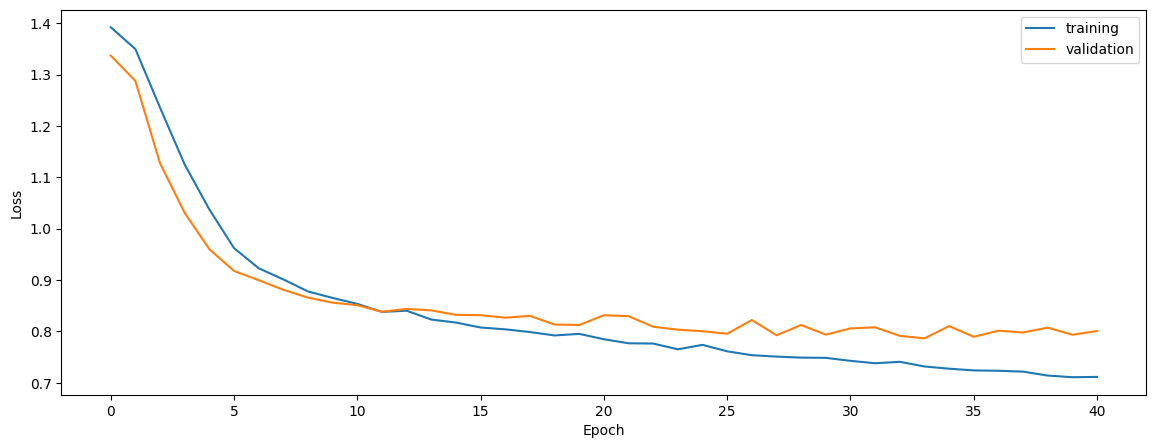

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


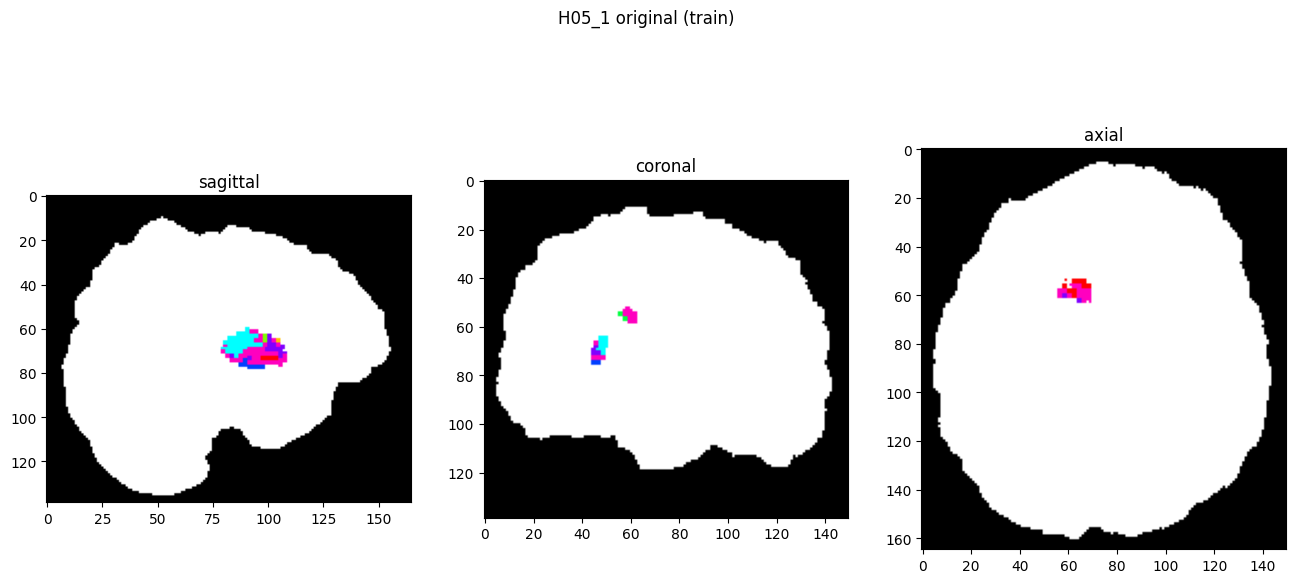

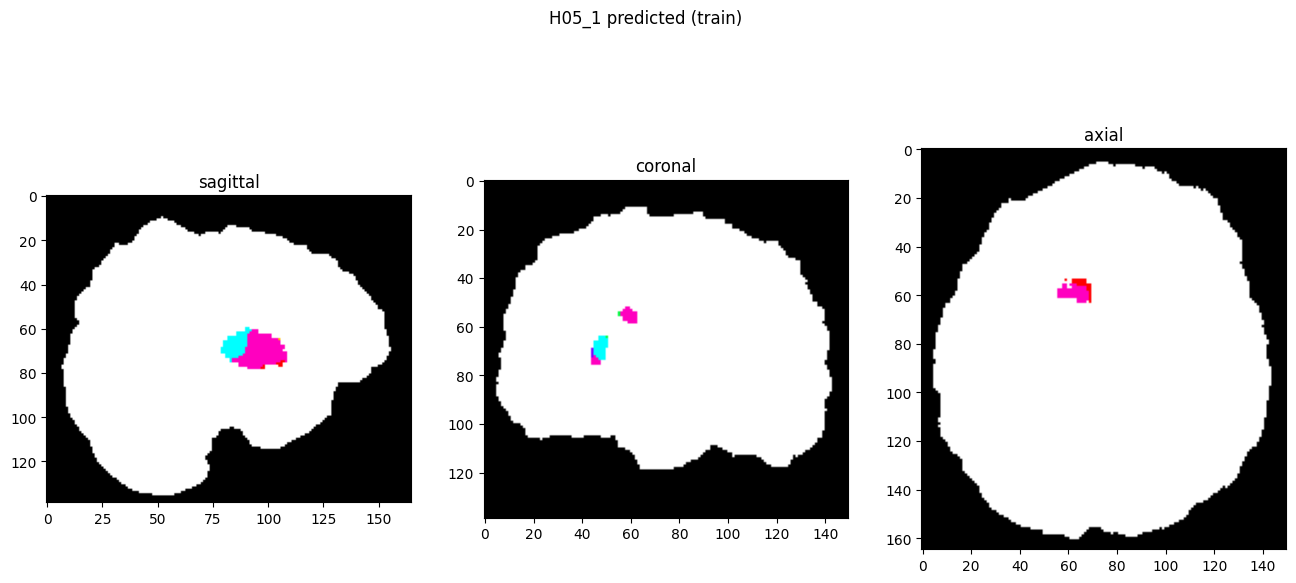

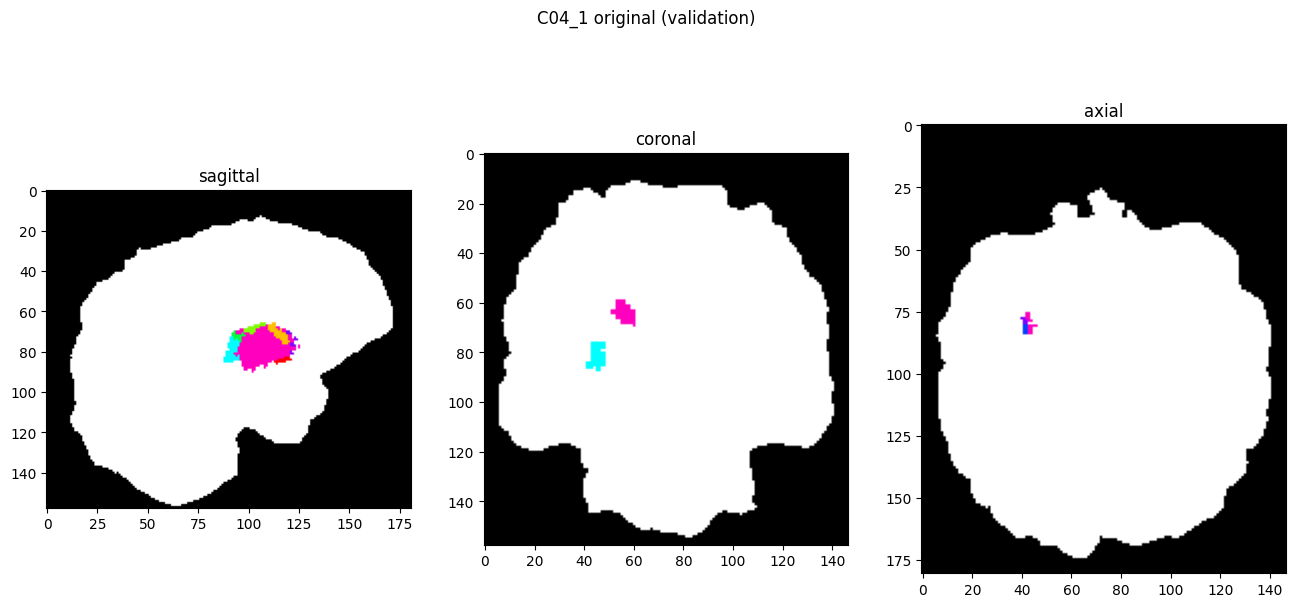

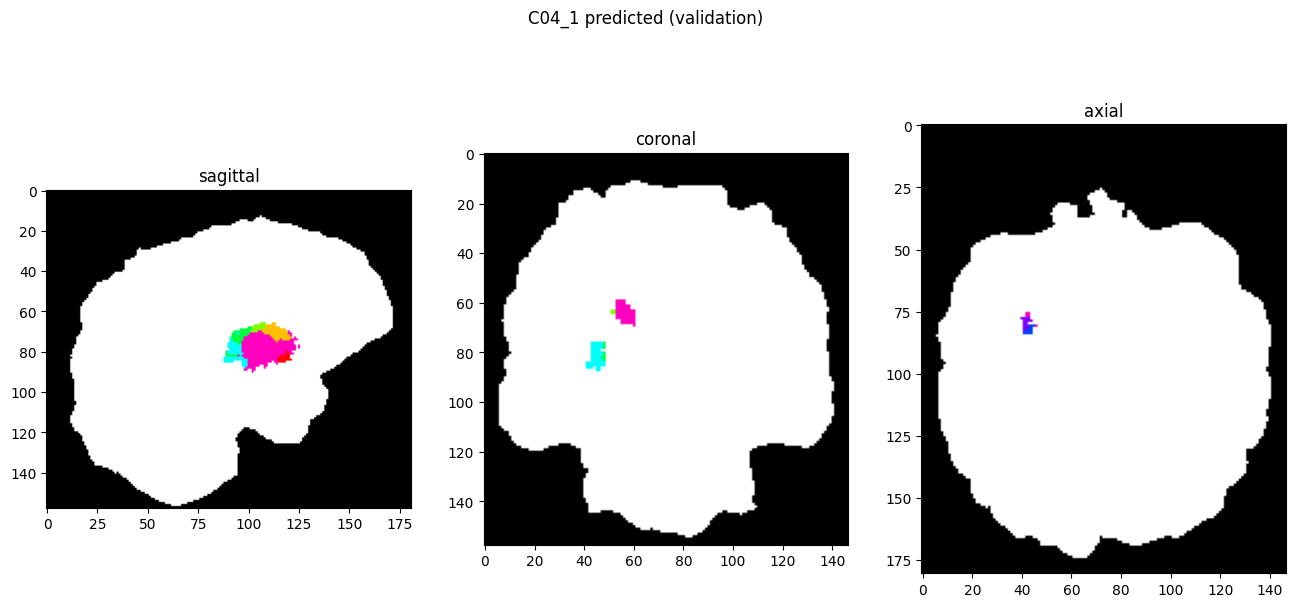

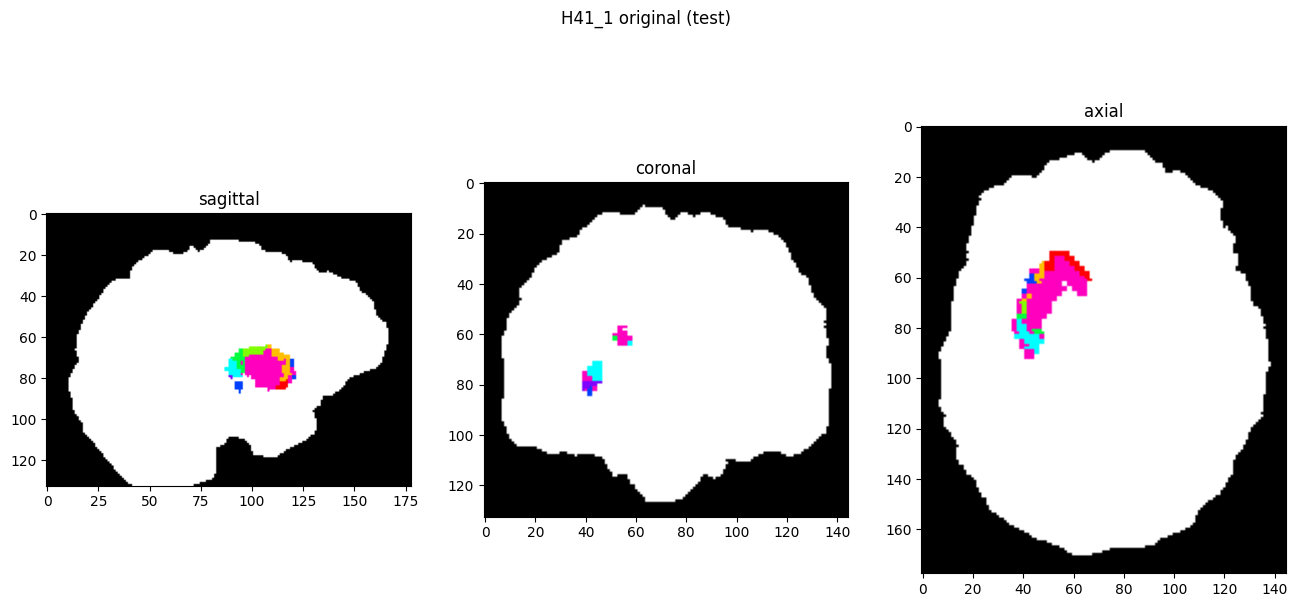

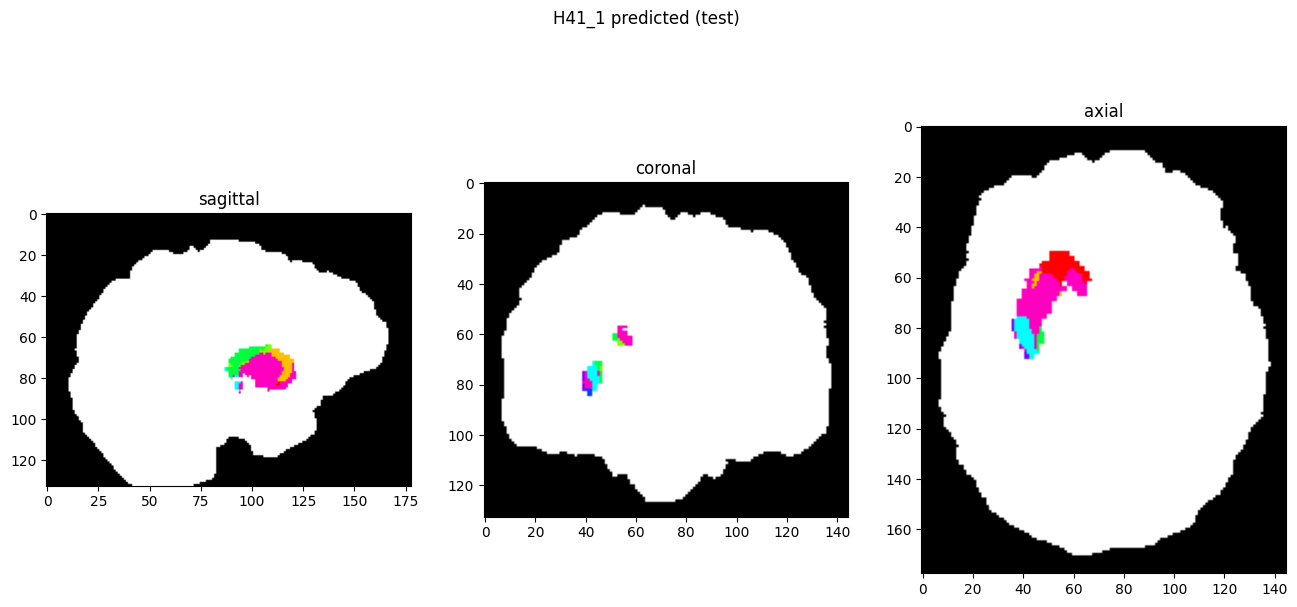

In [10]:
showResults(model, gen, threshold=0)